# Loads

## Libraries

In [188]:
options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

In [1]:
source("https://bioconductor.org/biocLite.R")
#biocLite("DESeq2")
library("DESeq2")

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min


Attaching packag

In [2]:
install.packages("pheatmap")
library("pheatmap")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [3]:
install.packages("gplots")
library(gplots)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done

Attaching package: ‘gplots’

The following object is masked from ‘package:IRanges’:

    space

The following object is masked from ‘package:S4Vectors’:

    space

The following object is masked from ‘package:stats’:

    lowess



In [4]:
install.packages("UpSetR")
library(UpSetR)
library(ggplot2)
library(grid)
library(plyr)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done

Attaching package: ‘plyr’

The following object is masked from ‘package:matrixStats’:

    count

The following object is masked from ‘package:IRanges’:

    desc

The following object is masked from ‘package:S4Vectors’:

    rename



In [5]:
require(graphics)
require(grDevices)
library(RColorBrewer)
library(viridis)

Loading required package: viridisLite


In [8]:
biocLite("org.Mm.eg.db")
library(org.Mm.eg.db)

BioC_mirror: https://bioconductor.org
Using Bioconductor 3.6 (BiocInstaller 1.28.0), R 3.4.2 (2017-09-28).
Installing package(s) ‘org.Mm.eg.db’
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'htmlTable', 'RcppArmadillo', 'rtracklayer', 'yaml'
Loading required package: AnnotationDbi



In [9]:
install.packages("rentrez")
library(rentrez)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [167]:
library("goseq")
biocLite("TxDb.Mmusculus.UCSC.mm10.knownGene")

Loading required package: BiasedUrn
Loading required package: geneLenDataBase

BioC_mirror: https://bioconductor.org
Using Bioconductor 3.6 (BiocInstaller 1.28.0), R 3.4.2 (2017-09-28).
Installing package(s) ‘TxDb.Mmusculus.UCSC.mm10.knownGene’
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'htmlTable', 'RcppArmadillo', 'rtracklayer', 'yaml'


## Functions

In [10]:
get_perc = function(v, l){
    s = sum(v, na.rm=T)
    return(round(s*100/l, digits=2))
}
get_sign_padj = function(dge_res) {
    return(get_perc(dge_res$padj < 0.05, sum(!is.na(dge_res$log2FoldChange))))
}
get_pos_sign_padj = function(dge_res) {
    return(get_perc(dge_res$padj < 0.05 & dge_res$log2FoldChange > 0, sum(!is.na(dge_res$log2FoldChange))))
}
get_neg_sign_padj = function(dge_res) {
    return(get_perc(dge_res$padj < 0.05 & dge_res$log2FoldChange < 0, sum(!is.na(dge_res$log2FoldChange))))
}
get_stats_padj  = function(dge_res) {
    v = c(get_sign_padj(dge_res), get_pos_sign_padj(dge_res), get_neg_sign_padj(dge_res))
    names(v) = c("Wald padj < 0.05", "LFC > 0 (Wald padj < 0.05)", "LFC < 0 (Wald padj < 0.05)")
    return(v)
}

In [343]:
clean_mat = function(mat){
    new_mat = mat
    new_mat[is.na(new_mat)] = 0
    new_mat = new_mat[rowSums(new_mat) > 0,]
    return(new_mat)
}
get_interesting_cat = function(wall, data_type, cat_type){
    # extract the categories with a significant p-values (over or under represented pvalue)
    enriched_cat = lapply(wall, function(x) x[p.adjust(x[,data_type],method="BH")<.05,])
    # extract the category names for the significant categories and merge them for all the comparisons
    if(cat_type == "GO"){
        cat = unique(do.call(rbind,lapply(enriched_cat, function(x) x[,c("category","term","ontology")])))
        rownames(cat) = do.call(rbind,strsplit(rownames(cat), split='.', fixed=TRUE))[,2]
    }else{
        cat = unique(do.call(rbind,lapply(enriched_cat, function(x) cbind(rownames(x),x[,c("category")]))))
        names = cat[,1]
        cat = matrix(cat[,-1])
        rownames(cat) = names
    }
    # combine the significant categories for all comparisons
    full_mat = cbind(cat, sapply(enriched_cat, function(x) x[rownames(cat),data_type]))
    return(full_mat)
}
extract_diff_expr_genes = function(in_l, name){
    l = list()
    # extract the significant differentially expressed genes (all, upregulated, downregulated)
    l$deg = sapply(in_l, function(mat) return(mat$padj < 0.05))*1
    rownames(l$deg) = rownames(age_data[[1]])
    l$deg = clean_mat(l$deg)
    deg_names = rownames(l$deg)
    head(l$deg)
    # extract the significant differentially more expressed genes
    l$pos = sapply(in_l, function(mat) return(mat[deg_names, 'log2FoldChange'] > 0))*1
    l$pos[l$deg == 0] = 0
    rownames(l$pos) = deg_names
    l$pos = clean_mat(l$pos)
    # extract the significant differentially less expressed genes
    l$neg = sapply(in_l, function(mat) return(mat[deg_names, 'log2FoldChange'] < 0))*1
    l$neg[l$deg == 0] = 0
    rownames(l$neg) = deg_names
    l$neg = clean_mat(l$neg)
    # extract the log2FC of the significant differentially expressed genes
    l$fc_deg = sapply(in_l, function(mat) return(mat[deg_names, 'log2FoldChange']))
    rownames(l$fc_deg) = deg_names
    l$fc_deg[l$deg == 0] = NA
    write.table(l$fc_deg, name, sep = "\t", quote = FALSE)
    #system(paste("put -p", name, "-t tabular"), intern=T)
    ## GO and KEGG analysis                  
    assayed_genes = rownames(in_l[[1]])
    assayed_genes
    # extract the DE genes (1 in the deg matrix)
    de_genes = sapply(colnames(l$deg), function(x) names(which(l$deg[,x]==1)))
    # extract in the full list of genes the DE ones                  
    gene_vector = sapply(de_genes, function(x) as.integer(assayed_genes%in%x))
    rownames(gene_vector) = assayed_genes
    # fit the probability weighting function
    pwf = lapply(1:dim(gene_vector)[2], function(x) nullp(gene_vector[,x], 'mm10', 'geneSymbol', plot.fit=F))
    names(pwf) = colnames(gene_vector)
    # calculate the over and under expressed GO categories among the DE genes
    GO_wall = lapply(pwf, function(x) goseq(x,'mm10', 'geneSymbol'))
    # calculate the over and under expressed KEGG pathways among the DE genes
    KEGG_wall = lapply(pwf, function(x) goseq(x,'mm10', 'geneSymbol', test.cats="KEGG"))
    l$over_represented_GO = get_interesting_cat(GO_wall, "over_represented_pvalue", "GO")
    write.table(l$over_represented_GO, paste(name, "over_represented_GO"), sep = "\t", quote = FALSE)                
    l$under_represented_GO = get_interesting_cat(GO_wall, "under_represented_pvalue", "GO")
    write.table(l$under_represented_GO, paste(name, "under_represented_GO"), sep = "\t", quote = FALSE)
    l$over_represented_KEGG = get_interesting_cat(KEGG_wall, "over_represented_pvalue", "KEGG")
    write.table(l$over_represented_KEGG, paste(name, "over_represented_KEGG"), sep = "\t", quote = FALSE)    
    l$under_represented_KEGG = get_interesting_cat(KEGG_wall, "under_represented_pvalue", "KEGG")
    write.table(l$under_represented_KEGG, paste(name, "under_represented_KEGG"), sep = "\t", quote = FALSE)                       
    return(l)
}                       

In [12]:
get_number = function(bool_expr) return(sum(bool_expr*1))
get_repartition = function(dge_mat) return(cbind(get_number(dge_mat[,1]>0 & dge_mat[,2]>0), get_number(dge_mat[,1]>0 & dge_mat[,2]<0), get_number(dge_mat[,1]<0 & dge_mat[,2]>0), get_number(dge_mat[,1]<0 & dge_mat[,2]<0)))
get_repartition_3col = function(dge_mat) return(cbind(
    get_number(dge_mat[,1]>0 & dge_mat[,2]>0 & dge_mat[,3]>0),
    get_number(dge_mat[,1]>0 & dge_mat[,2]>0 & dge_mat[,3]<0), 
    get_number(dge_mat[,1]>0 & dge_mat[,2]<0 & dge_mat[,3]>0), 
    get_number(dge_mat[,1]>0 & dge_mat[,2]<0 & dge_mat[,3]<0), 
    get_number(dge_mat[,1]<0 & dge_mat[,2]>0 & dge_mat[,3]>0), 
    get_number(dge_mat[,1]<0 & dge_mat[,2]>0 & dge_mat[,3]<0), 
    get_number(dge_mat[,1]<0 & dge_mat[,2]<0 & dge_mat[,3]>0), 
    get_number(dge_mat[,1]<0 & dge_mat[,2]<0 & dge_mat[,3]<0)))

In [13]:
quantile_breaks = function(xs, n = 10) {
    breaks = quantile(xs, probs = seq(0, 1, length.out = n))
    breaks[!duplicated(breaks)]
}
plot_count_heatmap = function(genes, samples, annot){
    data = norm_counts[genes,samples]
    breaks = quantile_breaks(data, n = 11)
    pheatmap(data, cluster_rows=F, cluster_cols=F, show_rownames=F, show_colnames=F, annotation_col=annot, breaks=breaks, color=inferno(10))  
}

In [15]:
get_list = function(mapping){
    mapped_genes = mappedkeys(mapping)
    return(as.list(mapping[mapped_genes]))
}
# Map between Entrez Gene Identifiers and Gene Names (and description) 
eg2name = get_list(org.Mm.egGENENAME)
# Map between Gene Symbols and Entrez Gene Identifiers
symbol2eg = get_list(org.Mm.egSYMBOL2EG)
# Map between RefSeq and Entrez Gene Identifiers
refseq2eg = get_list(org.Mm.egREFSEQ2EG)
# Map between Gene Symbols and Gene Names (and description)
symbol2name = sapply(names(symbol2eg), function(x) return(eg2name[symbol2eg[[x]]]))
head(symbol2name)
# Map between Entrez Gene Identifiers and KEGG pathways
eg2kegg=as.list(org.Mm.egPATH)

$Pzp
$Pzp$`11287`
[1] "PZP, alpha-2-macroglobulin like"


$Aanat
$Aanat$`11298`
[1] "arylalkylamine N-acetyltransferase"


$Aatk
$Aatk$`11302`
[1] "apoptosis-associated tyrosine kinase"


$Abca1
$Abca1$`11303`
[1] "ATP-binding cassette, sub-family A (ABC1), member 1"


$Abca4
$Abca4$`11304`
[1] "ATP-binding cassette, sub-family A (ABC1), member 4"


$Abca2
$Abca2$`11305`
[1] "ATP-binding cassette, sub-family A (ABC1), member 2"

In [16]:
# search on Entrez the correct name
search_name = function(name){
    search = entrez_search(db="gene",term=name)
    names = c()
    for(id in search$ids){
        sum = entrez_summary(db="gene", id=id)
        if(sum$organism$scientificname == 'Mus musculus' & grepl(name,sum$otheraliases)){
            names = c(names, sum$name)
        }
    }
    return(names)
}

In [135]:
capFirst = function(s) {
    paste(substring(s, 1, 1), tolower(substring(s, 2)), sep = "")
}

# Get the data

In [17]:
# Load the count table
#counts = read.table(system("get -i 1184 ", intern=T), sep="\t", header = 1, row.names=1)
counts = read.table("../data/counts.tabular", sep="\t", header = 1, row.names=1)

In [18]:
# get refseq ids for genes
refseq = sapply(rownames(counts), function(x) return(symbol2eg[[x]])) 
length(refseq[sapply(refseq, is.null)])
to_change = names(refseq[sapply(refseq, is.null)])

[1] 582

In [19]:
changes = sapply(to_change, search_name)

In [20]:
doubled = sapply(names(changes), function(x) return(length(changes[[x]])>1))
length(changes[doubled])  
single = changes[!doubled]
duplicated = single %in% rownames(counts)
length(single[duplicated])
non_duplicated = single[!duplicated]
duplicated_2 = duplicated(non_duplicated)
sum(duplicated_2)
replacements = non_duplicated[!duplicated_2]                 
length(replacements)

[1] 17

[1] 10

[1] 40

[1] 515

In [21]:
# Fix name of the some genes (identified if no Entrez id found for them and with new names found)
replacements = unlist(replacements)
#rownames(counts)[rownames(counts) == "1700112E06Rik"] = "Lrmda"
new_names = rownames(counts)
names(new_names) = rownames(counts)
new_names[names(replacements)] = replacements
head(new_names)
rownames(counts) = new_names

0610005C13Rik   0610007P14Rik   0610009B22Rik   0610009L18Rik   0610009O20Rik 
"0610005C13Rik"         "Erg28" "0610009B22Rik" "0610009L18Rik" "0610009O20Rik" 
  0610010B08Rik 
"0610010B08Rik"

In [22]:
refseq_check = sapply(rownames(counts), function(x) return(symbol2eg[[x]])) 
length(refseq[sapply(refseq_check, is.null)])

[1] 68

In [23]:
# Remove the columns with spurious data
to_remove = c("SPF_8w_F_2_2")
counts = counts[,!names(counts) %in% to_remove]

In [24]:
# Extract the metadata
metadata = t(sapply(sapply(colnames(counts), strsplit, split = "_"), unlist))
metadata = metadata[,-5]
colnames(metadata) = c("type", "age", "gender", "replicate")
metadata

type age  gender replicate
GF_104w_F_1_2   GF   104w F      1        
GF_104w_F_2_2   GF   104w F      2        
GF_104w_F_3_2   GF   104w F      3        
GF_104w_M_1_2   GF   104w M      1        
GF_104w_M_2_2   GF   104w M      2        
GF_52w_M_1_2    GF   52w  M      1        
GF_52w_M_2_2    GF   52w  M      2        
GF_52w_M_3_2    GF   52w  M      3        
GF_52w_M_4_2    GF   52w  M      4        
GF_8w_M_1_2     GF   8w   M      1        
GF_8w_M_2_2     GF   8w   M      2        
GF_8w_M_3_2     GF   8w   M      3        
GF_8w_M_4_2     GF   8w   M      4        
SPF_104w_F_1_2  SPF  104w F      1        
SPF_104w_F_2_2  SPF  104w F      2        
SPF_104w_F_3_2  SPF  104w F      3        
SPF_104w_M_1_2  SPF  104w M      1        
SPF_104w_M_2_2  SPF  104w M      2        
SPF_104w_M_3_2  SPF  104w M      3        
SPF_104w_M_4_2  SPF  104w M      4        
SPF_52w_M_1_2   SPF  52w  M      1        
SPF_52w_M_2_2   SPF  52w  M      2        
SPF_52w_M_3_2   SPF  52w  M      3        
SPF_52w_M_4_2   SPF  52w  M      4        
SPF_52w_M_5_2   SPF  52w  M      5        
SPF_8w_M_1_2    SPF  8w   M      1        
SPF_8w_M_2_2    SPF  8w   M      2        
SPF_8w_M_3_2    SPF  8w   M      3        
SPF_8w_M_4_2    SPF  8w   M      4        
GF_52w_F_1_2    GF   52w  F      1        
GF_52w_F_2_2    GF   52w  F      2        
GF_52w_F_3_2    GF   52w  F      3        
GF_52w_F_4_2    GF   52w  F      4        
GF_52w_F_5_2    GF   52w  F      5        
GF_52w_F_6_2    GF   52w  F      6        
SPF_52w_F_1_2   SPF  52w  F      1        
SPF_52w_F_2_2   SPF  52w  F      2        
SPF_52w_F_3_2   SPF  52w  F      3        
SPF_52w_F_4_2   SPF  52w  F      4        
SPF_52w_F_5_2   SPF  52w  F      5        
SPF_52w_F_6_2   SPF  52w  F      6        
SPF_104w_M_5_2  SPF  104w M      5        
SPF_104w_M_6_2  SPF  104w M      6        
SPF_104w_M_7_2  SPF  104w M      7        
SPF_104w_M_8_2  SPF  104w M      8        
SPF_104w_M_9_2  SPF  104w M      9        
SPF_104w_M_10_2 SPF  104w M      10       
SPF_104w_M_11_2 SPF  104w M      11       
SPF_104w_M_12_2 SPF  104w M      12       
SPF_104w_M_13_2 SPF  104w M      13       
SPF_104w_M_14_2 SPF  104w M      14       
SPF_8w_F_1_2    SPF  8w   F      1        
SPF_8w_F_3_2    SPF  8w   F      3        
SPF_8w_F_4_2    SPF  8w   F      4        
SPF_8w_F_5_2    SPF  8w   F      5        
GF_8w_F_1_2     GF   8w   F      1        
GF_8w_F_2_2     GF   8w   F      2        
GF_8w_F_3_2     GF   8w   F      3        
GF_8w_F_4_2     GF   8w   F      4        
GF_8w_F_5_2     GF   8w   F      5

# DGE analysis construction

## Testing how the complexification of the model explain the data

In [60]:
complexif_stats = data.frame(matrix(0, nrow=0, ncol=4))
colnames(complexif_stats) = c("Design", "Reduced", "Tested", "Genes with LRT padj < 0.05")

In [61]:
# Design: gender
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender)
dge = DESeq(dds, test="LRT", reduced = ~ 1)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender", "1", "gender", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 714 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [62]:
# Design: type
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ type)
dge = DESeq(dds, test="LRT", reduced = ~ 1)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("type", "1", "type", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 724 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [63]:
# Design: age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ age)
dge = DESeq(dds, test="LRT", reduced = ~ 1)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("age", "1", "age", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 761 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [64]:
# Design: gender + type
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type)
dge = DESeq(dds, test="LRT", reduced = ~ gender)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type", "gender", "type", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 744 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [65]:
# Design: gender + age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + age)
dge = DESeq(dds, test="LRT", reduced = ~ gender)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + age", "gender", "age", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 577 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [66]:
# Design: type + gender
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ type + gender)
dge = DESeq(dds, test="LRT", reduced = ~ type)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("type + gender", "type", "gender", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 744 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [67]:
# Design: type + age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ type + age)
dge = DESeq(dds, test="LRT", reduced = ~ type)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("type + age", "type", "age", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 546 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [68]:
# Design: age + gender
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ age + gender)
dge = DESeq(dds, test="LRT", reduced = ~ age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("age + gender", "age", "gender", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 577 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [69]:
# Design: age + type
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ age + type)
dge = DESeq(dds, test="LRT", reduced = ~ age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("age + type", "age", "type", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 546 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [70]:
# Design: gender + type + gender:type
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + gender:type)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + gender:type", "gender + type", "gender:type", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 558 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [71]:
# Design: gender + age + gender:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + age + gender:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + age + gender:age", "gender + age", "gender:age", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 330 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [72]:
# Design: type + age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ type + age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ type + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("type + age + type:age", "type + age", "type:age", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 323 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [73]:
# Design: gender + type + age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age", "gender + type", "age", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 357 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [74]:
# Design: gender + type + age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age", "gender + age", "type", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 357 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [75]:
# Design: gender + type + age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age)
dge = DESeq(dds, test="LRT", reduced = ~ type + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age", "type + age", "gender", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 357 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [76]:
# Design: gender + type + age + gender:type
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type", "gender + type + age", "gender:type", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 297 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [77]:
# Design: gender + type + age + gender:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:age", "gender + type + age", "gender:age", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 219 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [78]:
# Design: gender + type + age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + type:age", "gender + type + age", "type:age", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 235 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [79]:
# Design: gender + type + age + gender:type + gender:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + gender:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:type)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + gender:age", "gender + type + age + gender:type", "gender:age", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 215 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [80]:
# Design: gender + type + age + gender:type + gender:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + gender:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + gender:age", "gender + type + age + gender:age", "gender:type", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 215 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [81]:
# Design: gender + type + age + gender:type + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:type)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + type:age", "gender + type + age + gender:type", "type:age", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 227 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [83]:
# Design: gender + type + age + gender:type + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + type:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + type:age", "gender + type + age + type:age", "gender:type", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 227 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [84]:
# Design: gender + type + age + gender:age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:age + type:age", "gender + type + age + gender:age", "type:age", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
2 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT
-- replacing outliers and refitting for 213 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [85]:
# Design: gender + type + age + gender:age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + type:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:age + type:age", "gender + type + age + type:age", "gender:age", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
2 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT
-- replacing outliers and refitting for 213 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [86]:
# Design: gender + type + age + gender:type + gender:age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + gender:age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:type + gender:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + gender:age + type:age", "gender + type + age + gender:type + gender:age", "type:age", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
12 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT
-- replacing outliers and refitting for 168 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
1 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT


In [87]:
# Design: gender + type + age + gender:type + gender:age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + gender:age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:type + type:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + gender:age + type:age", "gender + type + age + gender:type + type:age", "gender:age", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
12 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT
-- replacing outliers and refitting for 168 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
1 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT


In [88]:
# Design: gender + type + age + gender:type + gender:age + type:age
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:type + gender:age + type:age)
dge = DESeq(dds, test="LRT", reduced = ~ gender + type + age + gender:age + type:age)
LRT_res = results(dge, alpha=0.05)
complexif_stats[nrow(complexif_stats) + 1,] = c("gender + type + age + gender:type + gender:age + type:age", "gender + type + age + gender:age + type:age", "gender:type", get_sign_padj(LRT_res))

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
12 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT
-- replacing outliers and refitting for 168 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
1 rows did not converge in beta, labelled in mcols(object)$fullBetaConv. Use larger maxit argument with nbinomLRT


In [89]:
complexif_stats

Design                                                   
1  gender                                                   
2  type                                                     
3  age                                                      
4  gender + type                                            
5  gender + age                                             
6  type + gender                                            
7  type + age                                               
8  age + gender                                             
9  age + type                                               
10 gender + type + gender:type                              
11 gender + age + gender:age                                
12 type + age + type:age                                    
13 gender + type + age                                      
14 gender + type + age                                      
15 gender + type + age                                      
16 gender + type + age + gender:type                        
17 gender + type + age + gender:age                         
18 gender + type + age + type:age                           
19 gender + type + age + gender:type + gender:age           
20 gender + type + age + gender:type + gender:age           
21 gender + type + age + gender:type + type:age             
22 gender + type + age + gender:type + type:age             
23 gender + type + age + gender:age + type:age              
24 gender + type + age + gender:age + type:age              
25 gender + type + age + gender:type + gender:age + type:age
26 gender + type + age + gender:type + gender:age + type:age
27 gender + type + age + gender:type + gender:age + type:age
   Reduced                                        Tested     
1  1                                              gender     
2  1                                              type       
3  1                                              age        
4  gender                                         type       
5  gender                                         age        
6  type                                           gender     
7  type                                           age        
8  age                                            gender     
9  age                                            type       
10 gender + type                                  gender:type
11 gender + age                                   gender:age 
12 type + age                                     type:age   
13 gender + type                                  age        
14 gender + age                                   type       
15 type + age                                     gender     
16 gender + type + age                            gender:type
17 gender + type + age                            gender:age 
18 gender + type + age                            type:age   
19 gender + type + age + gender:type              gender:age 
20 gender + type + age + gender:age               gender:type
21 gender + type + age + gender:type              type:age   
22 gender + type + age + type:age                 gender:type
23 gender + type + age + gender:age               type:age   
24 gender + type + age + type:age                 gender:age 
25 gender + type + age + gender:type + gender:age type:age   
26 gender + type + age + gender:type + type:age   gender:age 
27 gender + type + age + gender:age + type:age    gender:type
   Genes with LRT padj < 0.05
1  18.35                     
2  9.5                       
3  17.92                     
4  8.9                       
5  22.68                     
6  17.37                     
7  18.03                     
8  21.83                     
9  9.34                      
10 0.38                      
11 11.43                     
12 3.59                      
13 23.13                     
14 9.1                       
15 21.52                     
16 0.11                      
17 12.29                     
18 4.22            

Factor | Explanation (Percentage of genes with LRT padj < 0.05)
--- | --- | ---
gender | 17.37% - 21.83%
type | 8.9% - 9.5%
age | 17.92% - 23.13%
gender:type | 0.07% - 0.38%
gender:age | 11.36% - 12.43%
type:age | 3.59% - 4.31%

## Construct the full model

In [25]:
# Construct DESeqDataSet
dds = DESeqDataSetFromMatrix(
        countData = counts,
        colData = metadata,
        design = ~ gender + type + age + gender:age + gender:type + type:age)
# Organize levels of the factors (8w being the reference)
dds$age = relevel(dds$age, ref="8w")
dds$type = relevel(dds$type, ref="SPF")
dds$gender = relevel(dds$gender, ref="F")
# Differential expression analysis
dge = DESeq(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
17 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest
-- replacing outliers and refitting for 167 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [26]:
resultsNames(dge)

[1] "Intercept"       "gender_M_vs_F"   "type_GF_vs_SPF"  "age_104w_vs_8w" 
 [5] "age_52w_vs_8w"   "genderM.age104w" "genderM.age52w"  "genderM.typeGF" 
 [9] "typeGF.age104w"  "typeGF.age52w"

In [27]:
norm_counts = counts(dge,normalized=TRUE)

Info | M/F | GF/SPF | 104w/8w | 52w/8w | M.104w | M.52w | M.GF | GF.104w | GF.52w
--- | --- | --- | --- | --- | --- | --- | --- | --- | ---
M vs F (SPF, 8w) | 1 | | | | | | | |
M vs F (GF, 8w) | 1 | | | | | | 1 | |
M vs F (SPF, 52w) | 1 | | | | | 1 | | |
M vs F (GF, 52w) | 1 | | | | | 1 | 1 | | 1?
M vs F (SPF, 104w) | 1 | | | | 1 | | | |
M vs F (GF, 104w) | 1 | | | | 1 | | 1 | 1? |
M vs F (SPF) | 1 | | | | 1/3 | 1/3 | | |
M vs F (GF) | 1 | | | | 1/3 | 1/3 | | 1/3? | 1/3?
M vs F (8w) | 1 | | | | | | 1/2 | |
M vs F (52w) | 1 | | | | | 1 | 1/2 | | 1/2?
M vs F (104w) | 1 | | | | 1 | | 1/2 | 1/2? |
M vs F | 1 | | | | 1/3 | 1/3 | 1/2 | 1/3? | 1/3?
GF vs SPF (F, 8w) | | 1 | | | | | | |
GF vs SPF (M, 8w) | | 1 | | | | | 1 | |
GF vs SPF (F, 52w) | | 1 | | | | | | | 1
GF vs SPF (M, 52w) | | 1 | | | | 1? | 1 | | 1
GF vs SPF (F, 104w) | | 1 | | | | | | 1 |
GF vs SPF (M, 104w) | | 1 | | | 1? | | 1 | 1 |
GF vs SPF (F) | | 1 | | | | | | 1/3 | 1/3
GF vs SPF (M) | | 1 | | | 1/3? | 1/3? | 1 | 1/3 | 1/3
GF vs SPF (8w) | | 1 | | | | | 1/2 | |
GF vs SPF (52w) | | 1 | | | | 1/2? | 1/2 | | 1
GF vs SPF (104w) | | 1 | | | 1/2? | | 1/2 | 1 |
GF vs SPF | | 1 | | | 1/3? | 1/3? | 1/2 | 1/3 | 1/3
52w vs 8w (F, SPF) | | | | 1 | | | | |
52w vs 8w (F, GF) | | | | 1 | | | | | 1
52w vs 8w (M, SPF) | | | | 1 | | 1 | | |
52w vs 8w (M, GF) | | | | 1 | | 1 | 1? | | 1
52w vs 8w (F) | | | | 1 | | | | | 1/2
52w vs 8w (M) | | | | 1 | | 1 | 1/2? | | 1/2
52w vs 8w (SPF) | | | | 1 | | 1/2 | | |
52w vs 8w (GF) | | | | 1 | | 1/2 | 1/2? | | 1
52w vs 8w | | | | 1 | | 1/2 | 1/2? | | 1/2
104w vs 8w (F, SPF) | | | 1 | | | | | |
104w vs 8w (F, GF) | | | 1 | | | | | 1 |
104w vs 8w (M, SPF) | | | 1 | | 1 | | | |
104w vs 8w (M, GF) | | | 1 | | 1 | | 1? | 1 |
104w vs 8w (F) | | | 1 | | | | | 1/2 |
104w vs 8w (M) | | | 1 | | 1 | | 1/2? | 1/2 |
104w vs 8w (SPF) | | | 1 | | 1/2 | | | |
104w vs 8w (GF) | | | 1 | | 1/2 | | 1/2? | 1 |
104w vs 8w | | | 1 | | 1/2 | | 1/2? | 1/2 |
104w vs 52w (F, SPF) | | | 1 | -1 | | | | |
104w vs 52w (F, GF) | | | 1 | -1 | | | | 1 | -1
104w vs 52w (M, SPF) | | | 1 | -1 | 1 | -1 | | |
104w vs 52w (M, GF) | | | 1 | -1 | 1 | -1 | | 1 | -1
104w vs 52w (F) | | | 1 | -1 | | | | 1/2 | -1/2
104w vs 52w (M) | | | 1 | -1 | 1 | -1 | | 1/2 | -1/2
104w vs 52w (SPF) | | | 1 | -1 | 1/2 | -1/2 | | |
104w vs 52w (GF) | | | 1 | -1 | 1/2 | -1/2 | | |
104w vs 52w | | | 1 | -1 | 1/2 | -1/2 | | 1/2 | -1/2

# Age effect

Questions

- What are the differences between the ages?
- Which genes and pathways are differentially expressed between 8w and 52w, between 52w and 104w, between 8w and 104w? Are they the same? Is there a gradient?
- Are they different for the two genders?
- Are they different for the two types?

## Global stats

In [28]:
# Comparison between the ages (after controlling for type and gender)
global_52w_8w = results(dge, contrast= c(0,0,0,0,1,0,1/2,0,0,1/2), alpha=0.05, test="Wald")
global_104w_8w = results(dge, contrast= c(0,0,0,1,0,1/2,0,0,1/2,0), alpha=0.05, test="Wald")
global_104w_52w = results(dge, contrast= c(0,0,0,1,-1,1/2,-1/2,0,1/2,-1/2), alpha=0.05, test="Wald")
# Stats
global_stats = matrix(0, nrow=3, ncol=3)
rownames(global_stats) = c("52w VS 8w", "104w VS 8w", "104w VS 52w")
colnames(global_stats) = c("Wald padj < 0.05", "LFC > 0 (Wald padj < 0.05)", "LFC < 0 (Wald padj < 0.05)")
global_stats[1,] = get_stats_padj(global_52w_8w)
global_stats[2,] = get_stats_padj(global_104w_8w)
global_stats[3,] = get_stats_padj(global_104w_52w)
global_stats

Wald padj < 0.05 LFC > 0 (Wald padj < 0.05)
52w VS 8w   10.41            5.68                      
104w VS 8w  15.41            8.21                      
104w VS 52w 11.02            6.04                      
            LFC < 0 (Wald padj < 0.05)
52w VS 8w   4.74                      
104w VS 8w  7.20                      
104w VS 52w 4.98

In [29]:
# Interactions between ages and types (after controlling gender)
SPF_52w_8w = results(dge,contrast= c(0,0,0,0,1,0,1/2,0,0,0), alpha=0.05, test="Wald")
GF_52w_8w = results(dge,contrast= c(0,0,0,0,1,0,1/2,0,0,1), alpha=0.05, test="Wald")
SPF_104w_8w = results(dge,contrast= c(0,0,0,1,0,1/2,0,0,0,0), alpha=0.05, test="Wald")
GF_104w_8w = results(dge,contrast= c(0,0,0,1,0,1/2,0,0,1,0), alpha=0.05, test="Wald")
SPF_104w_52w = results(dge,contrast= c(0,0,0,1,-1,1/2,-1/2,0,0,0), alpha=0.05, test="Wald")
GF_104w_52w = results(dge,contrast= c(0,0,0,1,-1,1/2,-1/2,0,1,-1), alpha=0.05, test="Wald")
# Stats
age_type_stats = matrix(0, nrow=6, ncol=3)
rownames(age_type_stats) = c("52w VS 8w (SPF)","52w VS 8w (GF)", "104w VS 8w (SPF)", "104w VS 8w (GF)", "104w VS 52w (SPF)", "104w VS 52w (GF)")
colnames(age_type_stats) = c("Wald padj < 0.05", "LFC > 0 (Wald padj < 0.05)", "LFC < 0 (Wald padj < 0.05)")
age_type_stats[1,] = get_stats_padj(SPF_52w_8w)
age_type_stats[2,] = get_stats_padj(GF_52w_8w)
age_type_stats[3,] = get_stats_padj(SPF_104w_8w)
age_type_stats[4,] = get_stats_padj(GF_104w_8w)
age_type_stats[5,] = get_stats_padj(SPF_104w_52w)
age_type_stats[6,] = get_stats_padj(GF_104w_52w)
age_type_stats

Wald padj < 0.05 LFC > 0 (Wald padj < 0.05)
52w VS 8w (SPF)    6.71            3.84                      
52w VS 8w (GF)     2.90            1.77                      
104w VS 8w (SPF)  15.60            8.56                      
104w VS 8w (GF)    8.98            4.69                      
104w VS 52w (SPF)  7.11            4.27                      
104w VS 52w (GF)   7.83            4.08                      
                  LFC < 0 (Wald padj < 0.05)
52w VS 8w (SPF)   2.87                      
52w VS 8w (GF)    1.12                      
104w VS 8w (SPF)  7.03                      
104w VS 8w (GF)   4.29                      
104w VS 52w (SPF) 2.84                      
104w VS 52w (GF)  3.75

In [30]:
# Interactions between ages and genders (after controlling type)
F_52w_8w = results(dge,contrast= c(0,0,0,0,1,0,0,0,0,1/2), alpha=0.05, test="Wald")
M_52w_8w = results(dge,contrast= c(0,0,0,0,1,0,1,0,0,1/2), alpha=0.05, test="Wald")
F_104w_8w = results(dge,contrast= c(0,0,0,1,0,0,0,0,1/2,0), alpha=0.05, test="Wald")
M_104w_8w = results(dge,contrast= c(0,0,0,1,0,1,0,0,1/2,0), alpha=0.05, test="Wald")
F_104w_52w = results(dge,contrast= c(0,0,0,1,-1,0,0,0,1/2,-1/2), alpha=0.05, test="Wald")
M_104w_52w = results(dge,contrast= c(0,0,0,1,-1,1,-1,0,1/2,-1/2), alpha=0.05, test="Wald")
# Stats
age_gender_stats = matrix(0, nrow=6, ncol=3)
rownames(age_gender_stats) = c("52w VS 8w (F)","52w VS 8w (M)", "104w VS 8w (F)", "104w VS 8w (M)", "104w VS 52w (F)", "104w VS 52w (M)")
colnames(age_gender_stats) = c("Wald padj < 0.05", "LFC > 0 (Wald padj < 0.05)", "LFC < 0 (Wald padj < 0.05)")
age_gender_stats[1,] = get_stats_padj(F_52w_8w)
age_gender_stats[2,] = get_stats_padj(M_52w_8w)
age_gender_stats[3,] = get_stats_padj(F_104w_8w)
age_gender_stats[4,] = get_stats_padj(M_104w_8w)
age_gender_stats[5,] = get_stats_padj(F_104w_52w)
age_gender_stats[6,] = get_stats_padj(M_104w_52w)
age_gender_stats

Wald padj < 0.05 LFC > 0 (Wald padj < 0.05)
52w VS 8w (F)   11.00            6.11                      
52w VS 8w (M)    2.06            1.26                      
104w VS 8w (F)   8.89            5.18                      
104w VS 8w (M)  17.89            9.29                      
104w VS 52w (F)  1.40            0.82                      
104w VS 52w (M) 18.69            9.53                      
                LFC < 0 (Wald padj < 0.05)
52w VS 8w (F)   4.89                      
52w VS 8w (M)   0.80                      
104w VS 8w (F)  3.70                      
104w VS 8w (M)  8.60                      
104w VS 52w (F) 0.58                      
104w VS 52w (M) 9.16

In [31]:
# Interactions between ages, types and genders
F_SPF_52w_8w = results(dge,contrast= c(0,0,0,0,1,0,0,0,0,0), alpha=0.05, test="Wald")
F_GF_52w_8w = results(dge,contrast= c(0,0,0,0,1,0,0,0,0,1), alpha=0.05, test="Wald")
M_SPF_52w_8w = results(dge,contrast= c(0,0,0,0,1,0,1,0,0,0), alpha=0.05, test="Wald")
M_GF_52w_8w = results(dge,contrast= c(0,0,0,0,1,0,1,0,0,1), alpha=0.05, test="Wald")
F_SPF_104w_8w = results(dge,contrast= c(0,0,0,1,0,0,0,0,0,0), alpha=0.05, test="Wald")
F_GF_104w_8w = results(dge,contrast= c(0,0,0,1,0,0,0,0,1,0), alpha=0.05, test="Wald")
M_SPF_104w_8w = results(dge,contrast= c(0,0,0,1,0,1,0,0,0,0), alpha=0.05, test="Wald")
M_GF_104w_8w = results(dge,contrast= c(0,0,0,1,0,1,0,0,1,0), alpha=0.05, test="Wald")
F_SPF_104w_52w = results(dge,contrast= c(0,0,0,1,-1,0,0,0,0,0), alpha=0.05, test="Wald")
F_GF_104w_52w = results(dge,contrast= c(0,0,0,1,-1,0,0,0,1,-1), alpha=0.05, test="Wald")
M_SPF_104w_52w = results(dge,contrast= c(0,0,0,1,-1,1,-1,0,0,0), alpha=0.05, test="Wald")
M_GF_104w_52w = results(dge,contrast= c(0,0,0,1,-1,1,-1,0,1,-1), alpha=0.05, test="Wald")
# Stats
age_gender_type_stats = matrix(0, nrow=12, ncol=3)
rownames(age_gender_type_stats) = c("52w VS 8w (F, SPF)","52w VS 8w (F, GF)", "52w VS 8w (M, SPF)", "52w VS 8w (M, GF)", "104w VS 8w (F, SPF)", "104w VS 8w (F, GF)", "104w VS 8w (M, SPF)", "104w VS 8w (M, GF)", "104w VS 52w (F, SPF)", "104w VS 52w (F, GF)", "104w VS 52w (M, SPF)", "104w VS 52w (M, GF)")
colnames(age_gender_type_stats) = c("Wald padj < 0.05", "LFC > 0 (Wald padj < 0.05)", "LFC < 0 (Wald padj < 0.05)")
age_gender_type_stats[1,] = get_stats_padj(F_SPF_52w_8w)
age_gender_type_stats[2,] = get_stats_padj(F_GF_52w_8w)
age_gender_type_stats[3,] = get_stats_padj(M_SPF_52w_8w)
age_gender_type_stats[4,] = get_stats_padj(M_GF_52w_8w)
age_gender_type_stats[5,] = get_stats_padj(F_SPF_104w_8w)
age_gender_type_stats[6,] = get_stats_padj(F_GF_104w_8w)
age_gender_type_stats[7,] = get_stats_padj(M_SPF_104w_8w)
age_gender_type_stats[8,] = get_stats_padj(M_GF_104w_8w)
age_gender_type_stats[9,] = get_stats_padj(F_SPF_104w_52w)
age_gender_type_stats[10,] = get_stats_padj(F_GF_104w_52w)
age_gender_type_stats[11,] = get_stats_padj(M_SPF_104w_52w)
age_gender_type_stats[12,] = get_stats_padj(M_GF_104w_52w)
age_gender_type_stats

Wald padj < 0.05 LFC > 0 (Wald padj < 0.05)
52w VS 8w (F, SPF)    8.68            5.01                      
52w VS 8w (F, GF)     4.95            3.07                      
52w VS 8w (M, SPF)    1.77            1.19                      
52w VS 8w (M, GF)     1.11            0.61                      
104w VS 8w (F, SPF)   9.67            5.35                      
104w VS 8w (F, GF)    6.89            3.73                      
104w VS 8w (M, SPF)  18.65            9.99                      
104w VS 8w (M, GF)   11.30            5.77                      
104w VS 52w (F, SPF)  1.04            0.56                      
104w VS 52w (F, GF)   2.17            1.12                      
104w VS 52w (M, SPF) 16.55            8.91                      
104w VS 52w (M, GF)  13.26            6.66                      
                     LFC < 0 (Wald padj < 0.05)
52w VS 8w (F, SPF)   3.67                      
52w VS 8w (F, GF)    1.89                      
52w VS 8w (M, SPF)   0.58                      
52w VS 8w (M, GF)    0.50                      
104w VS 8w (F, SPF)  4.32                      
104w VS 8w (F, GF)   3.17                      
104w VS 8w (M, SPF)  8.66                      
104w VS 8w (M, GF)   5.53                      
104w VS 52w (F, SPF) 0.48                      
104w VS 52w (F, GF)  1.05                      
104w VS 52w (M, SPF) 7.64                      
104w VS 52w (M, GF)  6.60

## Comparison between the ages (after controlling for type and gender)
Questions

- What are the differences between the ages?
- Which genes and pathways are differentially expressed between 8w and 52w, between 52w and 104w, between 8w and 104w? Are they the same? Is there a gradient?

In [367]:
age_data = list(global_52w_8w, global_104w_8w, global_104w_52w)
names(age_data) = c("52w VS 8w", "104w VS 8w", "104w VS 52w")
age_deg = extract_diff_expr_genes(age_data, "age_data")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

In [368]:
samples = c(
    'SPF_8w_F_1_2','SPF_8w_F_3_2','SPF_8w_F_4_2','SPF_8w_F_5_2','GF_8w_F_1_2','GF_8w_F_2_2','GF_8w_F_3_2','GF_8w_F_4_2','GF_8w_F_5_2','SPF_8w_M_1_2','SPF_8w_M_2_2','SPF_8w_M_3_2','SPF_8w_M_4_2','GF_8w_M_1_2','GF_8w_M_2_2','GF_8w_M_3_2','GF_8w_M_4_2',
    'SPF_52w_F_1_2','SPF_52w_F_2_2','SPF_52w_F_3_2','SPF_52w_F_4_2','SPF_52w_F_5_2','SPF_52w_F_6_2','GF_52w_F_1_2','GF_52w_F_2_2','GF_52w_F_3_2','GF_52w_F_4_2','GF_52w_F_5_2','GF_52w_F_6_2','SPF_52w_M_1_2','SPF_52w_M_2_2','SPF_52w_M_3_2','SPF_52w_M_4_2','SPF_52w_M_5_2','GF_52w_M_1_2','GF_52w_M_2_2','GF_52w_M_3_2','GF_52w_M_4_2',
    'SPF_104w_F_1_2','SPF_104w_F_2_2','SPF_104w_F_3_2','GF_104w_F_1_2','GF_104w_F_2_2','GF_104w_F_3_2','SPF_104w_M_1_2','SPF_104w_M_2_2','SPF_104w_M_3_2','SPF_104w_M_4_2','SPF_104w_M_5_2','SPF_104w_M_6_2','SPF_104w_M_7_2','SPF_104w_M_8_2','SPF_104w_M_9_2','SPF_104w_M_10_2','SPF_104w_M_11_2','SPF_104w_M_12_2','SPF_104w_M_13_2','SPF_104w_M_14_2','GF_104w_M_1_2','GF_104w_M_2_2')
annot = as.data.frame(colData(dge)[, c("age", "gender", "type")])

In [369]:
get_interesting_cat = function(wall, data_type, cat_type){
    # extract the categories with a significant p-values (over or under represented pvalue)
    enriched_cat = lapply(wall, function(x) x[p.adjust(x[,data_type],method="BH")<.05,])
    # extract the category names for the significant categories and merge them for all the comparisons
    if(cat_type == "GO"){
        cat = unique(do.call(rbind,lapply(enriched_cat, function(x) x[,c("category","term","ontology")])))
        rownames(cat) = do.call(rbind,strsplit(rownames(cat), split='.', fixed=TRUE))[,2]
    }else{
        cat = unique(do.call(rbind,lapply(enriched_cat, function(x) cbind(rownames(x),x[,c("category")]))))
        names = cat[,1]
        cat = matrix(cat[,-1])
        rownames(cat) = names
    }
    # combine the significant categories for all comparisons
    full_mat = cbind(cat, sapply(enriched_cat, function(x) x[rownames(cat),data_type]))
    return(full_mat)
}
enriched_cat = lapply(KEGG_wall, function(x) x[p.adjust(x[,"over_represented_pvalue"],method="BH")<.05,])
cat = unique(unlist(lapply(enriched_cat, function(x) x[,c("category")])))
head(get_interesting_cat(KEGG_wall, "over_represented_pvalue", "KEGG"))
head(get_interesting_cat(KEGG_wall, "under_represented_pvalue", "KEGG"))

52w VS 8w            104w VS 8w          104w VS 52w         
186 05010 1.16288581318815e-13 0.00413694578321789 3.73983736993701e-19
16  00190 1.74956467441086e-13 NA                  1.68160618498198e-29
189 05016 7.1397273437822e-11  NA                  3.14462593898961e-17
187 05012 1.87011882556018e-10 NA                  2.73447120289262e-25
96  03040 1.69943239910491e-07 NA                  NA                  
119 04141 3.75228242230979e-07 NA                  NA

52w VS 8w            104w VS 8w           104w VS 52w         
76  00830 0.000253365804779702 0.000210260397096989 NA                  
111 04080 8.47027076338757e-07 6.91923510267187e-08 3.62362825713537e-07
162 04740 0                    0                    0                   
140 04530 NA                   NA                   0.0005822128300145

### Counts

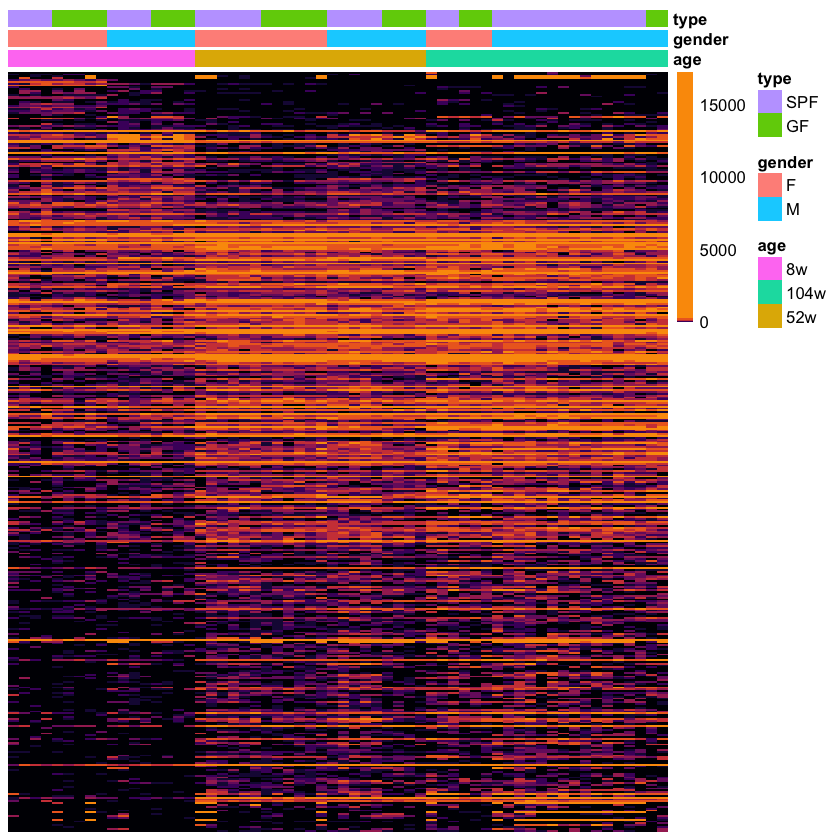

In [370]:
# 52w != 8w with abs(FC) > 2
genes = names((sort(age_deg$fc_deg[which(abs(age_deg$fc_deg[,1])>1),1])))
plot_count_heatmap(genes,samples, annot)

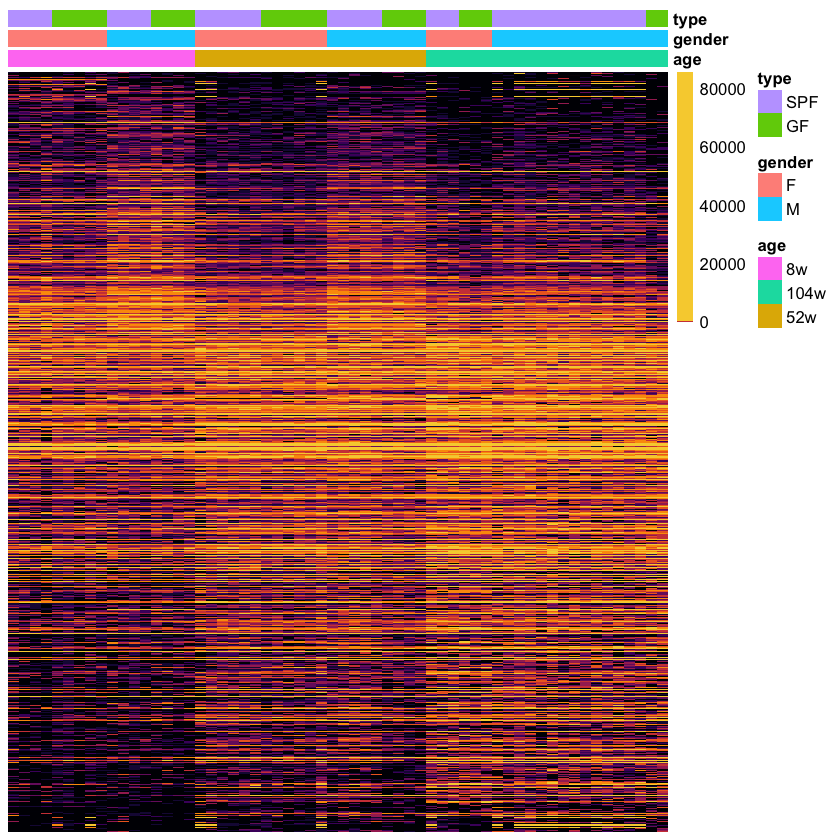

In [371]:
# 104w != 8w with abs(FC) > 2
genes = names((sort(age_deg$fc_deg[which(abs(age_deg$fc_deg[,2])>1),2])))
plot_count_heatmap(genes,samples, annot)

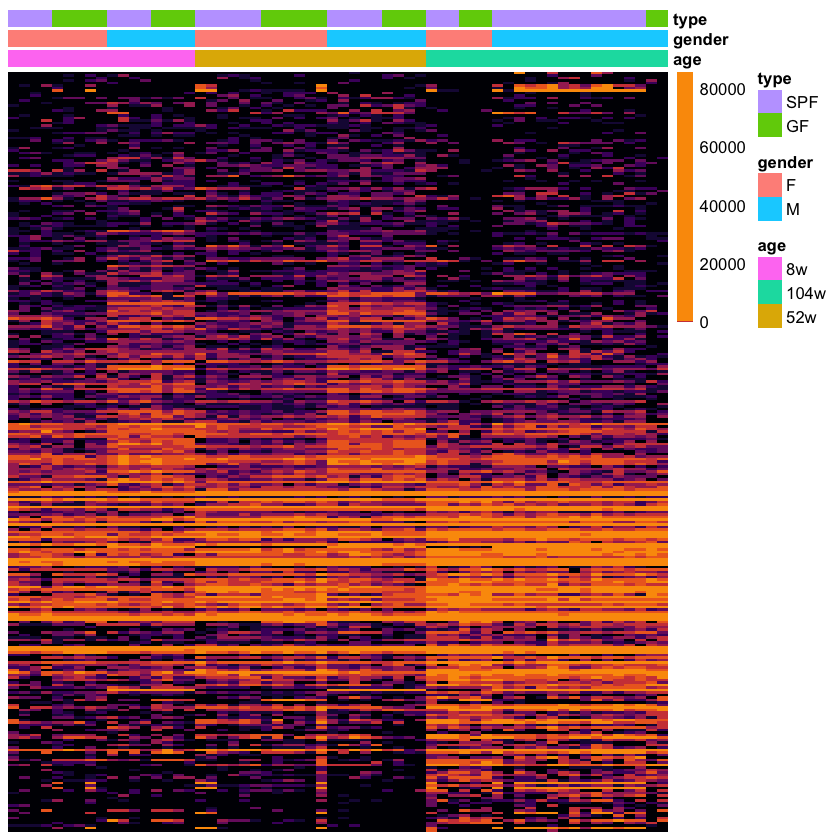

In [372]:
# 104w != 52w with abs(FC) > 2
genes = names((sort(age_deg$fc_deg[which(abs(age_deg$fc_deg[,3])>1),3])))
plot_count_heatmap(genes,samples, annot)

### Compare the numbers

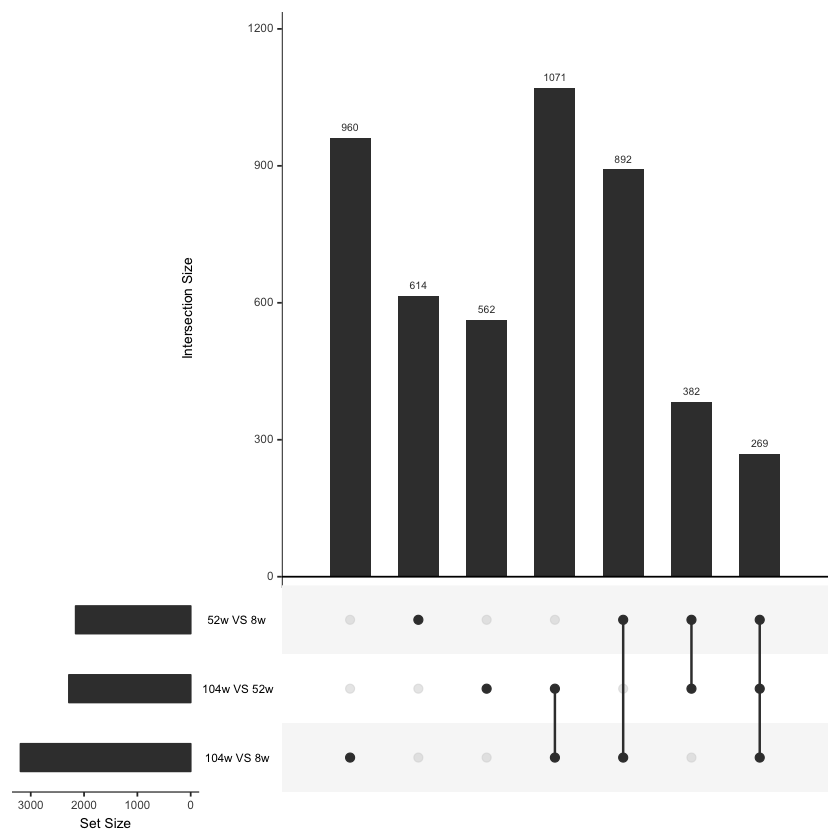

In [373]:
# Differentially expressed genes
upset(as.data.frame(age_deg$deg))

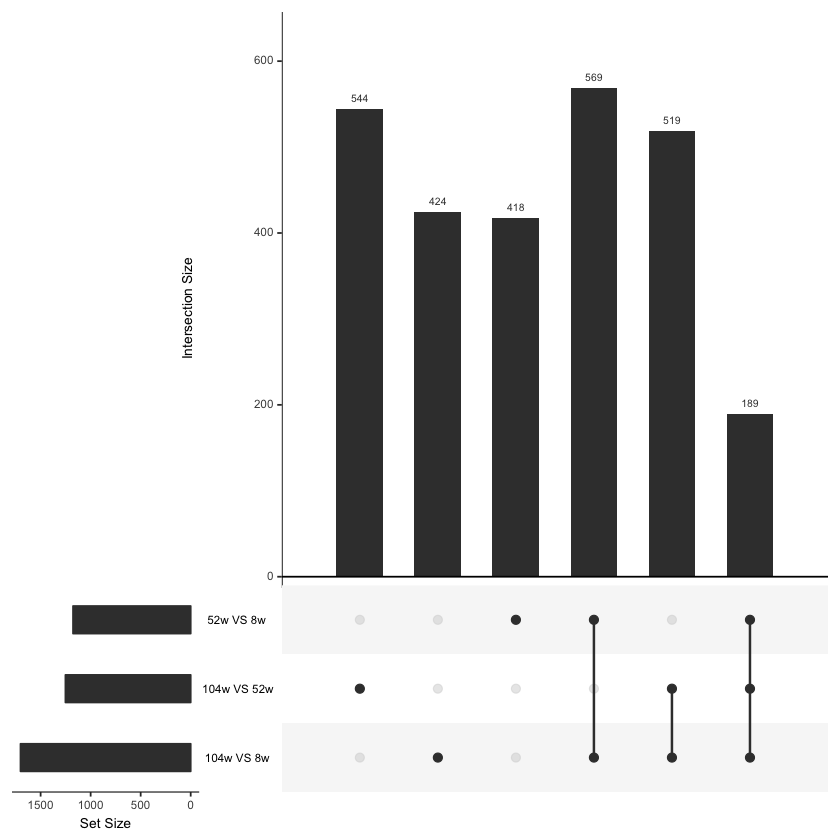

In [374]:
# Differentially more expressed genes
upset(as.data.frame(age_deg$pos))

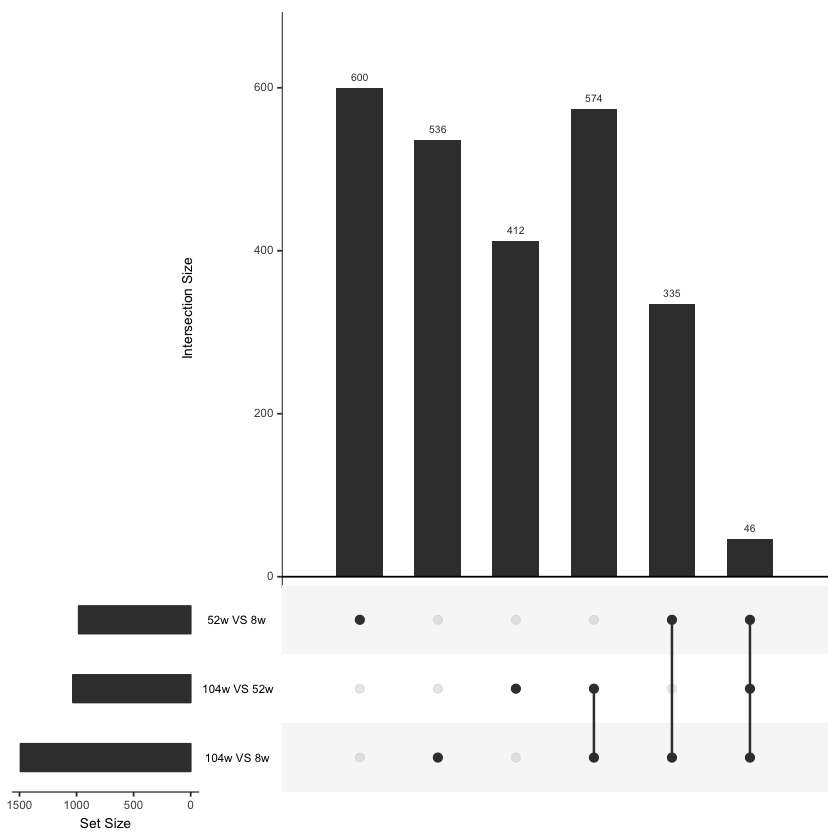

In [375]:
# Differentially less expressed genes
upset(as.data.frame(age_deg$neg))

### Compare the intersections in term of expressions

Warning message in heatmap.2(fc, Colv = NA, scale = "column", cexCol = 0.5, symbreaks = T):
“Discrepancy: Colv is FALSE, while dendrogram is `both'. Omitting column dendogram.”

52w > 8w & 104w > 8w 52w > 8w & 104w < 8w 52w < 8w & 104w > 8w
[1,] 563                  0                    0                   
     52w < 8w & 104w < 8w
[1,] 329

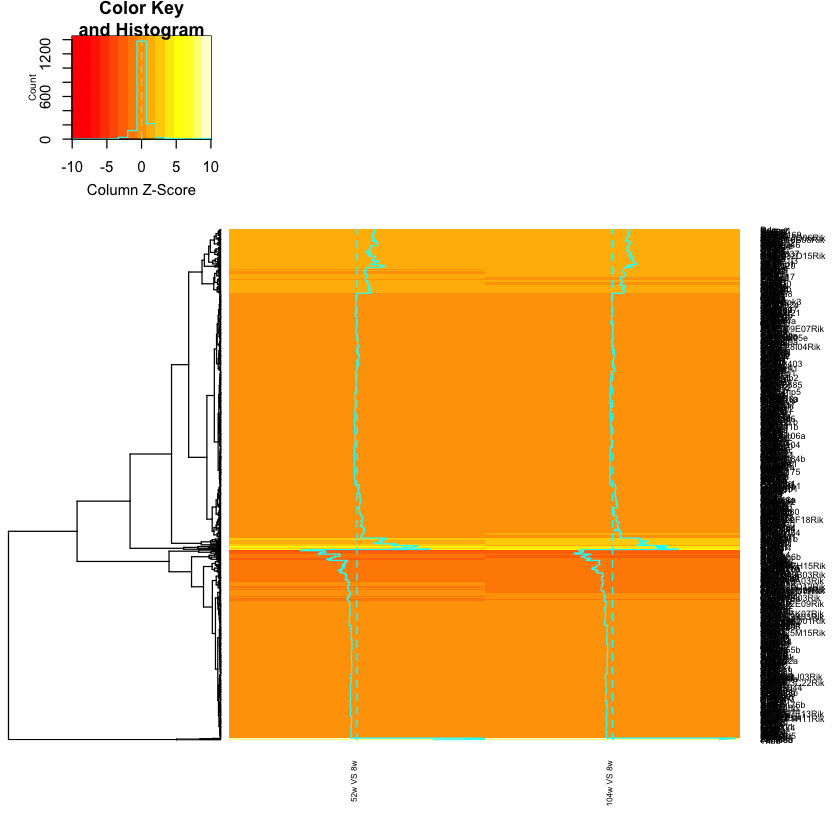

In [376]:
# Genes that are differentially expressed in 52W vs 8W and in 104W vs 8W (and not in 104w vs 52w)
fc = age_deg$fc_deg[!is.na(age_deg$fc_deg[,1]) & !is.na(age_deg$fc_deg[,2]) & is.na(age_deg$fc_deg[,3]),c(1,2)]
heatmap.2(fc, Colv = NA, scale="column", cexCol=0.5, symbreaks=T)
rep = get_repartition(fc)
colnames(rep) = c("52w > 8w & 104w > 8w", "52w > 8w & 104w < 8w", "52w < 8w & 104w > 8w", "52w < 8w & 104w < 8w")
rep

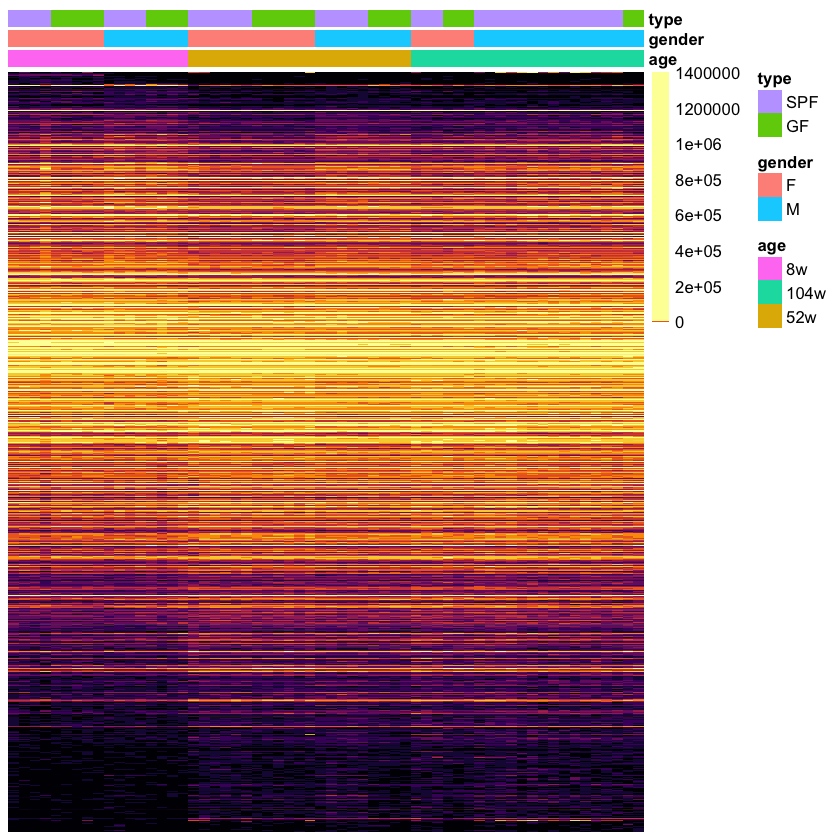

In [377]:
# 52w != 8w and 104w != 8w and 104w == 52w with abs(FC) > 1
genes = names((sort(age_deg$fc_deg[which(abs(age_deg$fc_deg[,1])>0 & abs(age_deg$fc_deg[,2])>0 & is.na(age_deg$fc_deg[,3])),1])))
plot_count_heatmap(genes,samples, annot)

Warning message in heatmap.2(fc, Colv = NA, scale = "column", cexCol = 0.5, symbreaks = T):
“Discrepancy: Colv is FALSE, while dendrogram is `both'. Omitting column dendogram.”

52w > 8w & 104w > 52w 52w > 8w & 104w < 52w 52w < 8w & 104w > 52w
[1,] 0                     107                   275                  
     52w < 8w & 104w < 52w
[1,] 0

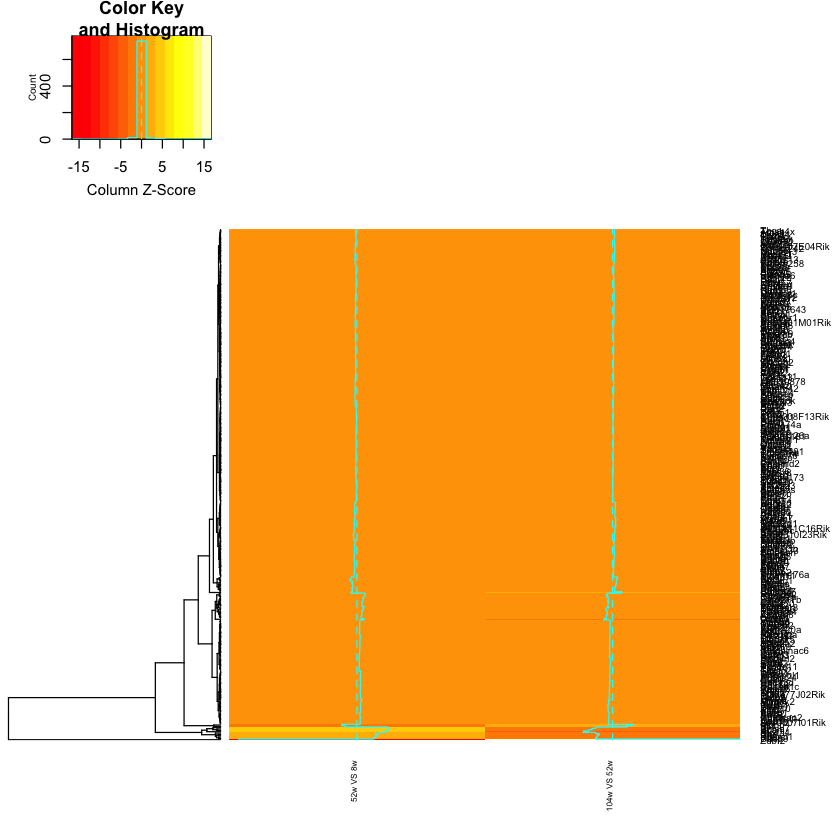

In [378]:
# Genes that are differentially expressed in 52W vs 8W and in 104W vs 52W (and not in 104w vs 52w)
fc = age_deg$fc_deg[!is.na(age_deg$fc_deg[,1]) & is.na(age_deg$fc_deg[,2]) & !is.na(age_deg$fc_deg[,3]),c(1,3)]
heatmap.2(fc, Colv = NA, scale="column", cexCol=0.5, symbreaks=T)
rep = get_repartition(fc)
colnames(rep) = c("52w > 8w & 104w > 52w", "52w > 8w & 104w < 52w", "52w < 8w & 104w > 52w", "52w < 8w & 104w < 52w")
rep

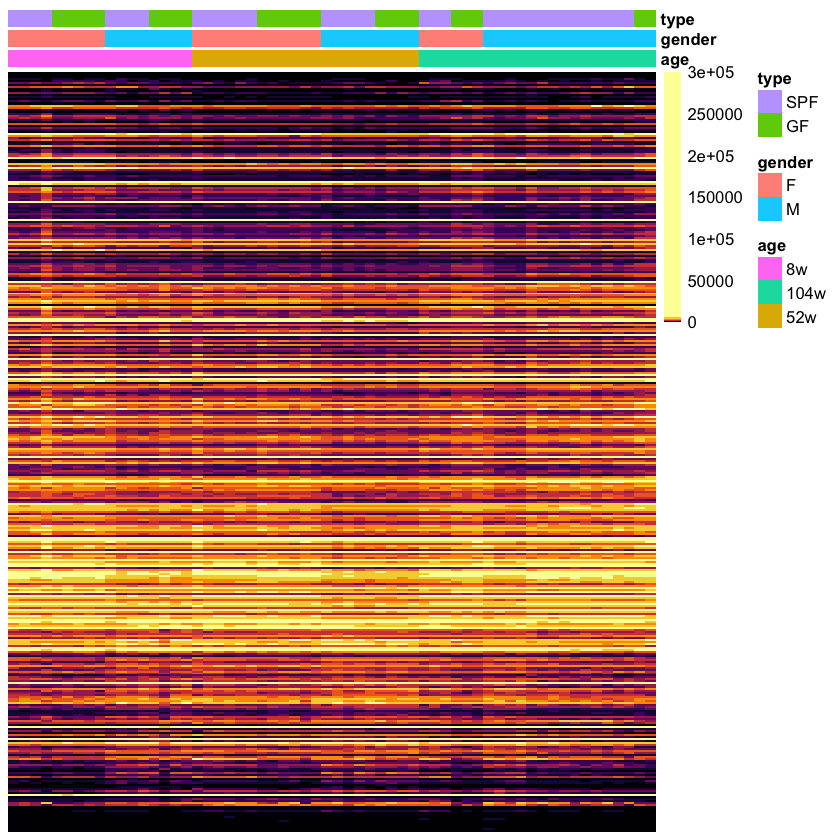

In [379]:
# 52w != 8w and 104w == 8w and 104w != 52w with abs(FC) > 1
genes = names((sort(age_deg$fc_deg[which(abs(age_deg$fc_deg[,1])>0 & is.na(age_deg$fc_deg[,2]) & abs(age_deg$fc_deg[,3])>0),1])))
plot_count_heatmap(genes,samples, annot)

Warning message in heatmap.2(fc, Colv = NA, scale = "column", cexCol = 0.5, symbreaks = T):
“Discrepancy: Colv is FALSE, while dendrogram is `both'. Omitting column dendogram.”

104w > 8w & 104w > 52w 104w > 8w & 104w < 52w 104w < 8w & 104w > 52w
[1,] 504                    0                      0                     
     104w < 8w & 104w < 52w
[1,] 567

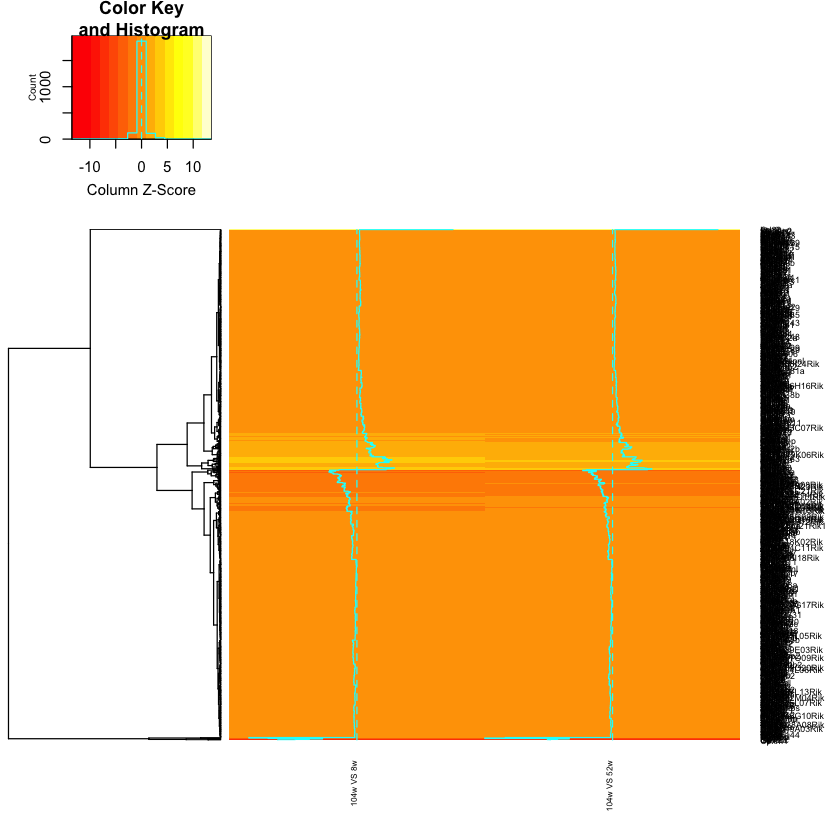

In [380]:
# Genes that are differentially expressed in 104W vs 8W and in 104W vs 52W (and not in 52w vs 8w)
fc = age_deg$fc_deg[is.na(age_deg$fc_deg[,1]) & !is.na(age_deg$fc_deg[,2]) & !is.na(age_deg$fc_deg[,3]),c(2,3)]
heatmap.2(fc, Colv = NA, scale="column", cexCol=0.5, symbreaks=T)
rep = get_repartition(fc)
colnames(rep) = c("104w > 8w & 104w > 52w", "104w > 8w & 104w < 52w", "104w < 8w & 104w > 52w", "104w < 8w & 104w < 52w")
rep

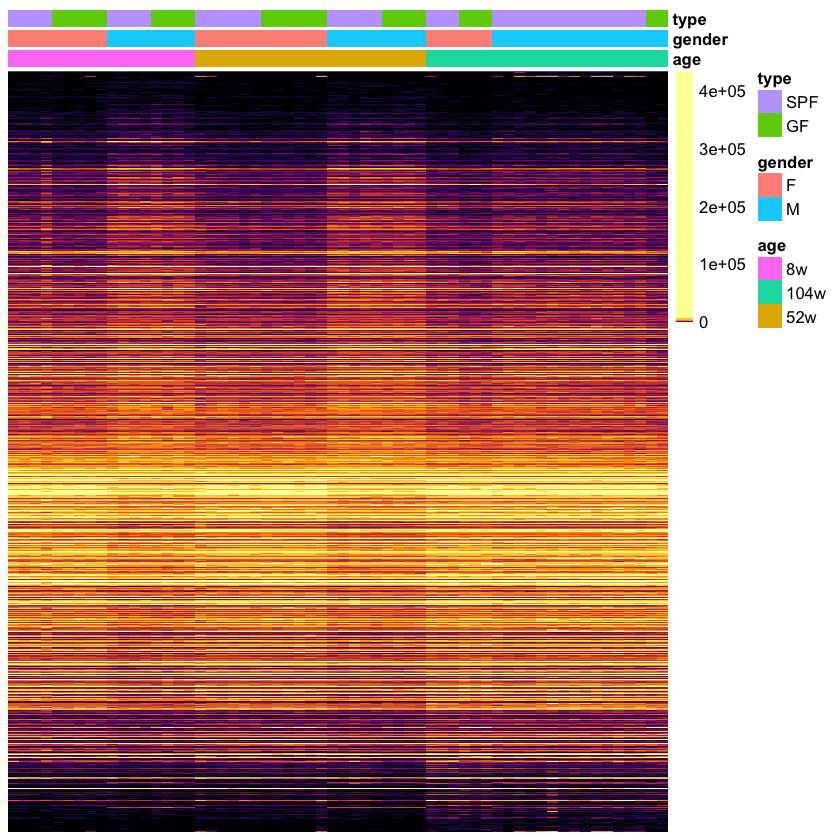

In [381]:
# 52w == 8w and 104w != 8w and 104w != 52w with abs(FC) > 1
genes = names((sort(age_deg$fc_deg[which(is.na(age_deg$fc_deg[,1]) & abs(age_deg$fc_deg[,2])>0 & abs(age_deg$fc_deg[,3])>0),2])))
plot_count_heatmap(genes,samples, annot)

Warning message in heatmap.2(fc, Colv = NA, scale = "column", cexCol = 0.5, symbreaks = T):
“Discrepancy: Colv is FALSE, while dendrogram is `both'. Omitting column dendogram.”

52w > 8w & 104w > 8w & 104w > 52w 52w > 8w & 104w > 8w & 104w < 52w
[1,] 189                               6                                
     52w > 8w & 104w < 8w & 104w > 52w 52w > 8w & 104w < 8w & 104w < 52w
[1,] 0                                 7                                
     52w < 8w & 104w > 8w & 104w > 52w 52w < 8w & 104w > 8w & 104w < 52w
[1,] 15                                0                                
     52w < 8w & 104w < 8w & 104w > 52w 52w < 8w & 104w < 8w & 104w < 52w
[1,] 6                                 46

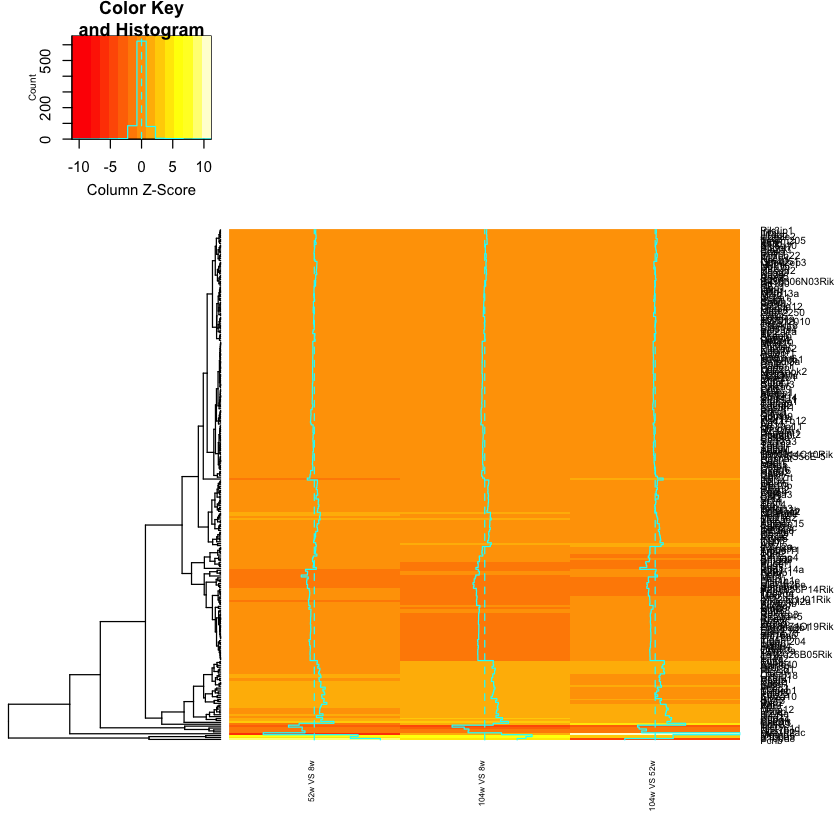

In [382]:
# Genes that are differentially expressed in 52W vs 8W, in 104W vs 8W and in 104W vs 52W
fc = age_deg$fc_deg[!is.na(age_deg$fc_deg[,1]) & !is.na(age_deg$fc_deg[,2]) & !is.na(age_deg$fc_deg[,3]),c(1,2,3)]
heatmap.2(fc, Colv = NA, scale="column", cexCol=0.5, symbreaks=T)
rep = get_repartition_3col(fc)
colnames(rep) = c(
    "52w > 8w & 104w > 8w & 104w > 52w",
    "52w > 8w & 104w > 8w & 104w < 52w",
    "52w > 8w & 104w < 8w & 104w > 52w",
    "52w > 8w & 104w < 8w & 104w < 52w",
    "52w < 8w & 104w > 8w & 104w > 52w",
    "52w < 8w & 104w > 8w & 104w < 52w",
    "52w < 8w & 104w < 8w & 104w > 52w",
    "52w < 8w & 104w < 8w & 104w < 52w")
rep

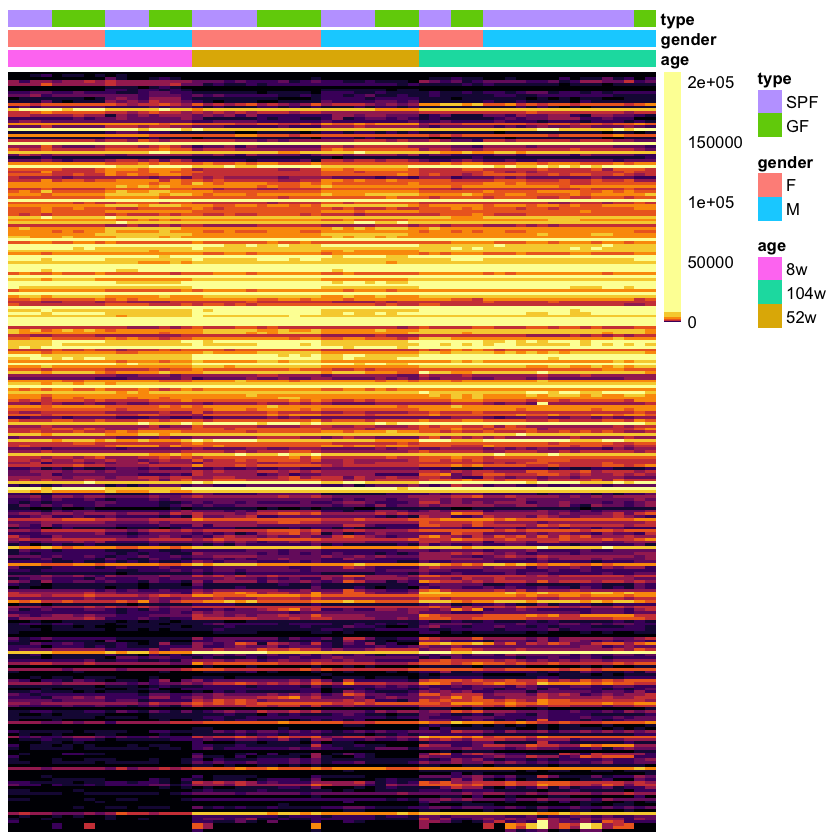

In [383]:
# 52w != 8w and 104w != 8w and 104w != 52w with abs(FC) > 1
genes = names((sort(age_deg$fc_deg[which(abs(age_deg$fc_deg[,1])>0 & abs(age_deg$fc_deg[,2])>0 & abs(age_deg$fc_deg[,3])>0),1])))
plot_count_heatmap(genes,samples, annot)

## Comparison between the ages for the types (after controlling for gender)

Questions

- What are the differences between the ages for the different types
- Do we observe the same changes as globally?

In [384]:
age_type_data = list(SPF_52w_8w, GF_52w_8w, SPF_104w_8w, GF_104w_8w, SPF_104w_52w, GF_104w_52w)
names(age_type_data) = c("52w VS 8w (SPF)", "52w VS 8w (GF)", "104w VS 8w (SPF)", "104w VS 8w (GF)", "104w VS 52w (SPF)", "104w VS 52w (GF)")
age_type_deg = extract_diff_expr_genes(age_type_data, "age_type_data")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

In [385]:
SPF_samples = c(
    'SPF_8w_F_1_2','SPF_8w_F_3_2','SPF_8w_F_4_2','SPF_8w_F_5_2','SPF_8w_M_1_2','SPF_8w_M_2_2','SPF_8w_M_3_2','SPF_8w_M_4_2',
    'SPF_52w_F_1_2','SPF_52w_F_2_2','SPF_52w_F_3_2','SPF_52w_F_4_2','SPF_52w_F_5_2','SPF_52w_F_6_2','SPF_52w_M_1_2','SPF_52w_M_2_2','SPF_52w_M_3_2','SPF_52w_M_4_2','SPF_52w_M_5_2',
    'SPF_104w_F_1_2','SPF_104w_F_2_2','SPF_104w_F_3_2','SPF_104w_M_1_2','SPF_104w_M_2_2','SPF_104w_M_3_2','SPF_104w_M_4_2','SPF_104w_M_5_2','SPF_104w_M_6_2','SPF_104w_M_7_2','SPF_104w_M_8_2','SPF_104w_M_9_2','SPF_104w_M_10_2','SPF_104w_M_11_2','SPF_104w_M_12_2','SPF_104w_M_13_2','SPF_104w_M_14_2')
GF_samples = c(
    'GF_8w_F_1_2','GF_8w_F_2_2','GF_8w_F_3_2','GF_8w_F_4_2','GF_8w_F_5_2','GF_8w_M_1_2','GF_8w_M_2_2','GF_8w_M_3_2','GF_8w_M_4_2',
    'GF_52w_F_1_2','GF_52w_F_2_2','GF_52w_F_3_2','GF_52w_F_4_2','GF_52w_F_5_2','GF_52w_F_6_2','GF_52w_M_1_2','GF_52w_M_2_2','GF_52w_M_3_2','GF_52w_M_4_2',
    'GF_104w_F_1_2','GF_104w_F_2_2','GF_104w_F_3_2','GF_104w_M_1_2','GF_104w_M_2_2')
annot = as.data.frame(colData(dge)[, c("age", "gender")])

### Counts

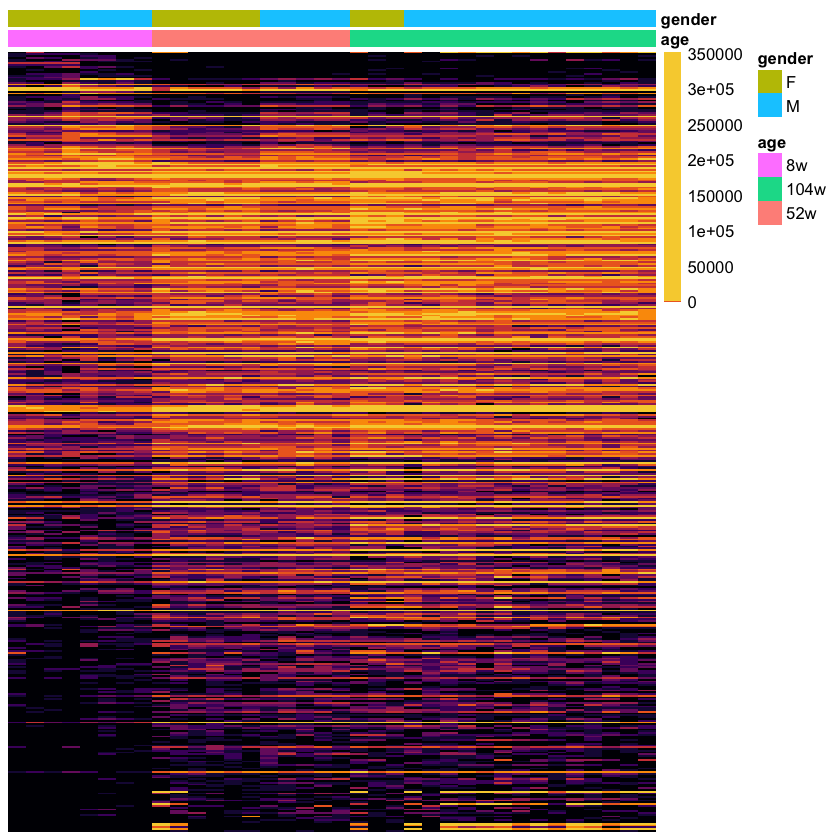

In [386]:
# 52w != 8w or 104w != 8w or 104w != 52w for SPF with abs(FC) > 2
genes = names((sort(age_type_deg$fc_deg[which(abs(age_type_deg$fc_deg[,1])>1 | abs(age_type_deg$fc_deg[,3])>1 | abs(age_type_deg$fc_deg[,5])>1),1])))
plot_count_heatmap(genes,SPF_samples, annot)

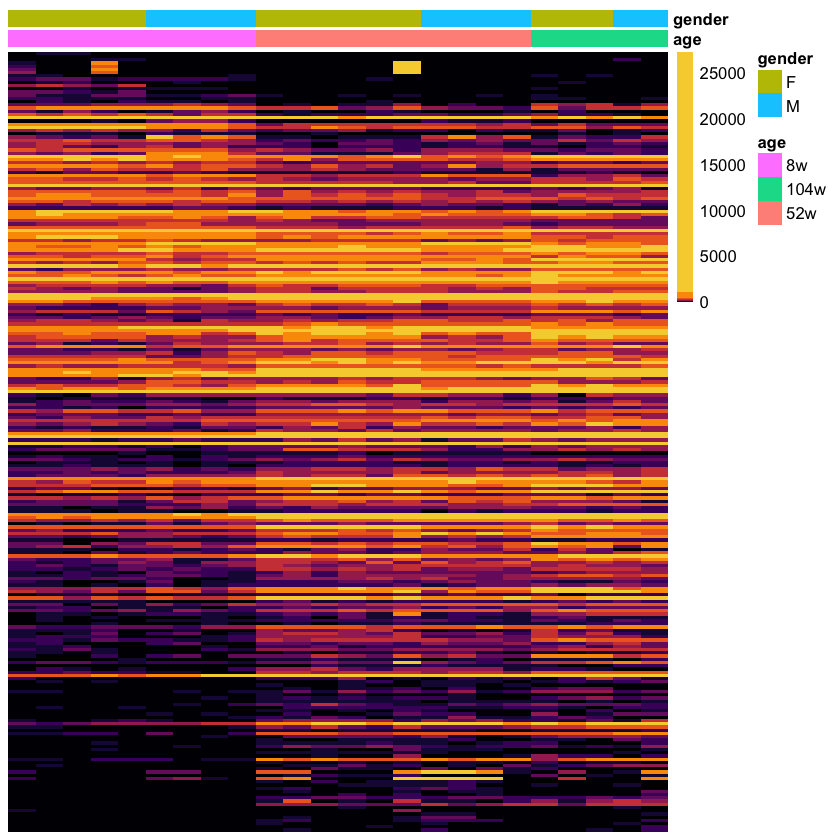

In [387]:
# 52w != 8w or 104w != 8w or 104w != 52w for GF with abs(FC) > 2
genes = names((sort(age_type_deg$fc_deg[which(abs(age_type_deg$fc_deg[,2])>1 | abs(age_type_deg$fc_deg[,4])>1 | abs(age_type_deg$fc_deg[,6])>1),2])))
plot_count_heatmap(genes,GF_samples, annot)

### Comparison of the numbers per types

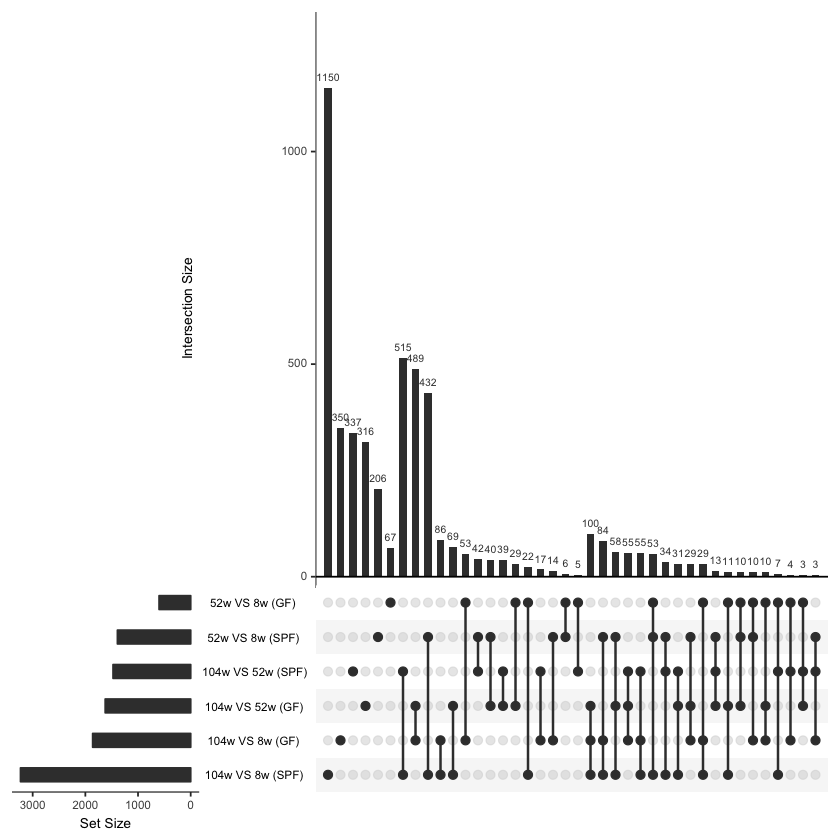

In [388]:
# Differentially expressed genes
upset(as.data.frame(age_type_deg$deg),nsets = 6)

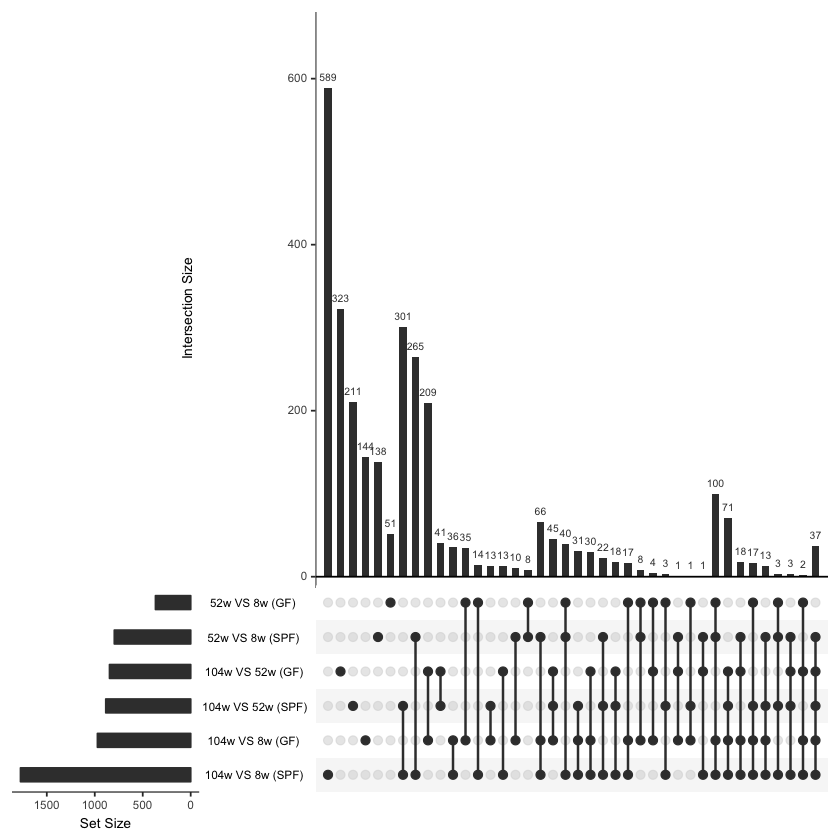

In [389]:
# Differentially more expressed genes
upset(as.data.frame(age_type_deg$pos),nsets = 6)

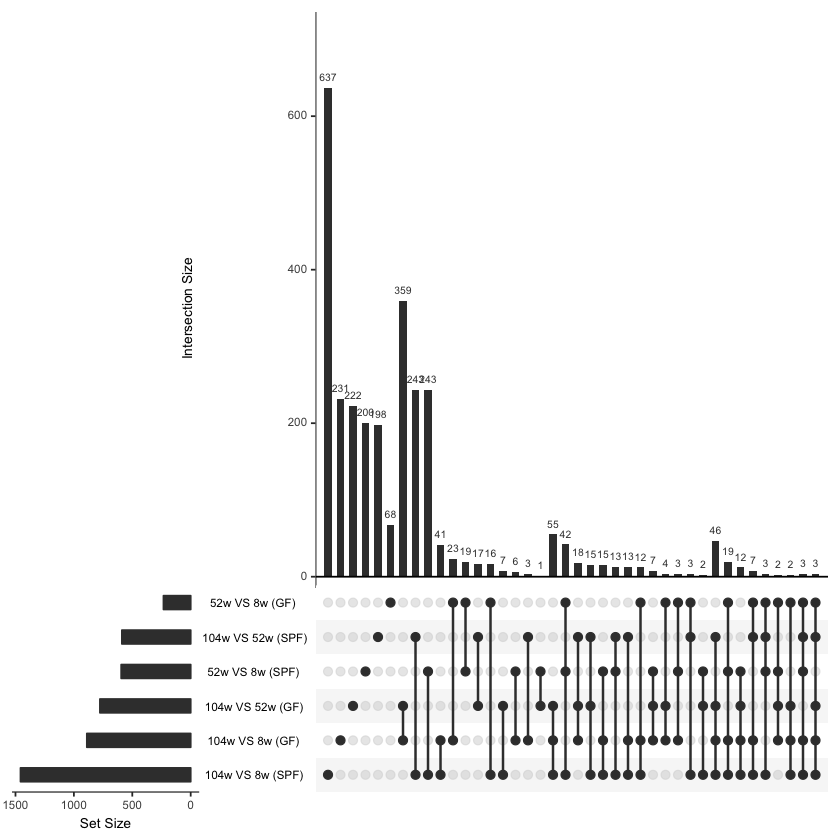

In [390]:
# Differentially less expressed genes
upset(as.data.frame(age_type_deg$neg),nsets = 6)

### Comparison with the global numbers

#### 52w vs 8w

In [391]:
# 52w vs 8w
type_data_52w_8w = list(SPF_52w_8w, GF_52w_8w, global_52w_8w)
names(type_data_52w_8w) = c("52w VS 8w (SPF)", "52w VS 8w (GF)", "52w VS 8w (global)")
type_deg_52w_8w = extract_diff_expr_genes(type_data_52w_8w, "type_data_52w_8w")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

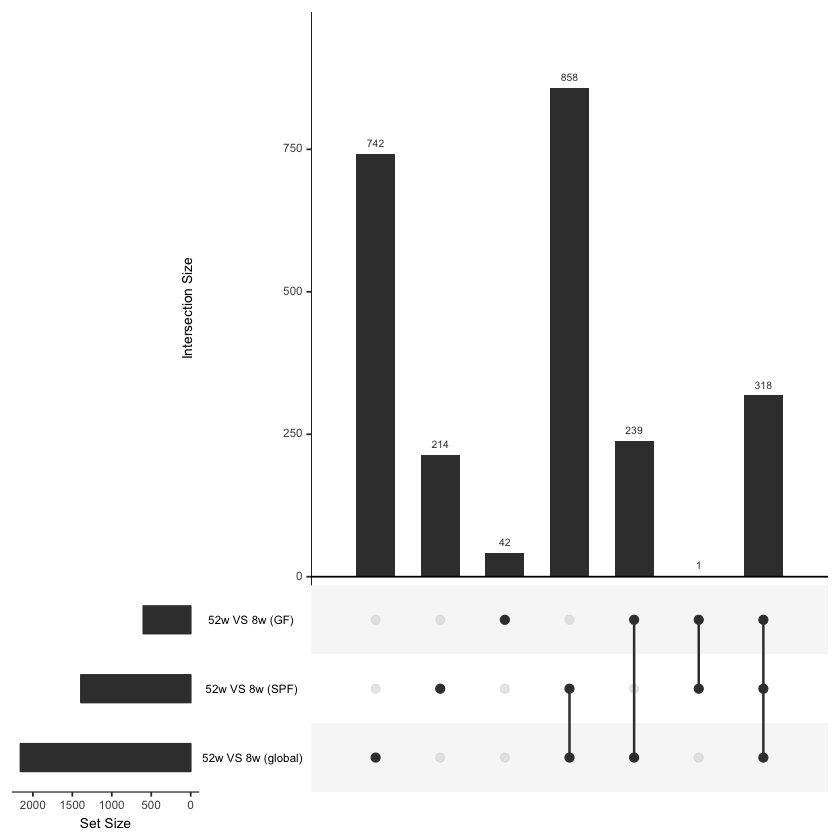

In [392]:
# Differentially expressed genes
upset(as.data.frame(type_deg_52w_8w$deg))

#### 104w vs 8w

In [393]:
type_data_104w_8w = list(SPF_104w_8w, GF_104w_8w, global_104w_8w)
names(type_data_104w_8w) = c("104w VS 8w (SPF)", "104w VS 8w (GF)", "104w VS 8w (global)")
type_deg_104w_8w = extract_diff_expr_genes(type_data_104w_8w, "type_data_104w_8w")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

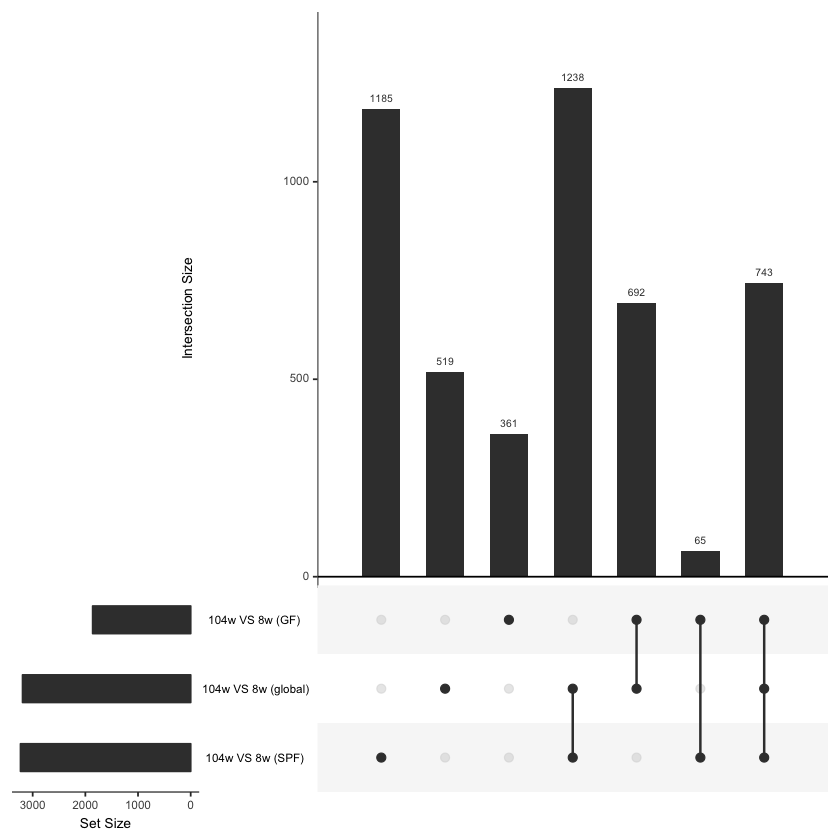

In [394]:
# Differentially expressed genes
upset(as.data.frame(type_deg_104w_8w$deg))

#### 104w vs 52w

In [395]:
type_data_104w_52w = list(SPF_104w_52w, GF_104w_52w, global_104w_52w)
names(type_data_104w_52w) = c("104w VS 52w (SPF)", "104w VS 52w (GF)", "104w VS 52w (global)")
type_deg_104w_52w = extract_diff_expr_genes(type_data_104w_52w, "type_data_104w_52w")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

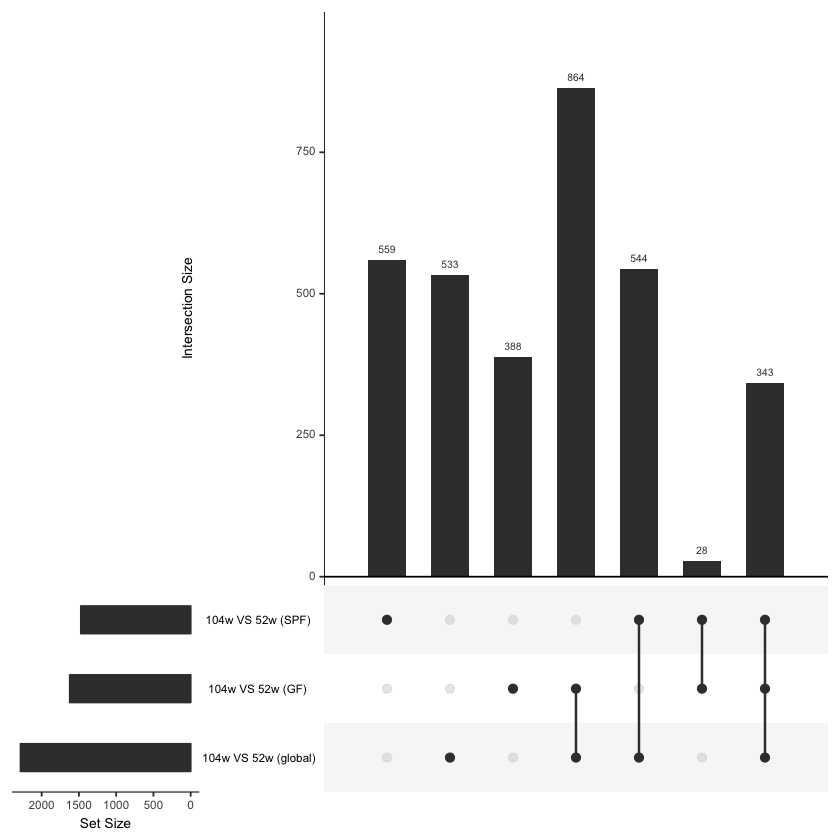

In [396]:
# Differentially expressed genes
upset(as.data.frame(type_deg_104w_52w$deg))

## Comparison between the ages for the genders (after controlling for type)

Questions

- What are the differences between the ages for the different genders?
- Do we observe the same changes as globally?

In [397]:
age_gender_data = list(F_52w_8w, M_52w_8w, F_104w_8w, M_104w_8w, F_104w_52w, M_104w_52w)
names(age_gender_data) = c("52w VS 8w (F)", "52w VS 8w (M)", "104w VS 8w (F)", "104w VS 8w (M)", "104w VS 52w (F)", "104w VS 52w (M)")
age_gender_deg = extract_diff_expr_genes(age_gender_data, "age_gender_data")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

In [398]:
M_samples = c(
    'SPF_8w_M_1_2','SPF_8w_M_2_2','SPF_8w_M_3_2','SPF_8w_M_4_2','GF_8w_M_1_2','GF_8w_M_2_2','GF_8w_M_3_2','GF_8w_M_4_2',
    'SPF_52w_M_1_2','SPF_52w_M_2_2','SPF_52w_M_3_2','SPF_52w_M_4_2','SPF_52w_M_5_2','GF_52w_M_1_2','GF_52w_M_2_2','GF_52w_M_3_2','GF_52w_M_4_2',
    'SPF_104w_M_1_2','SPF_104w_M_2_2','SPF_104w_M_3_2','SPF_104w_M_4_2','SPF_104w_M_5_2','SPF_104w_M_6_2','SPF_104w_M_7_2','SPF_104w_M_8_2','SPF_104w_M_9_2','SPF_104w_M_10_2','SPF_104w_M_11_2','SPF_104w_M_12_2','SPF_104w_M_13_2','SPF_104w_M_14_2','GF_104w_M_1_2','GF_104w_M_2_2')
F_samples = c(
    'SPF_8w_F_1_2','SPF_8w_F_3_2','SPF_8w_F_4_2','SPF_8w_F_5_2','GF_8w_F_1_2','GF_8w_F_2_2','GF_8w_F_3_2','GF_8w_F_4_2','GF_8w_F_5_2',
    'SPF_52w_F_1_2','SPF_52w_F_2_2','SPF_52w_F_3_2','SPF_52w_F_4_2','SPF_52w_F_5_2','SPF_52w_F_6_2','GF_52w_F_1_2','GF_52w_F_2_2','GF_52w_F_3_2','GF_52w_F_4_2','GF_52w_F_5_2','GF_52w_F_6_2',
    'SPF_104w_F_1_2','SPF_104w_F_2_2','SPF_104w_F_3_2','GF_104w_F_1_2','GF_104w_F_2_2','GF_104w_F_3_2')
annot = as.data.frame(colData(dge)[, c("age", "type")])

### Counts

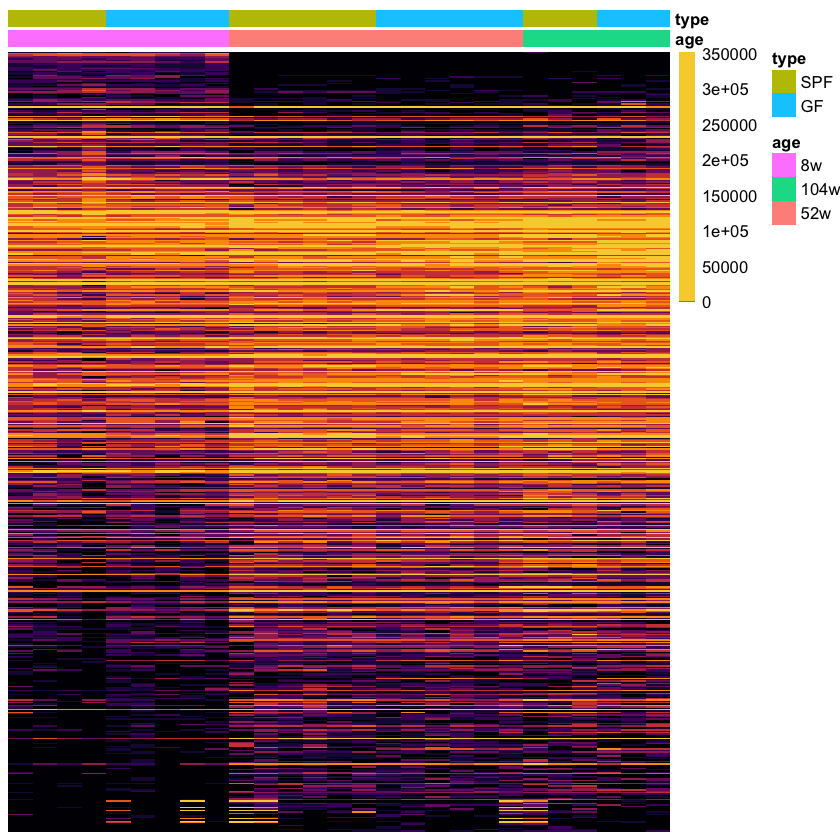

In [399]:
# 52w != 8w or 104w != 8w or 104w != 52w for F with abs(FC) > 2
genes = names((sort(age_gender_deg$fc_deg[which(abs(age_gender_deg$fc_deg[,1])>1 | abs(age_gender_deg$fc_deg[,3])>1 | abs(age_gender_deg$fc_deg[,5])>1),1])))
plot_count_heatmap(genes,F_samples, annot)

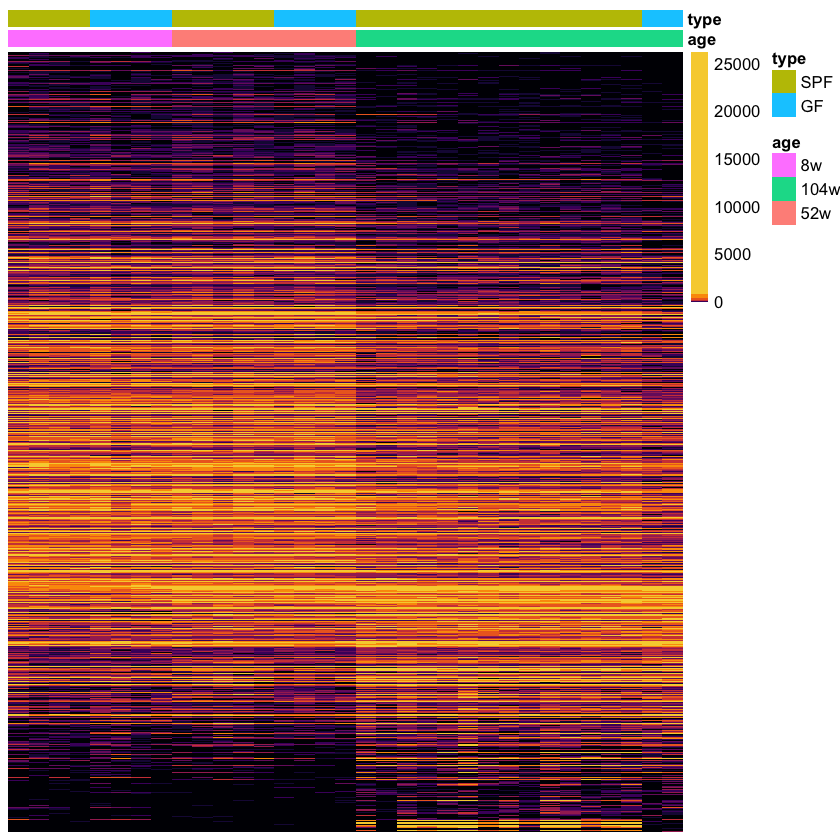

In [400]:
# 52w != 8w or 104w != 8w or 104w != 52w for M with abs(FC) > 2
genes = names((sort(age_gender_deg$fc_deg[which(abs(age_gender_deg$fc_deg[,2])>1 | abs(age_gender_deg$fc_deg[,4])>1 | abs(age_gender_deg$fc_deg[,6])>1),6])))
plot_count_heatmap(genes,M_samples, annot)

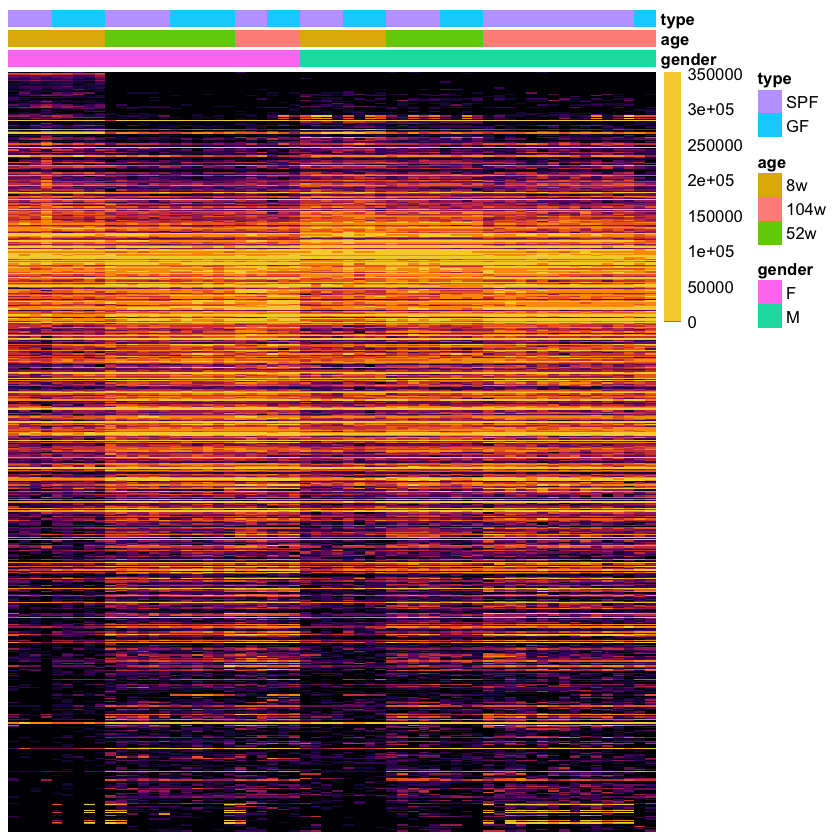

In [401]:
# Genes with sign FC and at least one FC > 2
genes = names((sort(age_gender_deg$fc_deg[which(abs(age_gender_deg$fc_deg[,1])>1|abs(age_gender_deg$fc_deg[,2])>1|abs(age_gender_deg$fc_deg[,3])>1|abs(age_gender_deg$fc_deg[,4])>1|abs(age_gender_deg$fc_deg[,5])>1|abs(age_gender_deg$fc_deg[,6])>1),1])))
samples = c(
    'SPF_8w_F_1_2','SPF_8w_F_3_2','SPF_8w_F_4_2','SPF_8w_F_5_2','GF_8w_F_1_2','GF_8w_F_2_2','GF_8w_F_3_2','GF_8w_F_4_2','GF_8w_F_5_2',
    'SPF_52w_F_1_2','SPF_52w_F_2_2','SPF_52w_F_3_2','SPF_52w_F_4_2','SPF_52w_F_5_2','SPF_52w_F_6_2','GF_52w_F_1_2','GF_52w_F_2_2','GF_52w_F_3_2','GF_52w_F_4_2','GF_52w_F_5_2','GF_52w_F_6_2',
    'SPF_104w_F_1_2','SPF_104w_F_2_2','SPF_104w_F_3_2','GF_104w_F_1_2','GF_104w_F_2_2','GF_104w_F_3_2',
    'SPF_8w_M_1_2','SPF_8w_M_2_2','SPF_8w_M_3_2','SPF_8w_M_4_2','GF_8w_M_1_2','GF_8w_M_2_2','GF_8w_M_3_2','GF_8w_M_4_2',
    'SPF_52w_M_1_2','SPF_52w_M_2_2','SPF_52w_M_3_2','SPF_52w_M_4_2','SPF_52w_M_5_2','GF_52w_M_1_2','GF_52w_M_2_2','GF_52w_M_3_2','GF_52w_M_4_2',
    'SPF_104w_M_1_2','SPF_104w_M_2_2','SPF_104w_M_3_2','SPF_104w_M_4_2','SPF_104w_M_5_2','SPF_104w_M_6_2','SPF_104w_M_7_2','SPF_104w_M_8_2','SPF_104w_M_9_2','SPF_104w_M_10_2','SPF_104w_M_11_2','SPF_104w_M_12_2','SPF_104w_M_13_2','SPF_104w_M_14_2','GF_104w_M_1_2','GF_104w_M_2_2')
annot = as.data.frame(colData(dge)[, c("gender", "age", "type")])
plot_count_heatmap(genes,samples, annot)

### Comparison of the numbers per types

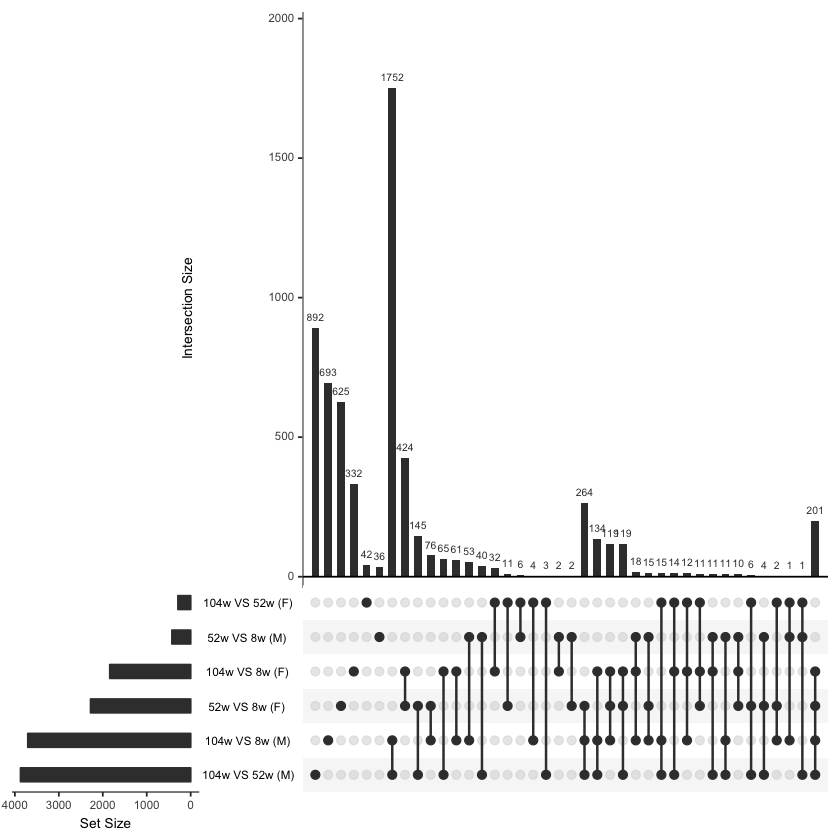

In [402]:
# Differentially expressed genes
upset(as.data.frame(age_gender_deg$deg),nsets = 6)

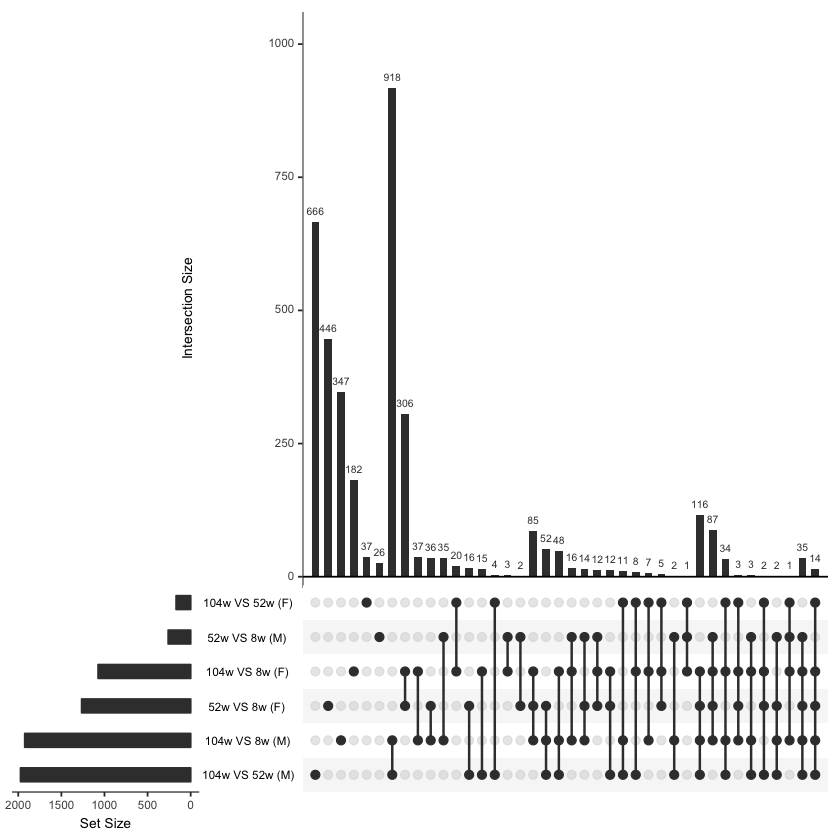

In [403]:
# Differentially more expressed genes
upset(as.data.frame(age_gender_deg$pos),nsets = 6)

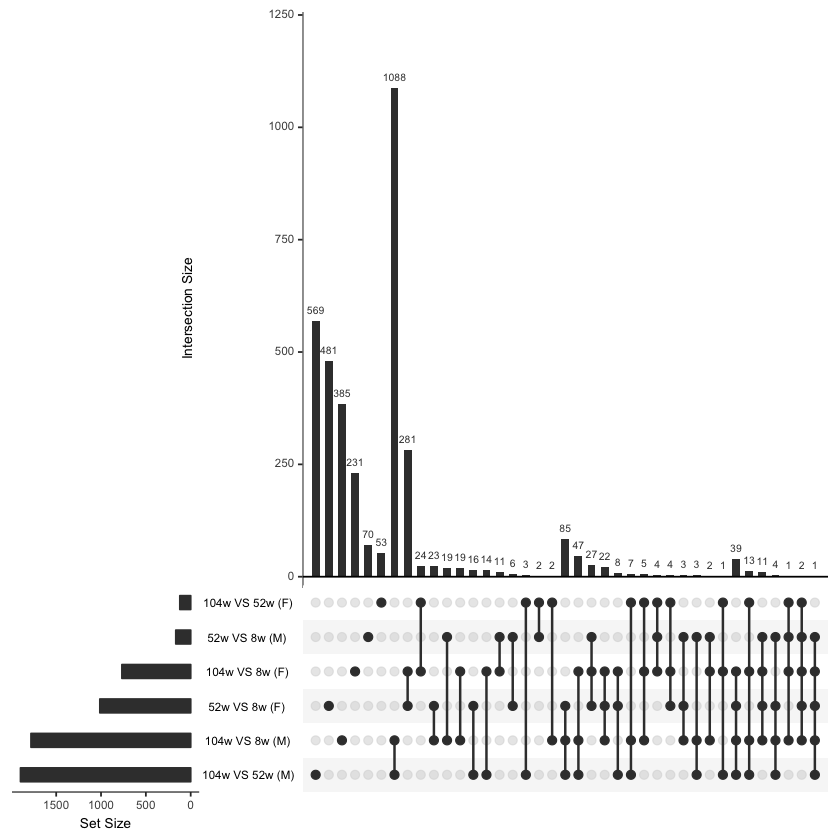

In [404]:
# Differentially less expressed genes
upset(as.data.frame(age_gender_deg$neg),nsets = 6)

### Comparison with the global numbers

#### 52w vs 8w

In [405]:
gender_data_52w_8w = list(F_52w_8w, M_52w_8w, global_52w_8w)
names(gender_data_52w_8w) = c("52w VS 8w (F)", "52w VS 8w (M)", "52w VS 8w (global)")
gender_deg_52w_8w = extract_diff_expr_genes(gender_data_52w_8w, "gender_data_52w_8w")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

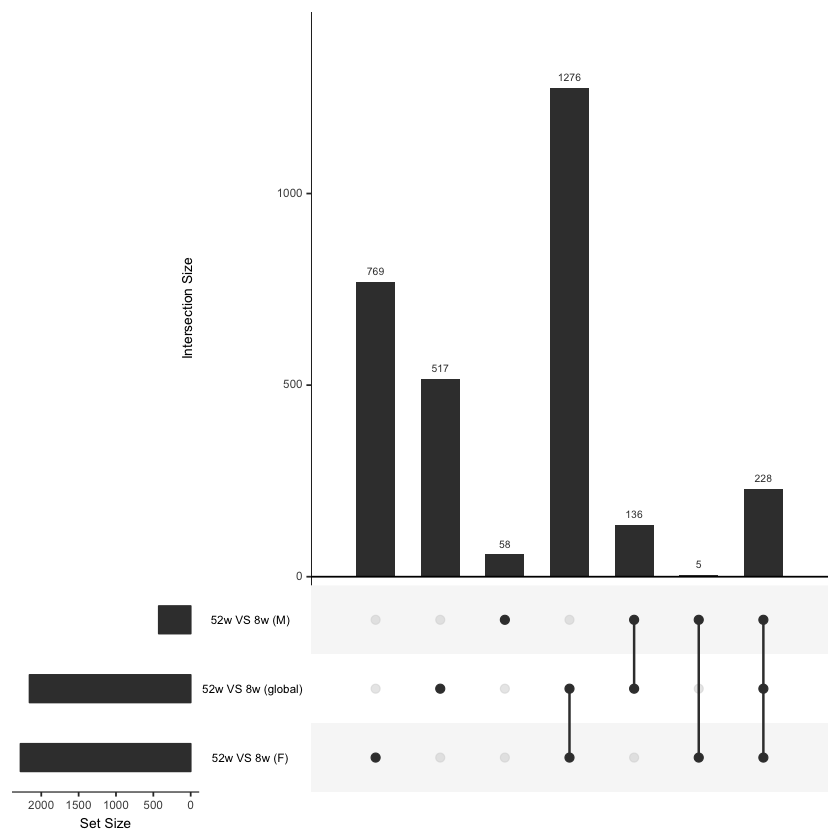

In [406]:
upset(as.data.frame(gender_deg_52w_8w$deg))

#### 104w vs 8w

In [407]:
gender_data_104w_8w = list(F_104w_8w, M_104w_8w, global_104w_8w)
names(gender_data_104w_8w) = c("104w VS 8w (F)", "104w VS 8w (M)", "104w VS 8w (global)")
gender_deg_104w_8w = extract_diff_expr_genes(gender_data_104w_8w, "gender_data_104w_8w")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

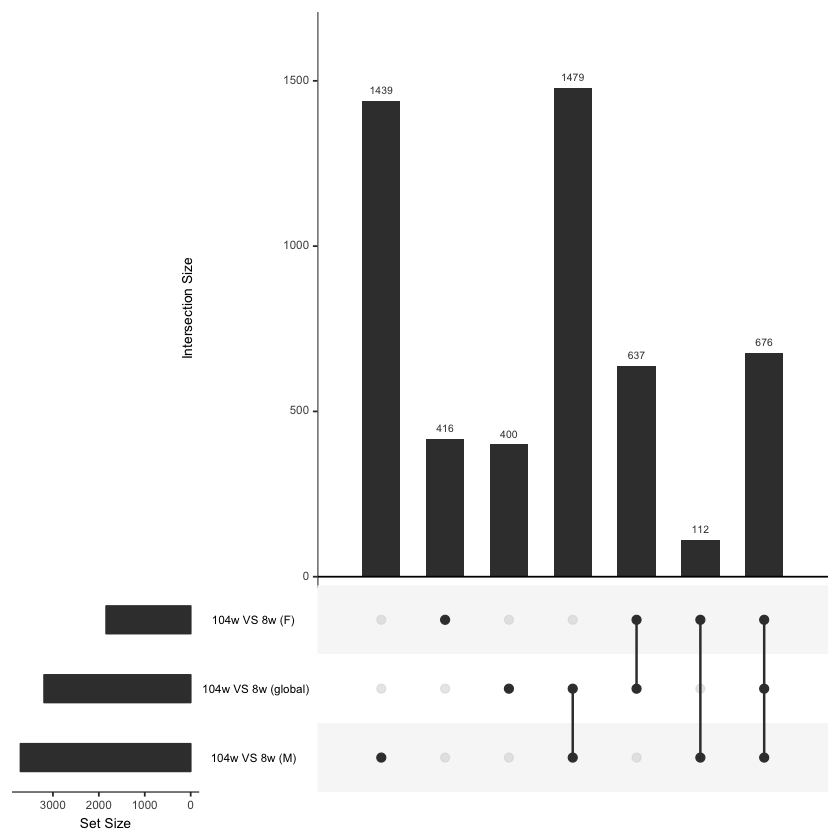

In [408]:
upset(as.data.frame(gender_deg_104w_8w$deg))

In [409]:
genes = names(sort(abs(gender_deg_104w_8w$fc_deg[!is.na(gender_deg_104w_8w$fc_deg[,3]),3]), decreasing = T))[1:100]
gender_deg_104w_8w$fc_deg[genes,]

104w VS 8w (F) 104w VS 8w (M) 104w VS 8w (global)
Ace        28.316850      11.158078      19.737464         
Fam83d     23.177619      13.690420      18.434019         
Fam46b      8.780089      25.935234      17.357661         
Thbd              NA      22.662136      17.313977         
Ptprh     -24.482399      -7.792089     -16.137244         
Lcn2              NA      28.231014      14.125808         
Spx        20.225898             NA      14.068553         
Mpo       -20.664031             NA     -13.285639         
S100a9            NA      25.053228      13.036027         
Cpxm1     -25.013995             NA     -11.844774         
S100a8      8.268813      14.719515      11.494164         
Efna2             NA      18.875486      10.828098         
Fcnb              NA      24.151533       9.279579         
Gprc5c    -18.511190             NA      -9.276583         
Clic6       9.290797       9.102811       9.196804         
Gm19434           NA     -11.943688      -9.085170         
Creb3l4     9.456775       8.513257       8.985016         
Nol4              NA             NA      -8.789062         
Steap1     17.237238             NA       8.650762         
Nwd1       13.331650             NA       8.585411         
Camp        9.219476       6.278933       7.749204         
Car12      16.173890             NA       7.425113         
Tfec       -7.496135      -6.870025      -7.183080         
Slc7a3    -22.097686       7.765446      -7.166120         
Cxcl13      4.380788       9.780436       7.080612         
Acod1       7.247512       5.007514       6.127513         
Dlg5        5.020678       6.815868       5.918273         
Aspm        5.847653       5.691449       5.769551         
Tspan6      5.541402       5.850263       5.695833         
Cspg4       5.621711       5.516614       5.569162         
⋮         ⋮              ⋮              ⋮                  
Flt1       4.362536       4.171683       4.267109          
Dqx1      -4.499066      -4.014940      -4.257003          
Asb4             NA      -6.137639      -4.242135          
Ptpn7            NA       4.885443       4.239239          
Colec12    6.375160             NA       4.230118          
Trpc4            NA       4.594971       4.225972          
Klrb1a           NA       4.579860       4.218375          
Kif23      7.743825             NA       4.216458          
AI593442         NA       4.639972       4.207266          
Gfap       3.023746       5.389154       4.206450          
Ehf              NA       5.880743       4.189053          
Ngp       -5.609540             NA      -4.167946          
Scel             NA      -4.900161      -4.159350          
Itgal      5.104960             NA       4.158340          
Dtl              NA       5.019777       4.135570          
Ifi213     4.003500       4.261856       4.132678          
Slamf7     6.215169             NA       4.124057          
Hist1h1d         NA      -6.644381      -4.116713          
Mndal            NA             NA       4.112854          
Pianp      3.922419       4.255513       4.088966          
Etl4       3.384663       4.764495       4.074579          
Perm1            NA      -4.662096      -4.070928          
Cxcr4      4.067845       4.017569       4.042707          
Hist1h2ad        NA      -6.778885      -4.022706          
Rbp3      -7.730885             NA      -4.008119          
Ifi205           NA       5.720527       3.993424          
H2-Aa      3.245531       4.700606       3.973069          
Ccl8       4.005157       3.854056       3.929606          
Spp1       4.411033       3.423311       3.917172          
Prph2     -7.319575             NA      -3.913176

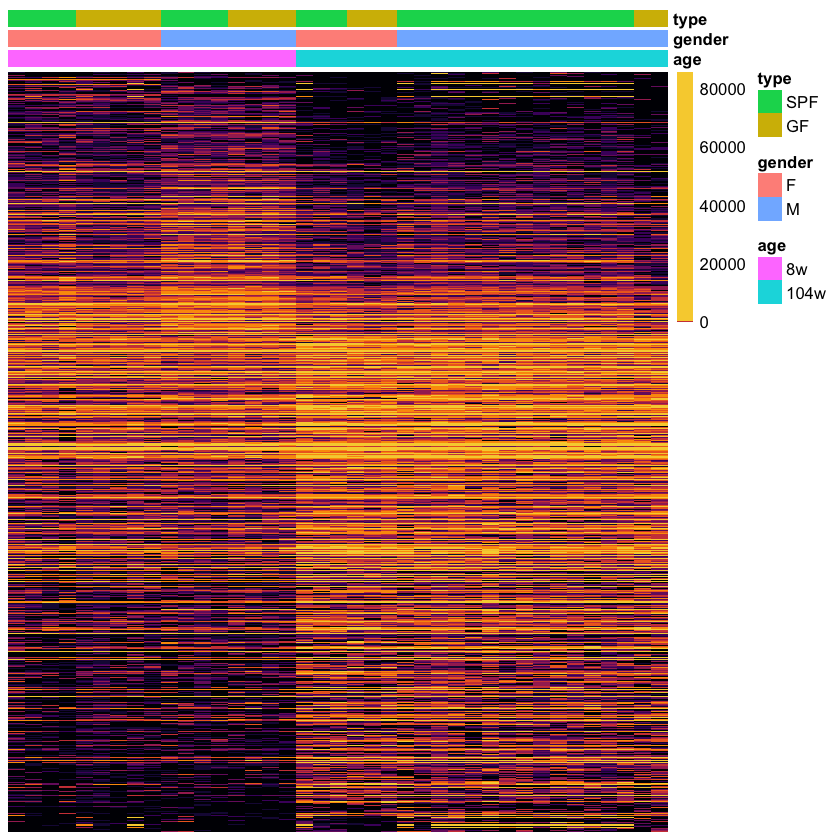

In [410]:
samples = c(
    'SPF_8w_F_1_2','SPF_8w_F_3_2','SPF_8w_F_4_2','SPF_8w_F_5_2','GF_8w_F_1_2','GF_8w_F_2_2','GF_8w_F_3_2','GF_8w_F_4_2','GF_8w_F_5_2','SPF_8w_M_1_2','SPF_8w_M_2_2','SPF_8w_M_3_2','SPF_8w_M_4_2','GF_8w_M_1_2','GF_8w_M_2_2','GF_8w_M_3_2','GF_8w_M_4_2',
    'SPF_104w_F_1_2','SPF_104w_F_2_2','SPF_104w_F_3_2','GF_104w_F_1_2','GF_104w_F_2_2','GF_104w_F_3_2','SPF_104w_M_1_2','SPF_104w_M_2_2','SPF_104w_M_3_2','SPF_104w_M_4_2','SPF_104w_M_5_2','SPF_104w_M_6_2','SPF_104w_M_7_2','SPF_104w_M_8_2','SPF_104w_M_9_2','SPF_104w_M_10_2','SPF_104w_M_11_2','SPF_104w_M_12_2','SPF_104w_M_13_2','SPF_104w_M_14_2','GF_104w_M_1_2','GF_104w_M_2_2')
annot = as.data.frame(colData(dge)[, c("age", "gender", "type")])
genes = names((sort(gender_deg_104w_8w$fc_deg[which(abs(gender_deg_104w_8w$fc_deg[,3])>1),3])))
plot_count_heatmap(genes,samples, annot)

#### 104w vs 52w

In [411]:
gender_data_104w_52w = list(F_104w_52w, M_104w_52w, global_104w_52w)
names(gender_data_104w_52w) = c("104w VS 52w (F)", "104w VS 52w (M)", "104w VS 52w (global)")
gender_deg_104w_52w = extract_diff_expr_genes(gender_data_104w_52w, "gender_data_104w_52w")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

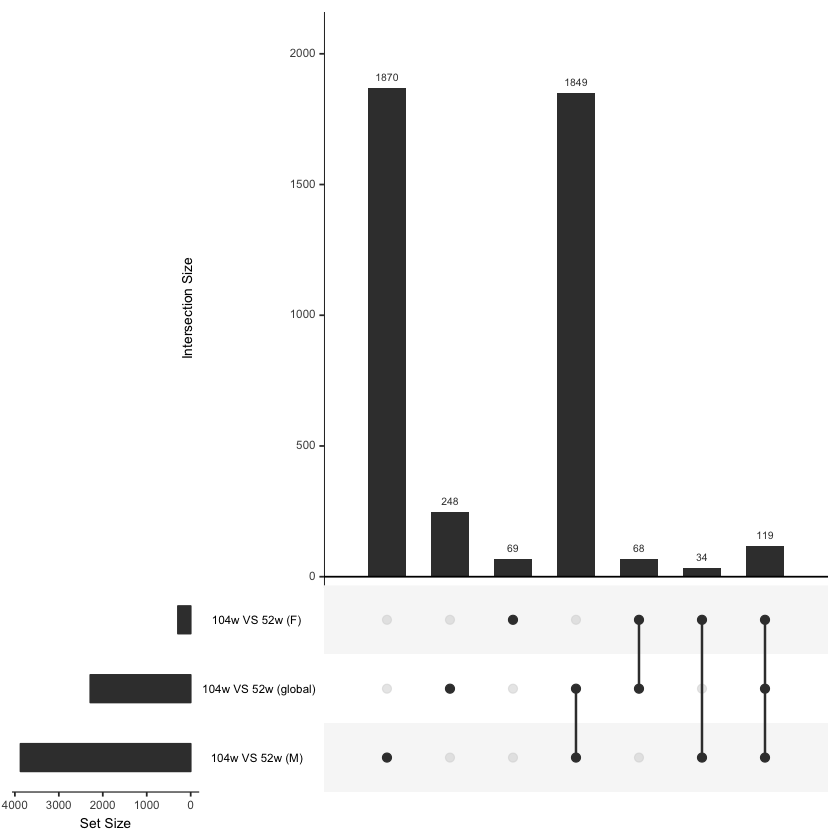

In [412]:
upset(as.data.frame(gender_deg_104w_52w$deg))

In [413]:
genes = names(sort(abs(gender_deg_104w_52w$fc_deg[!is.na(gender_deg_104w_52w$fc_deg[,3]),3]), decreasing = T))[1:100]
gender_deg_104w_52w$fc_deg[genes,]

104w VS 52w (F) 104w VS 52w (M) 104w VS 52w (global)
Mpo           -32.466502             NA       -19.300843          
Zdbf2                 NA      25.806077        18.623117          
Ptprh         -24.701392      -7.764654       -16.233023          
Lcn2           -9.443309      40.863914        15.710302          
Mgarp          22.641027       7.656353        15.148690          
Gprc5c        -19.029731             NA        -9.887987          
Cpxm1         -30.156721      11.222933        -9.466894          
Slc7a3        -24.528575       7.809724        -8.359426          
Hp            -17.408351             NA        -6.608719          
Colec12               NA       7.644700         5.792738          
Cd163                 NA       8.597315         5.747360          
Trpc4           5.634561       4.654521         5.144541          
Myof                  NA       6.178011         5.032183          
Cd177         -12.633059      22.681278         5.024109          
Fcnb          -13.346335             NA        -4.689992          
Lyve1                 NA       6.277093         4.657326          
Gabrq                 NA       8.386822         4.653328          
Ngp           -12.166856             NA        -4.578808          
Tmem51                NA             NA         4.485433          
Klrb1a                NA             NA         4.331843          
Cacnb3                NA             NA        -4.331486          
Etl4                  NA       5.440361         4.231621          
Vnn3                  NA             NA         4.196021          
Slc4a4                NA             NA        -4.109942          
Cd38                  NA       5.989201         4.060415          
Ccl8                  NA       6.991850         4.042293          
Ociad2         -5.666878             NA        -4.016859          
Ermn                  NA             NA        -3.973427          
Perm1                 NA             NA        -3.702784          
Emilin2               NA       4.512721         3.691419          
⋮             ⋮               ⋮               ⋮                   
Gpx3           2.918923        2.627645        2.773284           
Dnase1l2             NA       -2.635453       -2.758708           
Mmp12          2.961412        2.542841        2.752127           
Ccr9                 NA              NA       -2.711297           
Il1rn                NA        3.308367        2.707633           
Runx3                NA              NA        2.694542           
Igf2r                NA        3.472564        2.679905           
Ms4a7                NA        3.759291        2.672158           
Adamts4              NA              NA       -2.669079           
Efhd1                NA              NA       -2.661411           
Tbc1d2               NA       -3.389780       -2.657572           
Zfp786               NA       -3.811090       -2.639888           
Gas7                 NA        4.123348        2.634732           
Guca1b               NA       -3.288956       -2.587378           
C3                   NA        3.403919        2.583153           
Cxcl13               NA        4.248634        2.555157           
Sh3pxd2b             NA        2.654750        2.554039           
Slc1a2               NA              NA       -2.552760           
Hist1h3a             NA       -4.952422       -2.544987           
Snord47              NA       -3.993222       -2.506268           
Olfr99               NA       -3.778552       -2.490215           
Tfec          -4.028360              NA       -2.487742           
Alb                  NA              NA       -2.471989           
Flt1           2.713159        2.225854        2.469506           
Pianp          2.598864        2.303987        2.451425           
5033403F01Rik        NA              NA       -2.449571           
Gper1         -4.757286              NA       -2.425611           
Ttc26                NA              NA       -2.404059      

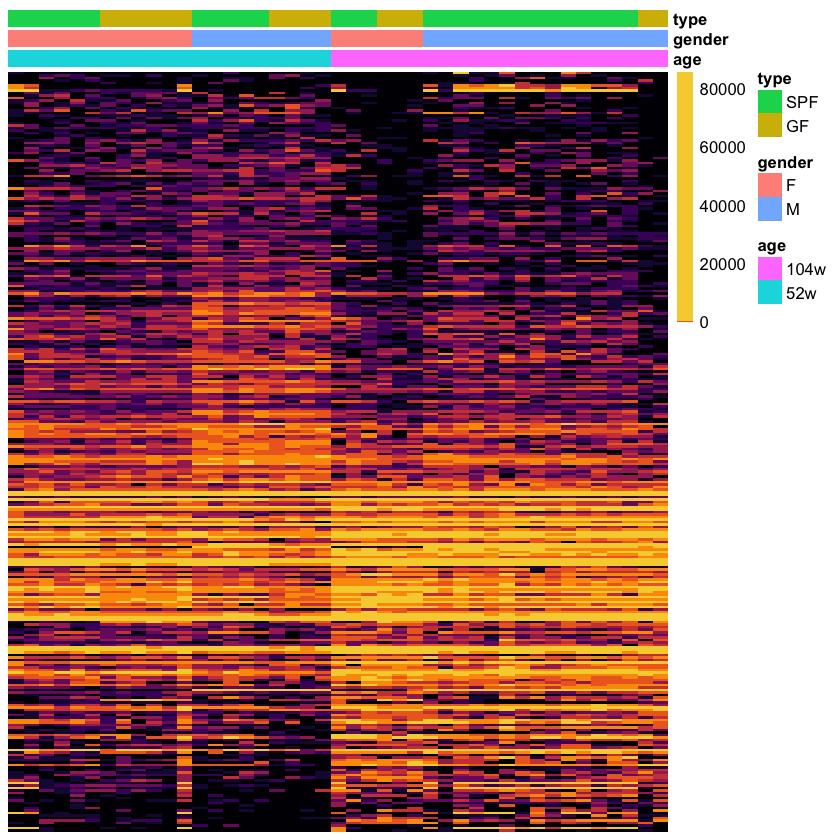

In [414]:
samples = c(
    'SPF_52w_F_1_2','SPF_52w_F_2_2','SPF_52w_F_3_2','SPF_52w_F_4_2','SPF_52w_F_5_2','SPF_52w_F_6_2','GF_52w_F_1_2','GF_52w_F_2_2','GF_52w_F_3_2','GF_52w_F_4_2','GF_52w_F_5_2','GF_52w_F_6_2','SPF_52w_M_1_2','SPF_52w_M_2_2','SPF_52w_M_3_2','SPF_52w_M_4_2','SPF_52w_M_5_2','GF_52w_M_1_2','GF_52w_M_2_2','GF_52w_M_3_2','GF_52w_M_4_2',
    'SPF_104w_F_1_2','SPF_104w_F_2_2','SPF_104w_F_3_2','GF_104w_F_1_2','GF_104w_F_2_2','GF_104w_F_3_2','SPF_104w_M_1_2','SPF_104w_M_2_2','SPF_104w_M_3_2','SPF_104w_M_4_2','SPF_104w_M_5_2','SPF_104w_M_6_2','SPF_104w_M_7_2','SPF_104w_M_8_2','SPF_104w_M_9_2','SPF_104w_M_10_2','SPF_104w_M_11_2','SPF_104w_M_12_2','SPF_104w_M_13_2','SPF_104w_M_14_2','GF_104w_M_1_2','GF_104w_M_2_2')
annot = as.data.frame(colData(dge)[, c("age", "gender", "type")])
genes = names((sort(gender_deg_104w_52w$fc_deg[which(abs(gender_deg_104w_52w$fc_deg[,3])>1),3])))
plot_count_heatmap(genes,samples, annot)

## Comparison between the ages for the genders and types

Questions
- What are the differences between the ages for the different combinations of gender and types?
- Do we observe the same changes as globally?

In [415]:
age_type_gender_data = list(F_SPF_52w_8w, F_GF_52w_8w, M_SPF_52w_8w, M_GF_52w_8w,F_SPF_104w_8w,F_GF_104w_8w,M_SPF_104w_8w,M_GF_104w_8w,F_SPF_104w_52w,F_GF_104w_52w,M_SPF_104w_52w,M_GF_104w_52w)
names(age_type_gender_data) = c("52w VS 8w (F, SPF)", "52w VS 8w (F, GF)", "52w VS 8w (M, SPF)", "52w VS 8w (M, GF)", "104w VS 8w (F, SPF)", "104w VS 8w (F, GF)", "104w VS 8w (M, SPF)", "104w VS 8w (M, GF)","104w VS 52w (F, SPF)", "104w VS 52w (F, GF)","104w VS 52w (M, SPF)", "104w VS 52w (M, GF)")
age_type_gender_deg = extract_diff_expr_genes(age_type_gender_data, "age_type_gender_data")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Fetching GO annotations...
For 2874 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Fetching GO annotations...
For 17944 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...
Fetching GO annotations...
For 17944 genes, we could not find any categories. These genes will be excluded.
To force their use, please run with use_genes_without_cat=TRUE (see documentation).
This was the default behavior for version 1.15.1 and earlier.
Calculating the p-values...
Fetching GO a

### Comparison of the numbers per types

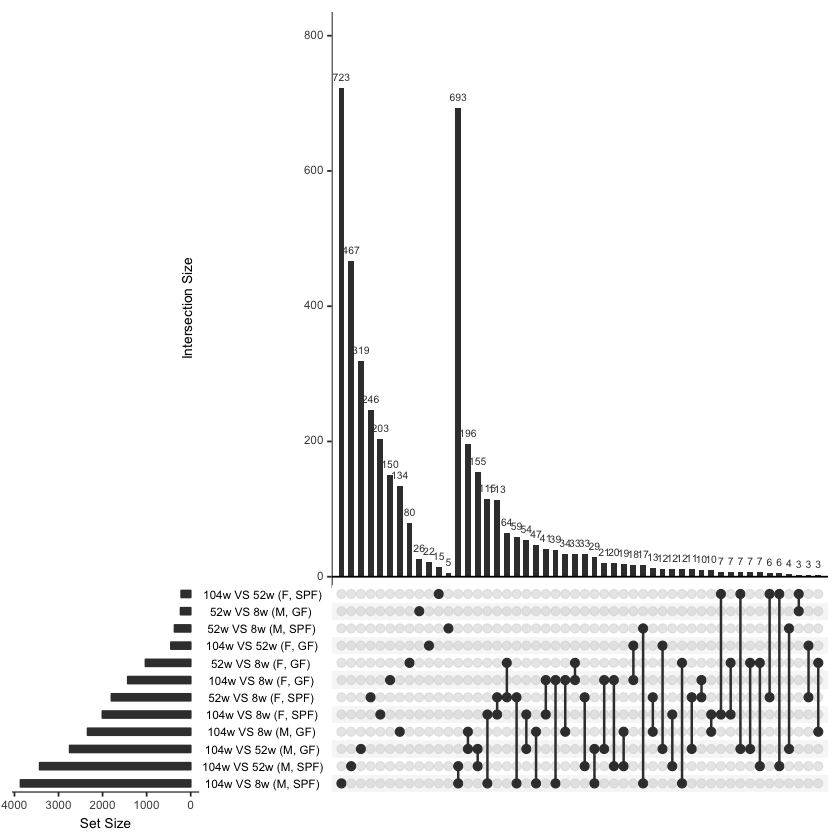

In [416]:
upset(as.data.frame(age_type_gender_deg$deg), nsets = 12, nintersects=50)

### Comparison with the global numbers

#### 52w vs 8w

In [417]:
gender_type_data_52w_8w = list(F_SPF_52w_8w, F_GF_52w_8w, M_SPF_52w_8w, M_GF_52w_8w, global_52w_8w)
names(gender_type_data_52w_8w) = c("52w VS 8w (F, SPF)", "52w VS 8w (F, GF)", "52w VS 8w (M, SPF)", "52w VS 8w (M, GF)", "52w VS 8w (global)")
gender_type_deg_52w_8w = extract_diff_expr_genes(gender_type_data_52w_8w, "gender_type_data_52w_8w")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

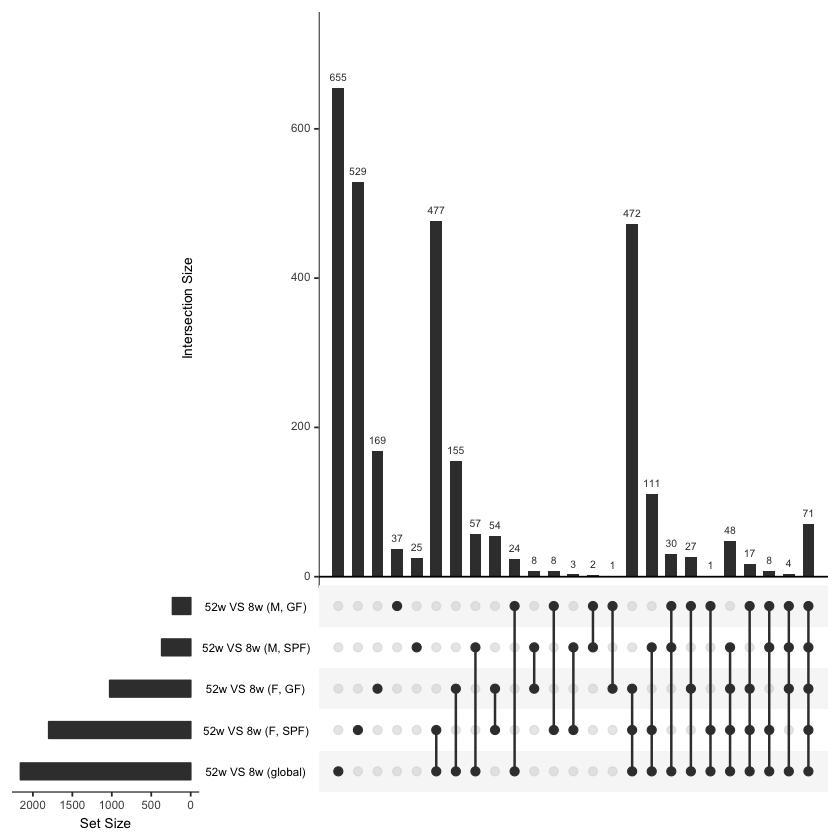

In [418]:
upset(as.data.frame(gender_type_deg_52w_8w$deg))

#### 104w vs 8w

In [419]:
gender_type_data_104w_8w = list(F_SPF_104w_8w, F_GF_104w_8w, M_SPF_104w_8w, M_GF_104w_8w, global_104w_8w)
names(gender_type_data_104w_8w) = c("104w VS 8w (F, SPF)", "104w VS 8w (F, GF)", "104w VS 8w (M, SPF)", "104w VS 8w (M, GF)", "104w VS 8w (global)")
gender_type_deg_104w_8w = extract_diff_expr_genes(gender_type_data_104w_8w, "gender_type_data_104w_8w")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

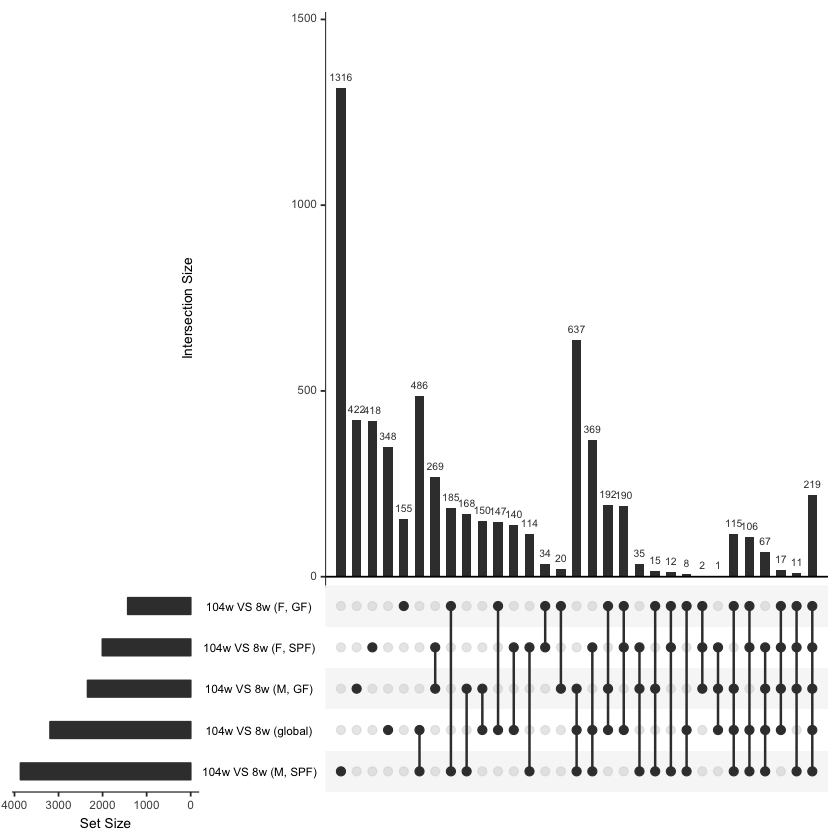

In [420]:
upset(as.data.frame(gender_type_deg_104w_8w$deg))

#### 104w vs 52w

In [421]:
gender_type_data_104w_52w = list(F_SPF_104w_52w, F_GF_104w_52w, M_SPF_104w_52w, M_GF_104w_52w, global_104w_52w)
names(gender_type_data_104w_52w) = c("104w VS 52w (F, SPF)", "104w VS 52w (F, GF)", "104w VS 52w (M, SPF)", "104w VS 52w (M, GF)", "104w VS 52w (global)")
gender_type_deg_104w_52w = extract_diff_expr_genes(gender_type_data_104w_52w, "gender_type_data_104w_52w")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

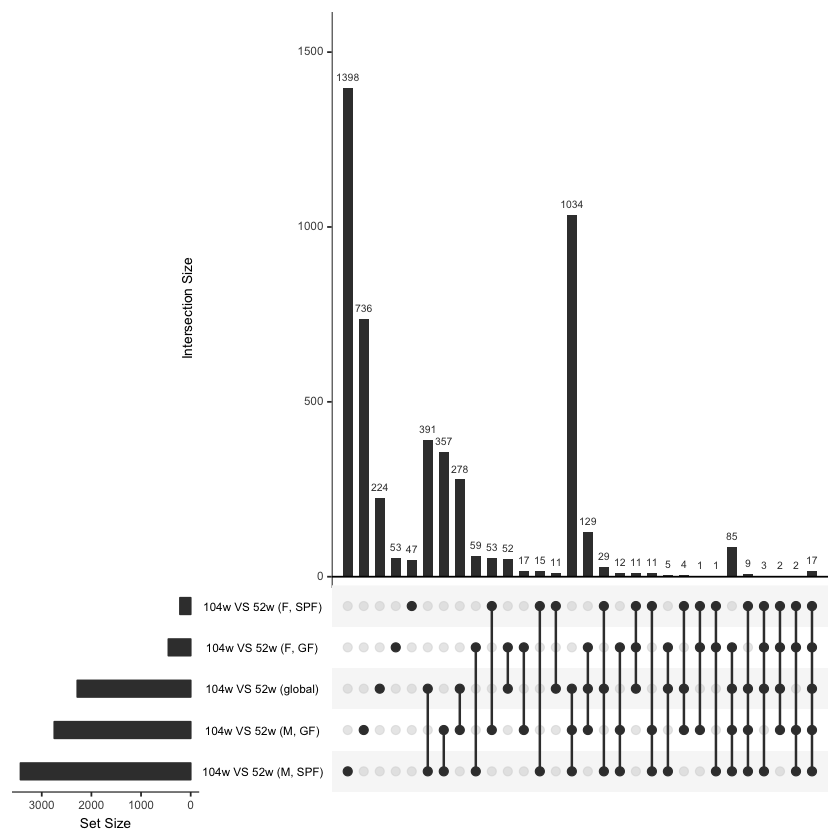

In [422]:
upset(as.data.frame(gender_type_deg_104w_52w$deg))

# Gender effect

Questions

- What are the differences between the 2 genders?
- Are they different for the 3 ages?
- Are they different for the two types?

## Global stats

In [423]:
# Comparison between the genders (after controlling for age and gender)
M_F = results(dge,contrast= c(0,1,0,0,0,1/3,1/3,1/2,0,0), alpha=0.05, test="Wald")
# Stats
gender_global_stats = matrix(0, nrow=1, ncol=3)
rownames(gender_global_stats) = c("M VS F")
colnames(gender_global_stats) = c("Wald padj < 0.05", "LFC > 0 (Wald padj < 0.05)", "LFC < 0 (Wald padj < 0.05)")
gender_global_stats[1,] = get_stats_padj(M_F)
gender_global_stats

Wald padj < 0.05 LFC > 0 (Wald padj < 0.05) LFC < 0 (Wald padj < 0.05)
M VS F 20.48            10.59                      9.89

In [424]:
# Interactions between genders and ages (after controlling type)
M_F_8w = results(dge,contrast= c(0,1,0,0,0,0,0,1/2,0,0), alpha=0.05, test="Wald")
M_F_52w = results(dge,contrast= c(0,1,0,0,0,0,1,1/2,0,0), alpha=0.05, test="Wald")
M_F_104w = results(dge,contrast= c(0,1,0,0,0,1,0,1/2,0,0), alpha=0.05, test="Wald")
# Stats
gender_age_stats = matrix(0, nrow=3, ncol=3)
rownames(gender_age_stats) = c("M VS F (8w)", "M VS F (52w)", "M VS F (104w)")
colnames(gender_age_stats) = c("Wald padj < 0.05", "LFC > 0 (Wald padj < 0.05)", "LFC < 0 (Wald padj < 0.05)")
gender_age_stats[1,] = get_stats_padj(M_F_8w)
gender_age_stats[2,] = get_stats_padj(M_F_52w)
gender_age_stats[3,] = get_stats_padj(M_F_104w)
gender_age_stats

Wald padj < 0.05 LFC > 0 (Wald padj < 0.05)
M VS F (8w)   15.79             8.28                     
M VS F (52w)  20.75            10.40                     
M VS F (104w)  0.76             0.40                     
              LFC < 0 (Wald padj < 0.05)
M VS F (8w)    7.51                     
M VS F (52w)  10.35                     
M VS F (104w)  0.36

In [425]:
# Interactions between genders and types (after controlling age)
M_F_SPF = results(dge,contrast= c(0,1,0,0,0,0,0,1/2,0,0), alpha=0.05, test="Wald")
M_F_GF = results(dge,contrast= c(0,1,0,0,0,0,1,1/2,0,0), alpha=0.05, test="Wald")
# Stats
gender_type_stats = matrix(0, nrow=2, ncol=3)
rownames(gender_type_stats) = c("M VS F (SPF)", "M VS F (GF)")
colnames(gender_type_stats) = c("Wald padj < 0.05", "LFC > 0 (Wald padj < 0.05)", "LFC < 0 (Wald padj < 0.05)")
gender_type_stats[1,] = get_stats_padj(M_F_SPF)
gender_type_stats[2,] = get_stats_padj(M_F_GF)
gender_type_stats

Wald padj < 0.05 LFC > 0 (Wald padj < 0.05)
M VS F (SPF) 15.79             8.28                     
M VS F (GF)  20.75            10.40                     
             LFC < 0 (Wald padj < 0.05)
M VS F (SPF)  7.51                     
M VS F (GF)  10.35

In [426]:
# Interactions between genders, types and ages
M_F_SPF_8w = results(dge,contrast= c(0,1,0,0,0,0,0,0,0,0), alpha=0.05, test="Wald")
M_F_GF_8w = results(dge,contrast= c(0,1,0,0,0,0,0,1,0,0), alpha=0.05, test="Wald")
M_F_SPF_52w = results(dge,contrast= c(0,1,0,0,0,0,1,0,0,0), alpha=0.05, test="Wald")
M_F_GF_52w = results(dge,contrast= c(0,1,0,0,0,0,1,1,0,0), alpha=0.05, test="Wald")
M_F_SPF_104w = results(dge,contrast= c(0,1,0,0,0,1,0,0,0,0), alpha=0.05, test="Wald")
M_F_GF_104w = results(dge,contrast= c(0,1,0,0,0,1,0,1,0,0), alpha=0.05, test="Wald")
# Stats
gender_type_age_stats = matrix(0, nrow=6, ncol=3)
rownames(gender_type_age_stats) = c("M VS F (SPF, 8w)", "M VS F (GF, 8w)", "M VS F (SPF, 52w)", "M VS F (GF, 52w)", "M VS F (SPF, 104w)", "M VS F (GF, 104w)")
colnames(gender_type_age_stats) = c("Wald padj < 0.05", "LFC > 0 (Wald padj < 0.05)", "LFC < 0 (Wald padj < 0.05)")
gender_type_age_stats[1,] = get_stats_padj(M_F_SPF_8w)
gender_type_age_stats[2,] = get_stats_padj(M_F_GF_8w)
gender_type_age_stats[3,] = get_stats_padj(M_F_SPF_52w)
gender_type_age_stats[4,] = get_stats_padj(M_F_GF_52w)
gender_type_age_stats[5,] = get_stats_padj(M_F_SPF_104w)
gender_type_age_stats[6,] = get_stats_padj(M_F_GF_104w)
gender_type_age_stats

Wald padj < 0.05 LFC > 0 (Wald padj < 0.05)
M VS F (SPF, 8w)   11.88            6.23                      
M VS F (GF, 8w)    13.18            6.85                      
M VS F (SPF, 52w)  16.70            8.37                      
M VS F (GF, 52w)   16.15            8.15                      
M VS F (SPF, 104w)  1.40            0.71                      
M VS F (GF, 104w)   0.46            0.19                      
                   LFC < 0 (Wald padj < 0.05)
M VS F (SPF, 8w)   5.65                      
M VS F (GF, 8w)    6.33                      
M VS F (SPF, 52w)  8.32                      
M VS F (GF, 52w)   8.00                      
M VS F (SPF, 104w) 0.69                      
M VS F (GF, 104w)  0.27

## Comparison between the genders (after controlling for type and age)

Questions

- What are the differences between the genders?

In [427]:
gender_data = list(M_F)
names(gender_data) = c("M VS F")
sign = which(M_F$padj < 0.05)
gender_deg = M_F[sign,'log2FoldChange']
names(gender_deg) = rownames(M_F[sign,])

In [428]:
samples = c(
    'SPF_8w_F_1_2','SPF_8w_F_3_2','SPF_8w_F_4_2','SPF_8w_F_5_2','SPF_52w_F_1_2','SPF_52w_F_2_2','SPF_52w_F_3_2','SPF_52w_F_4_2','SPF_52w_F_5_2','SPF_52w_F_6_2','SPF_104w_F_1_2','SPF_104w_F_2_2','SPF_104w_F_3_2',
    'GF_8w_F_1_2','GF_8w_F_2_2','GF_8w_F_3_2','GF_8w_F_4_2','GF_8w_F_5_2','GF_52w_F_1_2','GF_52w_F_2_2','GF_52w_F_3_2','GF_52w_F_4_2','GF_52w_F_5_2','GF_52w_F_6_2','GF_104w_F_1_2','GF_104w_F_2_2','GF_104w_F_3_2',
    'SPF_8w_M_1_2','SPF_8w_M_2_2','SPF_8w_M_3_2','SPF_8w_M_4_2','SPF_52w_M_1_2','SPF_52w_M_2_2','SPF_52w_M_3_2','SPF_52w_M_4_2','SPF_52w_M_5_2','SPF_104w_M_1_2','SPF_104w_M_2_2','SPF_104w_M_3_2','SPF_104w_M_4_2','SPF_104w_M_5_2','SPF_104w_M_6_2','SPF_104w_M_7_2','SPF_104w_M_8_2','SPF_104w_M_9_2','SPF_104w_M_10_2','SPF_104w_M_11_2','SPF_104w_M_12_2','SPF_104w_M_13_2','SPF_104w_M_14_2',
    'GF_8w_M_1_2','GF_8w_M_2_2','GF_8w_M_3_2','GF_8w_M_4_2','GF_52w_M_1_2','GF_52w_M_2_2','GF_52w_M_3_2','GF_52w_M_4_2','GF_104w_M_1_2','GF_104w_M_2_2')
annot = as.data.frame(colData(dge)[, c("gender", "type", "age")])

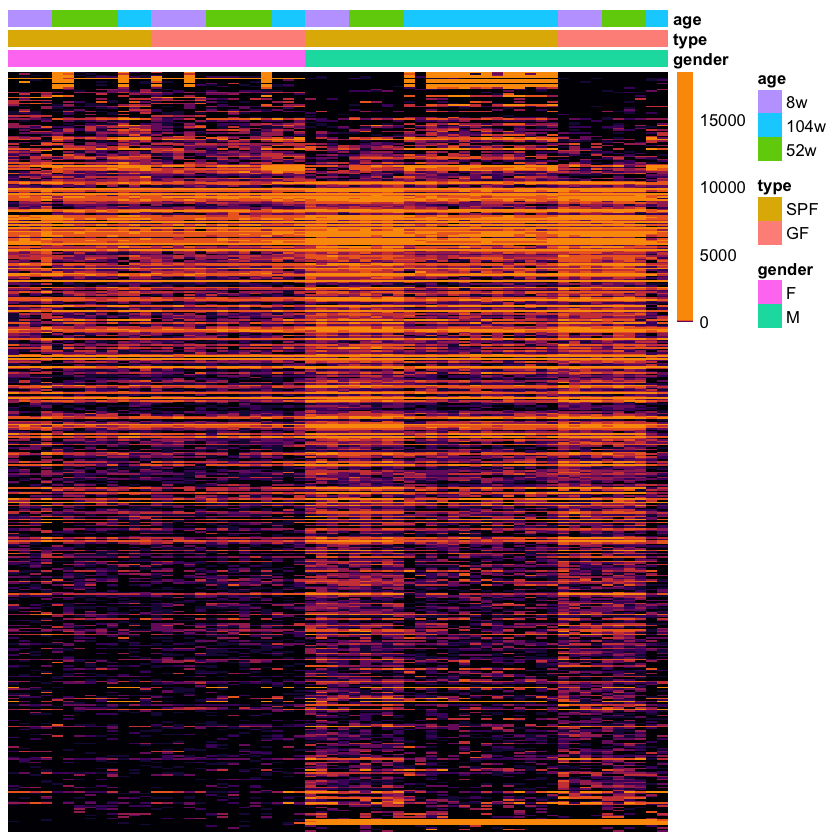

In [429]:
genes = names((sort(gender_deg[which(abs(gender_deg)>1)])))
plot_count_heatmap(genes,samples, annot)

## Comparison between the genders for the types (after controlling for age)

Questions

- What are the differences between the genders for the types?
- Do we observe the same changes as globally?

In [430]:
gender_type_data = list(M_F_SPF, M_F_GF, M_F)
names(gender_type_data) = c("M VS F (SPF)", "M VS F (GF)", "M VS F (global)")
gender_type_deg = extract_diff_expr_genes(gender_type_data, "gender_type_data")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

In [431]:
SPF_samples = c(
    'SPF_8w_F_1_2','SPF_8w_F_3_2','SPF_8w_F_4_2','SPF_8w_F_5_2','SPF_52w_F_1_2','SPF_52w_F_2_2','SPF_52w_F_3_2','SPF_52w_F_4_2','SPF_52w_F_5_2','SPF_52w_F_6_2','SPF_104w_F_1_2','SPF_104w_F_2_2','SPF_104w_F_3_2',
    'SPF_8w_M_1_2','SPF_8w_M_2_2','SPF_8w_M_3_2','SPF_8w_M_4_2','SPF_52w_M_1_2','SPF_52w_M_2_2','SPF_52w_M_3_2','SPF_52w_M_4_2','SPF_52w_M_5_2','SPF_104w_M_1_2','SPF_104w_M_2_2','SPF_104w_M_3_2','SPF_104w_M_4_2','SPF_104w_M_5_2','SPF_104w_M_6_2','SPF_104w_M_7_2','SPF_104w_M_8_2','SPF_104w_M_9_2','SPF_104w_M_10_2','SPF_104w_M_11_2','SPF_104w_M_12_2','SPF_104w_M_13_2','SPF_104w_M_14_2')
GF_samples = c(
    'GF_8w_F_1_2','GF_8w_F_2_2','GF_8w_F_3_2','GF_8w_F_4_2','GF_8w_F_5_2','GF_52w_F_1_2','GF_52w_F_2_2','GF_52w_F_3_2','GF_52w_F_4_2','GF_52w_F_5_2','GF_52w_F_6_2','GF_104w_F_1_2','GF_104w_F_2_2','GF_104w_F_3_2',
    'GF_8w_M_1_2','GF_8w_M_2_2','GF_8w_M_3_2','GF_8w_M_4_2','GF_52w_M_1_2','GF_52w_M_2_2','GF_52w_M_3_2','GF_52w_M_4_2','GF_104w_M_1_2','GF_104w_M_2_2')
annot = as.data.frame(colData(dge)[, c("gender","age")])

### Counts

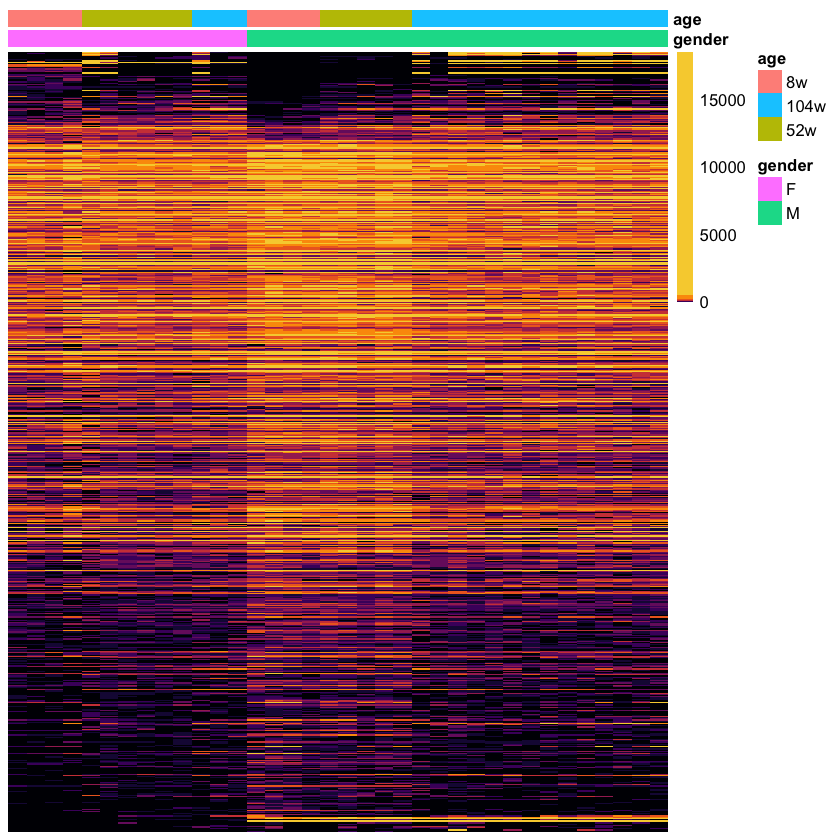

In [432]:
# M ! F for SPF with abs(FC) > 2
genes = names((sort(gender_type_deg$fc_deg[which(abs(gender_type_deg$fc_deg[,1])>1),1])))
plot_count_heatmap(genes,SPF_samples, annot)

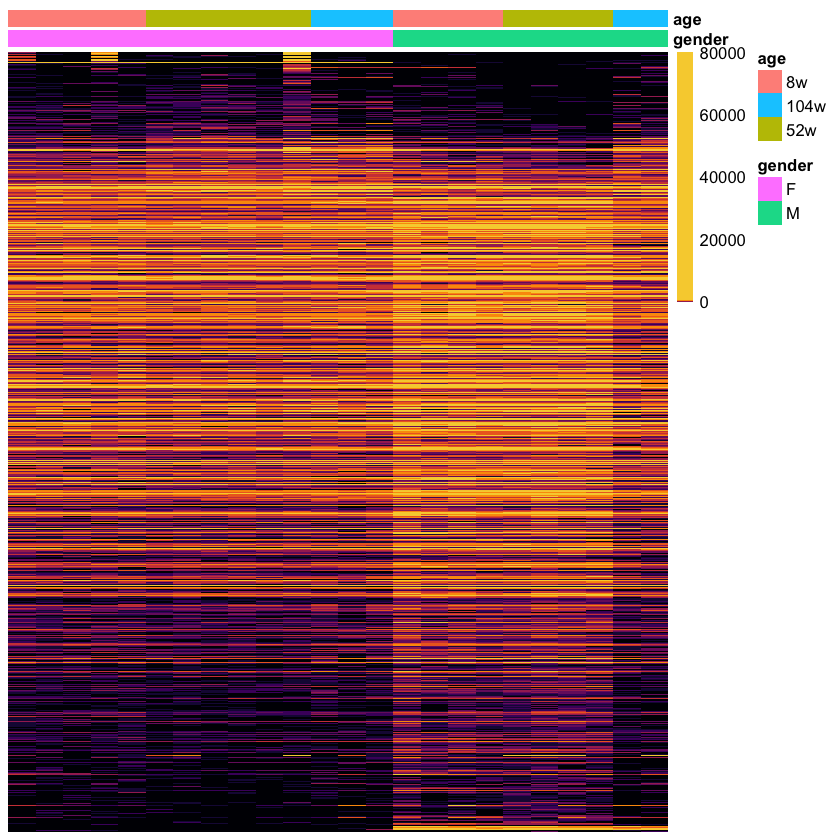

In [433]:
# M ! F for GF with abs(FC) > 2
genes = names((sort(gender_type_deg$fc_deg[which(abs(gender_type_deg$fc_deg[,2])>1),2])))
plot_count_heatmap(genes,GF_samples, annot)

### Comparison of the numbers per types


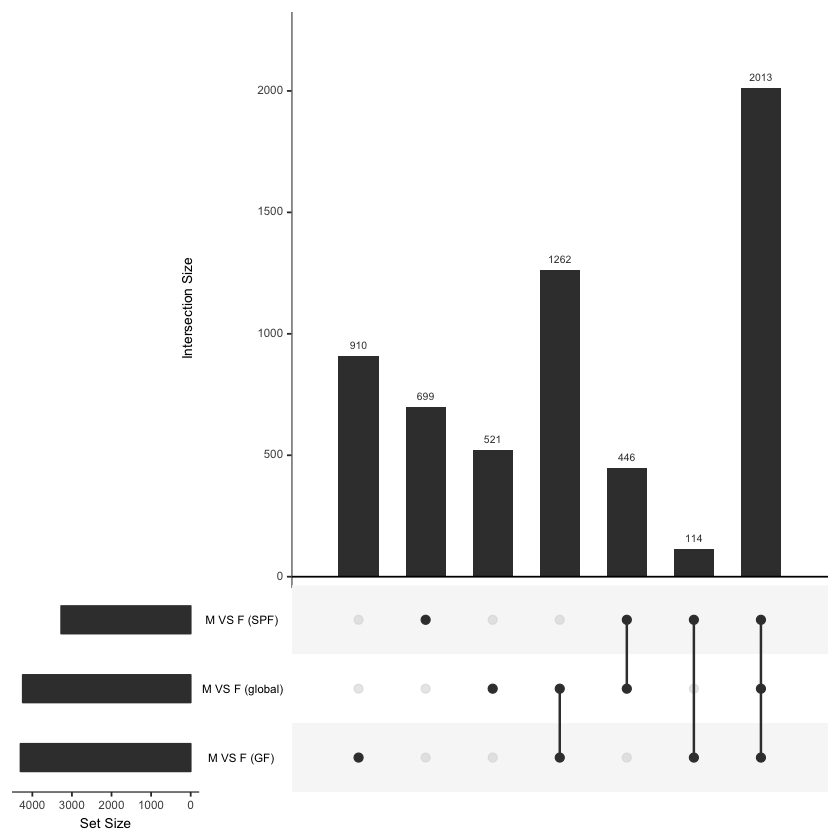

In [434]:
# Differentially expressed genes
upset(as.data.frame(gender_type_deg$deg))

## Comparison between the genders for the ages (after controlling for type)

Questions

- What are the differences between the genders for the ages?
- Do we observe the same changes as globally?

In [435]:
gender_age_data = list(M_F_8w, M_F_52w, M_F_104w, M_F)
names(gender_age_data) = c("M VS F (8w)", "M VS F (52w)", "M VS F (104w)", "M VS F (global)")
gender_age_deg = extract_diff_expr_genes(gender_age_data, "gender_age_data")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

In [436]:
w8_samples = c(
    'SPF_8w_F_1_2','SPF_8w_F_3_2','SPF_8w_F_4_2','SPF_8w_F_5_2','GF_8w_F_1_2','GF_8w_F_2_2','GF_8w_F_3_2','GF_8w_F_4_2','GF_8w_F_5_2',
    'SPF_8w_M_1_2','SPF_8w_M_2_2','SPF_8w_M_3_2','SPF_8w_M_4_2','GF_8w_M_1_2','GF_8w_M_2_2','GF_8w_M_3_2','GF_8w_M_4_2')
w52_samples = c(    
    'SPF_52w_F_1_2','SPF_52w_F_2_2','SPF_52w_F_3_2','SPF_52w_F_4_2','SPF_52w_F_5_2','SPF_52w_F_6_2','GF_52w_F_1_2','GF_52w_F_2_2','GF_52w_F_3_2','GF_52w_F_4_2','GF_52w_F_5_2','GF_52w_F_6_2',
    'SPF_52w_M_1_2','SPF_52w_M_2_2','SPF_52w_M_3_2','SPF_52w_M_4_2','SPF_52w_M_5_2','GF_52w_M_1_2','GF_52w_M_2_2','GF_52w_M_3_2','GF_52w_M_4_2')
w104_samples = c(      
    'SPF_104w_F_1_2','SPF_104w_F_2_2','SPF_104w_F_3_2','GF_104w_F_1_2','GF_104w_F_2_2','GF_104w_F_3_2',
    'SPF_104w_M_1_2','SPF_104w_M_2_2','SPF_104w_M_3_2','SPF_104w_M_4_2','SPF_104w_M_5_2','SPF_104w_M_6_2','SPF_104w_M_7_2','SPF_104w_M_8_2','SPF_104w_M_9_2','SPF_104w_M_10_2','SPF_104w_M_11_2','SPF_104w_M_12_2','SPF_104w_M_13_2','SPF_104w_M_14_2','GF_104w_M_1_2','GF_104w_M_2_2')
annot = as.data.frame(colData(dge)[, c("gender","type")])

### Counts


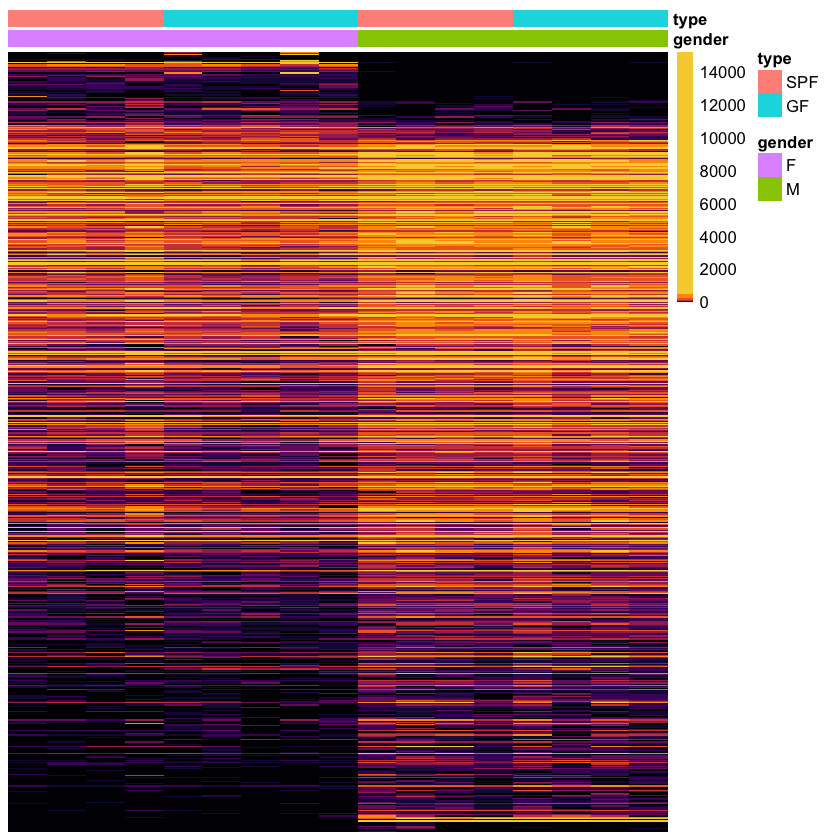

In [437]:
# M ! F for 8w with abs(FC) > 2
genes = names((sort(gender_age_deg$fc_deg[which(abs(gender_age_deg$fc_deg[,1])>1),1])))
plot_count_heatmap(genes,w8_samples, annot)

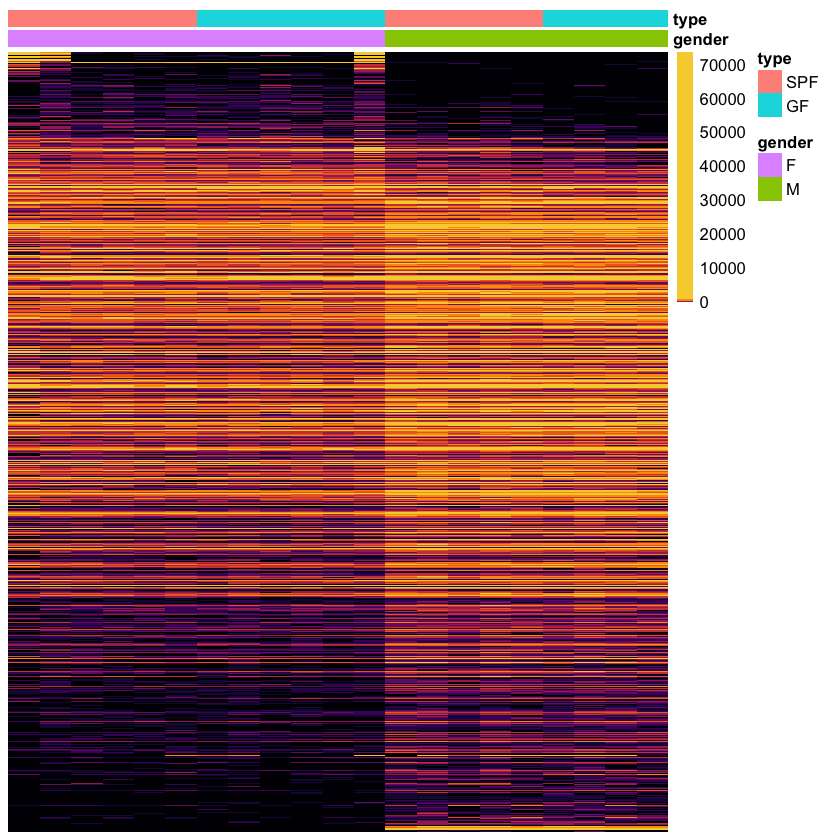

In [438]:
# M ! F for 52w with abs(FC) > 2
genes = names((sort(gender_age_deg$fc_deg[which(abs(gender_age_deg$fc_deg[,2])>1),2])))
plot_count_heatmap(genes,w52_samples, annot)

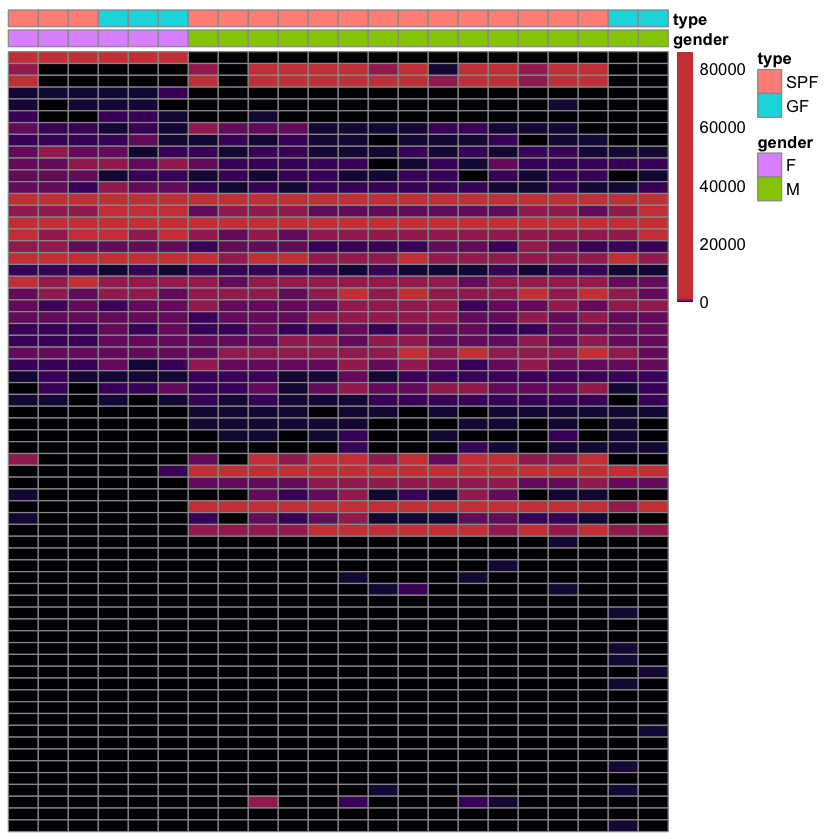

In [439]:
# M ! F for 104w with abs(FC) > 2
genes = names((sort(gender_age_deg$fc_deg[which(abs(gender_age_deg$fc_deg[,3])>1),3])))
plot_count_heatmap(genes,w104_samples, annot)

### Comparison of the numbers per types

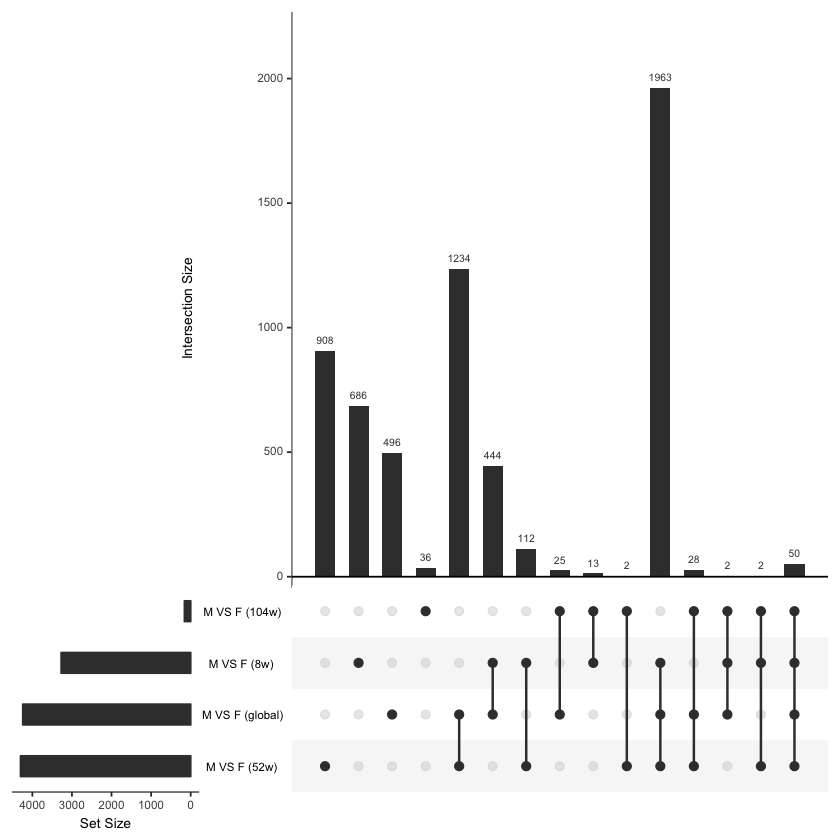

In [440]:
# Differentially expressed genes
upset(as.data.frame(gender_age_deg$deg))

## Comparison between the genders for the ages and types

Questions
- What are the differences between the gender for the different combinations of ages and types?
- Do we observe the same changes as globally?

In [441]:
gender_age_type_data = list(M_F_SPF_8w, M_F_GF_8w, M_F_SPF_52w, M_F_GF_52w, M_F_SPF_104w, M_F_GF_104w, M_F)
names(gender_age_type_data) = c("M VS F (SPF, 8w)", "M VS F (GF, 8w)", "M VS F (SPF, 52w)", "M VS F (GF, 52w)", "M VS F (SPF, 104w)", "M VS F (GF, 104w)", "M VS F (global)")
gender_age_type_deg = extract_diff_expr_genes(gender_age_type_data, "gender_age_type_data")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

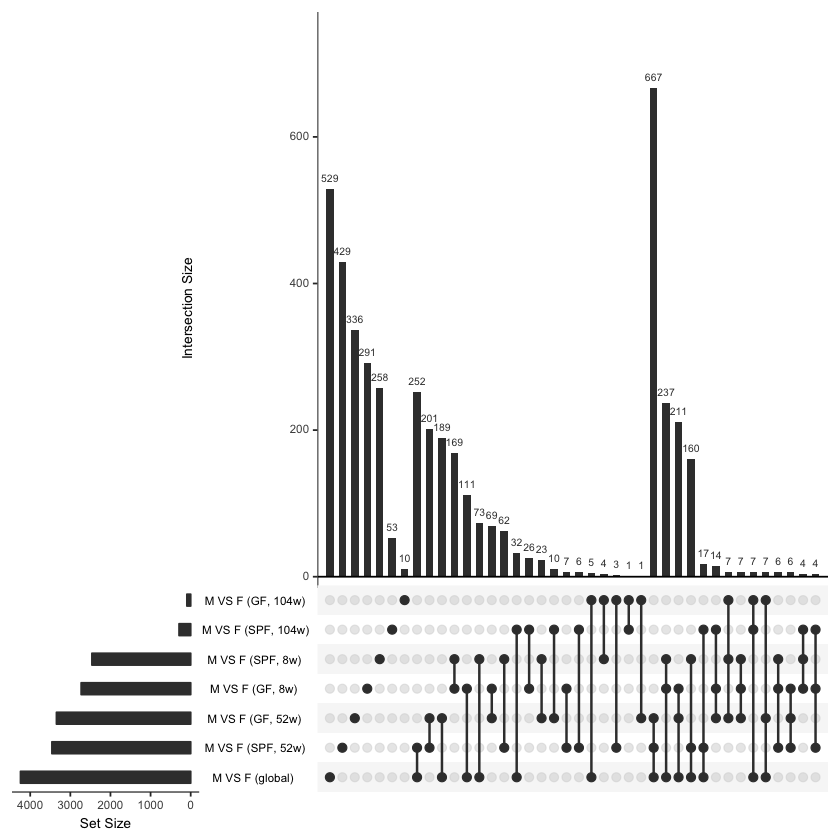

In [442]:
# Differentially expressed genes
upset(as.data.frame(gender_age_type_deg$deg), nsets = 7)

# Type effect

Questions
- What are the differences between the 2 types?
- Are they different for the 3 ages?
- Are they different for the 2 genders?


## Global stats

In [443]:
# Comparison between the types (after controlling for age and gender)
GF_SPF = results(dge,contrast= c(0,0,1,0,0,0,0,1/2,1/3,1/3), alpha=0.05, test="Wald")
# Stats
type_global_stats = matrix(0, nrow=1, ncol=3)
rownames(type_global_stats) = c("GF VS SPF")
colnames(type_global_stats) = c("Wald padj < 0.05", "LFC > 0 (Wald padj < 0.05)", "LFC < 0 (Wald padj < 0.05)")
type_global_stats[1,] = get_stats_padj(GF_SPF)
type_global_stats

Wald padj < 0.05 LFC > 0 (Wald padj < 0.05)
GF VS SPF 12.36            5.13                      
          LFC < 0 (Wald padj < 0.05)
GF VS SPF 7.23

In [444]:
# Interactions between genders and ages (after controlling type)
GF_SPF_8w = results(dge,contrast= c(0,0,1,0,0,0,0,1/2,0,0), alpha=0.05, test="Wald")
GF_SPF_52w = results(dge,contrast= c(0,0,1,0,0,0,0,1/2,0,1), alpha=0.05, test="Wald")
GF_SPF_104w = results(dge,contrast= c(0,0,1,0,0,0,0,1/2,1,0), alpha=0.05, test="Wald")
# Stats
type_age_stats = matrix(0, nrow=3, ncol=3)
rownames(type_age_stats) = c("GF VS SPF (8w)", "GF VS SPF (52w)", "GF VS SPF (104w)")
colnames(type_age_stats) = c("Wald padj < 0.05", "LFC > 0 (Wald padj < 0.05)", "LFC < 0 (Wald padj < 0.05)")
type_age_stats[1,] = get_stats_padj(GF_SPF_8w)
type_age_stats[2,] = get_stats_padj(GF_SPF_52w)
type_age_stats[3,] = get_stats_padj(GF_SPF_104w)
type_age_stats

Wald padj < 0.05 LFC > 0 (Wald padj < 0.05)
GF VS SPF (8w)    1.63            0.87                      
GF VS SPF (52w)   3.76            1.50                      
GF VS SPF (104w) 12.66            5.42                      
                 LFC < 0 (Wald padj < 0.05)
GF VS SPF (8w)   0.76                      
GF VS SPF (52w)  2.26                      
GF VS SPF (104w) 7.24

In [445]:
# Interactions between genders and types (after controlling age)
GF_SPF_F = results(dge,contrast= c(0,0,1,0,0,0,0,0,1/3,1/3), alpha=0.05, test="Wald")
GF_SPF_M = results(dge,contrast= c(0,0,1,0,0,0,0,1,1/3,1/3), alpha=0.05, test="Wald")
# Stats
type_gender_stats = matrix(0, nrow=2, ncol=3)
rownames(type_gender_stats) = c("GF VS SPF (F)", "GF VS SPF (M)")
colnames(type_gender_stats) = c("Wald padj < 0.05", "LFC > 0 (Wald padj < 0.05)", "LFC < 0 (Wald padj < 0.05)")
type_gender_stats[1,] = get_stats_padj(GF_SPF_F)
type_gender_stats[2,] = get_stats_padj(GF_SPF_M)
type_gender_stats

Wald padj < 0.05 LFC > 0 (Wald padj < 0.05)
GF VS SPF (F) 8.09             3.31                      
GF VS SPF (M) 4.56             1.84                      
              LFC < 0 (Wald padj < 0.05)
GF VS SPF (F) 4.78                      
GF VS SPF (M) 2.71

In [446]:
# Interactions between genders, types and ages
GF_SPF_F_8w = results(dge,contrast= c(0,0,1,0,0,0,0,0,0,0), alpha=0.05, test="Wald")
GF_SPF_M_8w = results(dge,contrast= c(0,0,1,0,0,0,0,1,0,0), alpha=0.05, test="Wald")
GF_SPF_F_52w = results(dge,contrast= c(0,0,1,0,0,0,0,0,0,1), alpha=0.05, test="Wald")
GF_SPF_M_52w = results(dge,contrast= c(0,0,1,0,0,0,0,1,0,1), alpha=0.05, test="Wald")
GF_SPF_F_104w = results(dge,contrast= c(0,0,1,0,0,0,0,0,1,0), alpha=0.05, test="Wald")
GF_SPF_M_104w = results(dge,contrast= c(0,0,1,0,0,0,0,1,1,0), alpha=0.05, test="Wald")
# Stats
type_gender_age_stats = matrix(0, nrow=6, ncol=3)
rownames(type_gender_age_stats) = c("GF VS SPF (F, 8w)", "GF VS SPF (M, 8w)", "GF VS SPF (F, 52w)", "GF VS SPF (M, 52w)", "GF VS SPF (F, 104w)", "GF VS SPF (M, 104w)")
colnames(type_gender_age_stats) = c("Wald padj < 0.05", "LFC > 0 (Wald padj < 0.05)", "LFC < 0 (Wald padj < 0.05)")
type_gender_age_stats[1,] = get_stats_padj(GF_SPF_F_8w)
type_gender_age_stats[2,] = get_stats_padj(GF_SPF_M_8w)
type_gender_age_stats[3,] = get_stats_padj(GF_SPF_F_52w)
type_gender_age_stats[4,] = get_stats_padj(GF_SPF_M_52w)
type_gender_age_stats[5,] = get_stats_padj(GF_SPF_F_104w)
type_gender_age_stats[6,] = get_stats_padj(GF_SPF_M_104w)
type_gender_age_stats

Wald padj < 0.05 LFC > 0 (Wald padj < 0.05)
GF VS SPF (F, 8w)    1.89            0.93                      
GF VS SPF (M, 8w)    0.78            0.37                      
GF VS SPF (F, 52w)   3.56            1.53                      
GF VS SPF (M, 52w)   1.90            0.70                      
GF VS SPF (F, 104w)  9.84            4.08                      
GF VS SPF (M, 104w) 10.48            4.33                      
                    LFC < 0 (Wald padj < 0.05)
GF VS SPF (F, 8w)   0.97                      
GF VS SPF (M, 8w)   0.41                      
GF VS SPF (F, 52w)  2.04                      
GF VS SPF (M, 52w)  1.20                      
GF VS SPF (F, 104w) 5.75                      
GF VS SPF (M, 104w) 6.15

## Comparison between the types (after controlling for gender and age)


In [447]:
sign = which(GF_SPF$padj < 0.05)
type_deg = GF_SPF[sign,'log2FoldChange']
names(type_deg) = rownames(GF_SPF[sign,])

In [448]:
samples = c(
    'SPF_8w_F_1_2','SPF_8w_F_3_2','SPF_8w_F_4_2','SPF_8w_F_5_2','SPF_52w_F_1_2','SPF_52w_F_2_2','SPF_52w_F_3_2','SPF_52w_F_4_2','SPF_52w_F_5_2','SPF_52w_F_6_2','SPF_104w_F_1_2','SPF_104w_F_2_2','SPF_104w_F_3_2',
    'SPF_8w_M_1_2','SPF_8w_M_2_2','SPF_8w_M_3_2','SPF_8w_M_4_2','SPF_52w_M_1_2','SPF_52w_M_2_2','SPF_52w_M_3_2','SPF_52w_M_4_2','SPF_52w_M_5_2','SPF_104w_M_1_2','SPF_104w_M_2_2','SPF_104w_M_3_2','SPF_104w_M_4_2','SPF_104w_M_5_2','SPF_104w_M_6_2','SPF_104w_M_7_2','SPF_104w_M_8_2','SPF_104w_M_9_2','SPF_104w_M_10_2','SPF_104w_M_11_2','SPF_104w_M_12_2','SPF_104w_M_13_2','SPF_104w_M_14_2',
    'GF_8w_F_1_2','GF_8w_F_2_2','GF_8w_F_3_2','GF_8w_F_4_2','GF_8w_F_5_2','GF_52w_F_1_2','GF_52w_F_2_2','GF_52w_F_3_2','GF_52w_F_4_2','GF_52w_F_5_2','GF_52w_F_6_2','GF_104w_F_1_2','GF_104w_F_2_2','GF_104w_F_3_2',
    'GF_8w_M_1_2','GF_8w_M_2_2','GF_8w_M_3_2','GF_8w_M_4_2','GF_52w_M_1_2','GF_52w_M_2_2','GF_52w_M_3_2','GF_52w_M_4_2','GF_104w_M_1_2','GF_104w_M_2_2')
annot = as.data.frame(colData(dge)[, c("type", "gender", "age")])

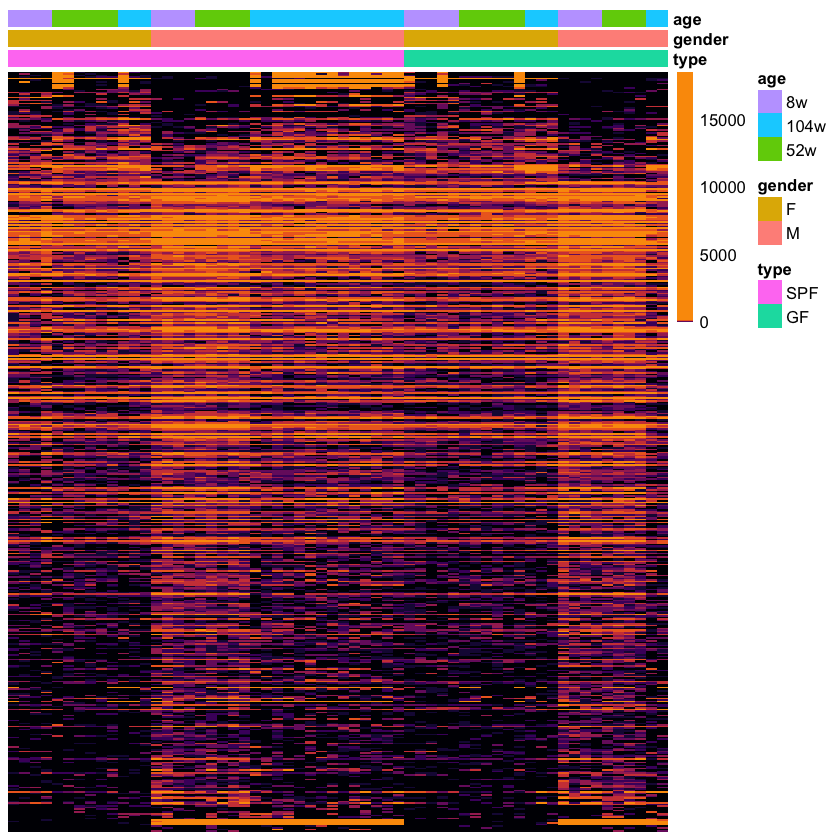

In [449]:
genes = names((sort(gender_deg[which(abs(gender_deg)>1)])))
plot_count_heatmap(genes,samples, annot)

## Comparison between the types for the genders (after controlling for age)

Questions
- What are the differences between the types for the genders?
- Do we observe the same changes as globally?

In [450]:
type_gender_data = list(GF_SPF_F, GF_SPF_M, GF_SPF)
names(type_gender_data) = c("GF VS SPF (F)", "GF VS SPF (M)", "GF VS SPF (global)")
type_gender_deg = extract_diff_expr_genes(type_gender_data, "type_gender_data")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

In [451]:
F_samples = c(
    'SPF_8w_F_1_2','SPF_8w_F_3_2','SPF_8w_F_4_2','SPF_8w_F_5_2','SPF_52w_F_1_2','SPF_52w_F_2_2','SPF_52w_F_3_2','SPF_52w_F_4_2','SPF_52w_F_5_2','SPF_52w_F_6_2','SPF_104w_F_1_2','SPF_104w_F_2_2','SPF_104w_F_3_2',
    'GF_8w_F_1_2','GF_8w_F_2_2','GF_8w_F_3_2','GF_8w_F_4_2','GF_8w_F_5_2','GF_52w_F_1_2','GF_52w_F_2_2','GF_52w_F_3_2','GF_52w_F_4_2','GF_52w_F_5_2','GF_52w_F_6_2','GF_104w_F_1_2','GF_104w_F_2_2','GF_104w_F_3_2')
M_samples = c(
    'SPF_8w_M_1_2','SPF_8w_M_2_2','SPF_8w_M_3_2','SPF_8w_M_4_2','SPF_52w_M_1_2','SPF_52w_M_2_2','SPF_52w_M_3_2','SPF_52w_M_4_2','SPF_52w_M_5_2','SPF_104w_M_1_2','SPF_104w_M_2_2','SPF_104w_M_3_2','SPF_104w_M_4_2','SPF_104w_M_5_2','SPF_104w_M_6_2','SPF_104w_M_7_2','SPF_104w_M_8_2','SPF_104w_M_9_2','SPF_104w_M_10_2','SPF_104w_M_11_2','SPF_104w_M_12_2','SPF_104w_M_13_2','SPF_104w_M_14_2',
    'GF_8w_M_1_2','GF_8w_M_2_2','GF_8w_M_3_2','GF_8w_M_4_2','GF_52w_M_1_2','GF_52w_M_2_2','GF_52w_M_3_2','GF_52w_M_4_2','GF_104w_M_1_2','GF_104w_M_2_2')
annot = as.data.frame(colData(dge)[, c("type","age")])

### Counts

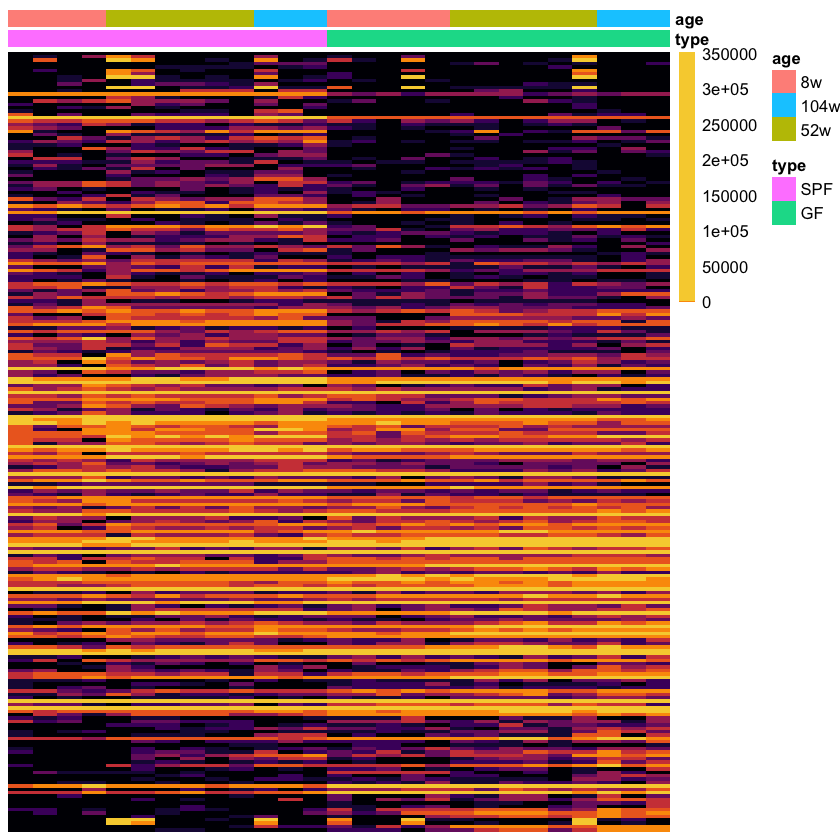

In [452]:
# GF != SPF for F with abs(FC) > 2
genes = names((sort(type_gender_deg$fc_deg[which(abs(type_gender_deg$fc_deg[,1])>1),1])))
plot_count_heatmap(genes,F_samples, annot)

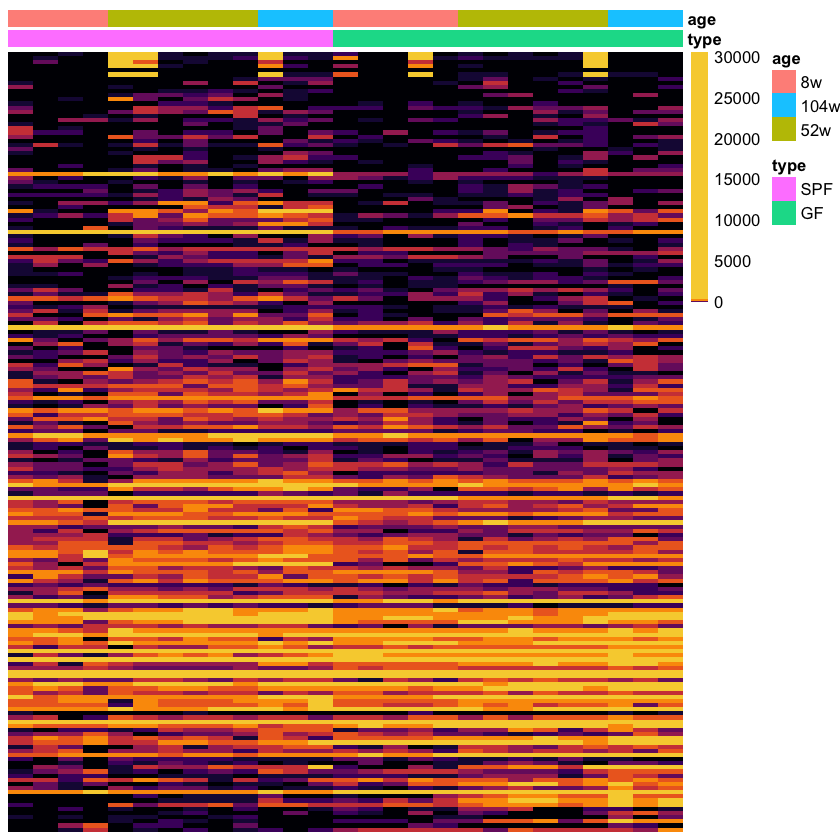

In [453]:
# GF != SPF for M with abs(FC) > 2
genes = names((sort(type_gender_deg$fc_deg[which(abs(type_gender_deg$fc_deg[,2])>1),2])))
plot_count_heatmap(genes,F_samples, annot)

### Comparison of the numbers per genders


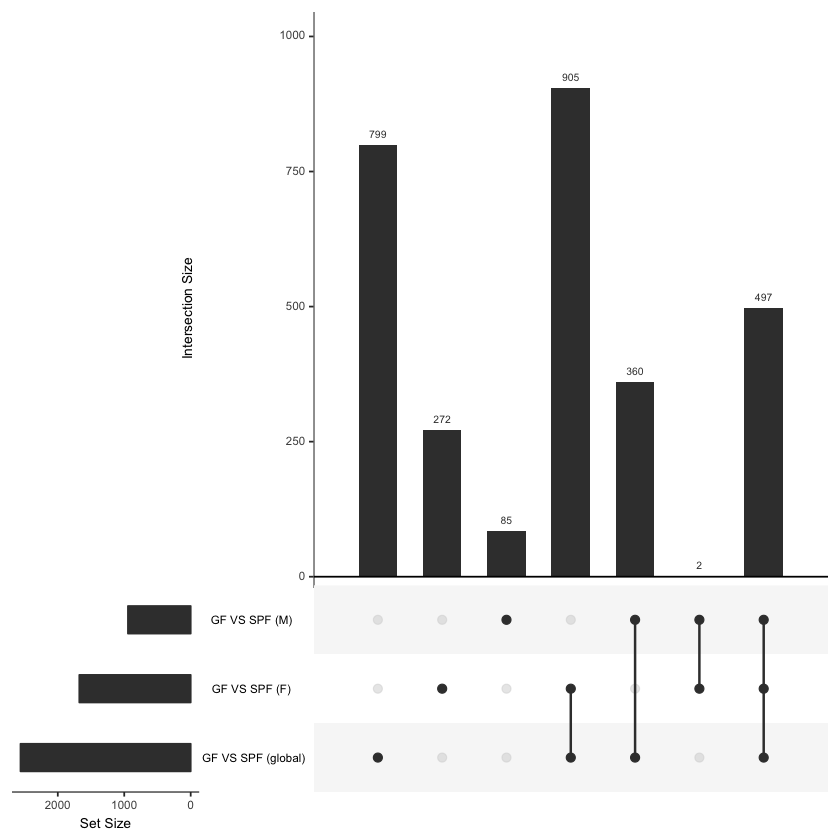

In [454]:
# Differentially expressed genes
upset(as.data.frame(type_gender_deg$deg))

## Comparison between the types for the ages (after controlling for gender)

Questions
- What are the differences between the types for the ages?
- Do we observe the same changes as globally?

In [455]:
type_age_data = list(GF_SPF_8w, GF_SPF_52w, GF_SPF_104w, GF_SPF)
names(type_age_data) = c("GF VS SPF (8w)", "GF VS SPF (52w)", "GF VS SPF (104w)", "GF VS SPF (global)")
type_age_deg = extract_diff_expr_genes(type_age_data, "type_age_data")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

In [456]:
w8_samples = c(
    'SPF_8w_F_1_2','SPF_8w_F_3_2','SPF_8w_F_4_2','SPF_8w_F_5_2','SPF_8w_M_1_2','SPF_8w_M_2_2','SPF_8w_M_3_2','SPF_8w_M_4_2',
    'GF_8w_F_1_2','GF_8w_F_2_2','GF_8w_F_3_2','GF_8w_F_4_2','GF_8w_F_5_2','GF_8w_M_1_2','GF_8w_M_2_2','GF_8w_M_3_2','GF_8w_M_4_2')
w52_samples = c(    
    'SPF_52w_F_1_2','SPF_52w_F_2_2','SPF_52w_F_3_2','SPF_52w_F_4_2','SPF_52w_F_5_2','SPF_52w_F_6_2','SPF_52w_M_1_2','SPF_52w_M_2_2','SPF_52w_M_3_2','SPF_52w_M_4_2','SPF_52w_M_5_2',
    'GF_52w_F_1_2','GF_52w_F_2_2','GF_52w_F_3_2','GF_52w_F_4_2','GF_52w_F_5_2','GF_52w_F_6_2','GF_52w_M_1_2','GF_52w_M_2_2','GF_52w_M_3_2','GF_52w_M_4_2')
w104_samples = c(      
    'SPF_104w_F_1_2','SPF_104w_F_2_2','SPF_104w_F_3_2','SPF_104w_M_1_2','SPF_104w_M_2_2','SPF_104w_M_3_2','SPF_104w_M_4_2','SPF_104w_M_5_2','SPF_104w_M_6_2','SPF_104w_M_7_2','SPF_104w_M_8_2','SPF_104w_M_9_2','SPF_104w_M_10_2','SPF_104w_M_11_2','SPF_104w_M_12_2','SPF_104w_M_13_2','SPF_104w_M_14_2',
    'GF_104w_F_1_2','GF_104w_F_2_2','GF_104w_F_3_2','GF_104w_M_1_2','GF_104w_M_2_2')
annot = as.data.frame(colData(dge)[, c("type","gender")])

### Counts

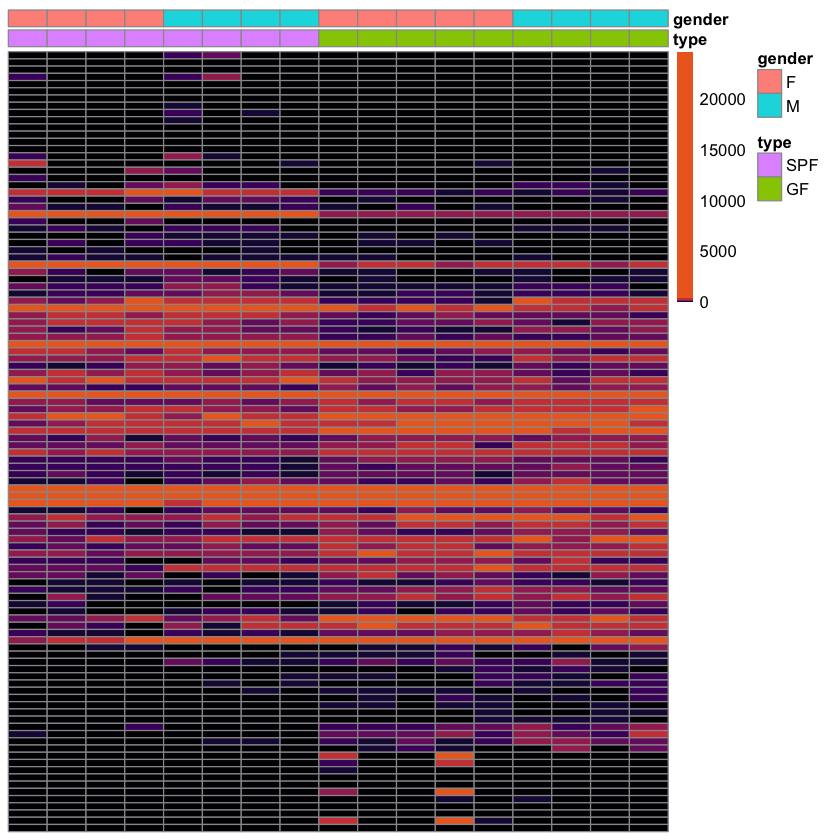

In [457]:
# GF != SPF for 8w with abs(FC) > 2
genes = names((sort(type_age_deg$fc_deg[which(abs(type_age_deg$fc_deg[,1])>1),1])))
plot_count_heatmap(genes,w8_samples, annot)

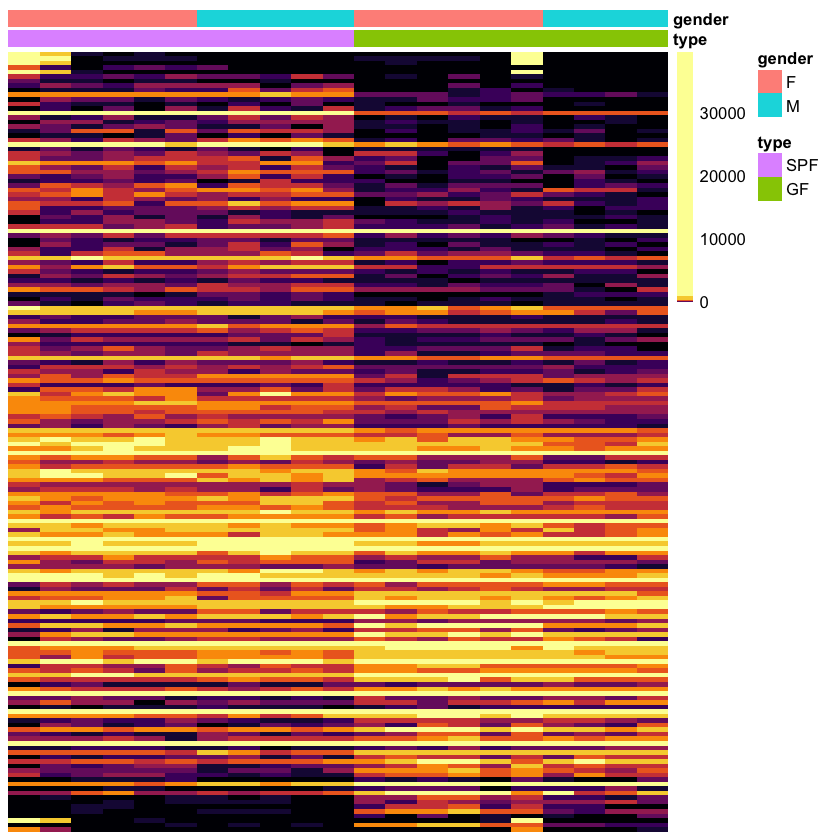

In [458]:
# GF != SPF for 52w with abs(FC) > 2
genes = names((sort(type_age_deg$fc_deg[which(abs(type_age_deg$fc_deg[,2])>1),2])))
plot_count_heatmap(genes,w52_samples, annot)

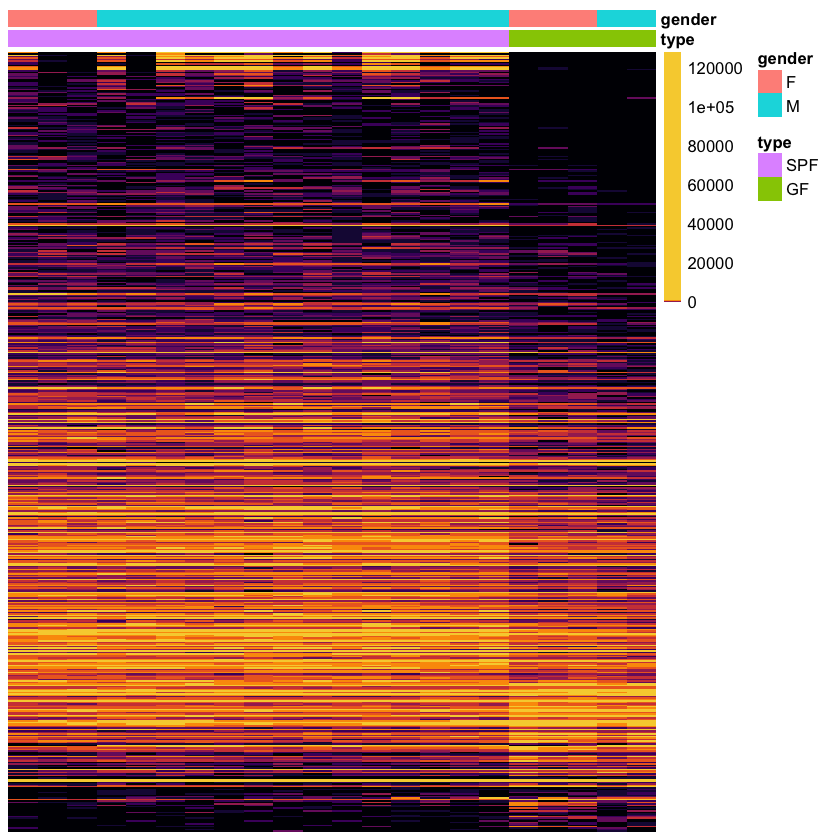

In [459]:
# GF != SPF for 104w with abs(FC) > 2
genes = names((sort(type_age_deg$fc_deg[which(abs(type_age_deg$fc_deg[,3])>1),3])))
plot_count_heatmap(genes,w104_samples, annot)

### Comparison of the numbers per ages

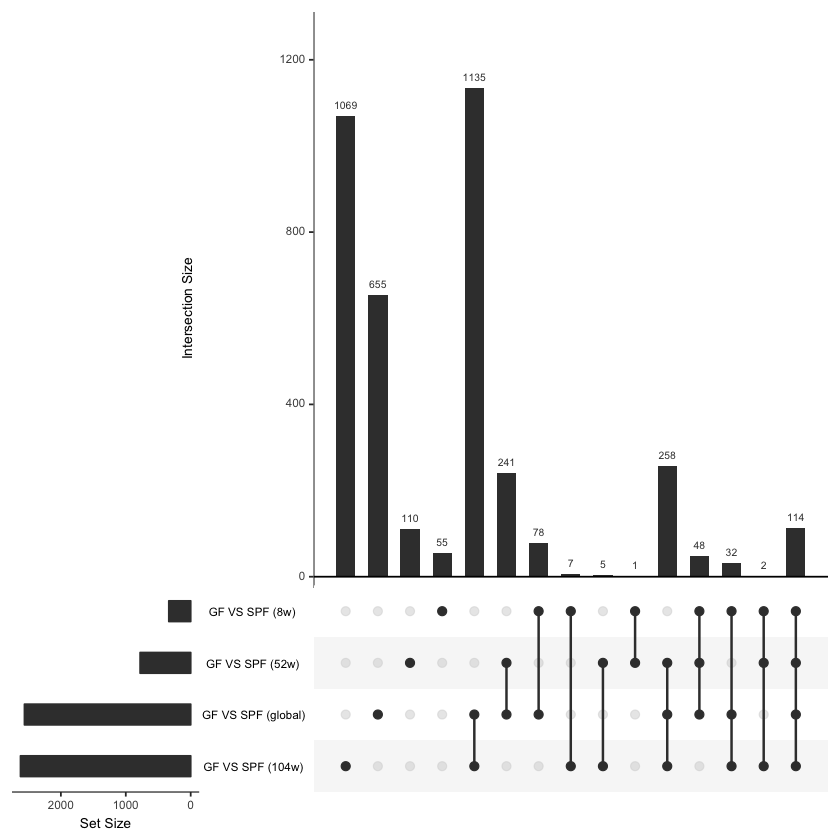

In [460]:
# Differentially expressed genes
upset(as.data.frame(type_age_deg$deg))

## Comparison between the types for the ages and genders

Questions
- What are the differences between the type for the different combinations of ages and genders?
- Do we observe the same changes as globally?

In [461]:
type_gender_age_data = list(GF_SPF_F_8w, GF_SPF_M_8w, GF_SPF_F_52w, GF_SPF_M_52w, GF_SPF_F_104w, GF_SPF_M_104w, GF_SPF)
names(type_gender_age_data) = c("GF VS SPF (F, 8w)", "GF VS SPF (M, 8w)", "GF VS SPF (F, 52w)", "GF VS SPF (M, 52w)", "GF VS SPF (F, 104w)", "GF VS SPF (M, 104w)", "GF VS SPF (global)")
type_gender_age_deg = extract_diff_expr_genes(type_gender_age_data, "type_gender_age_data")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

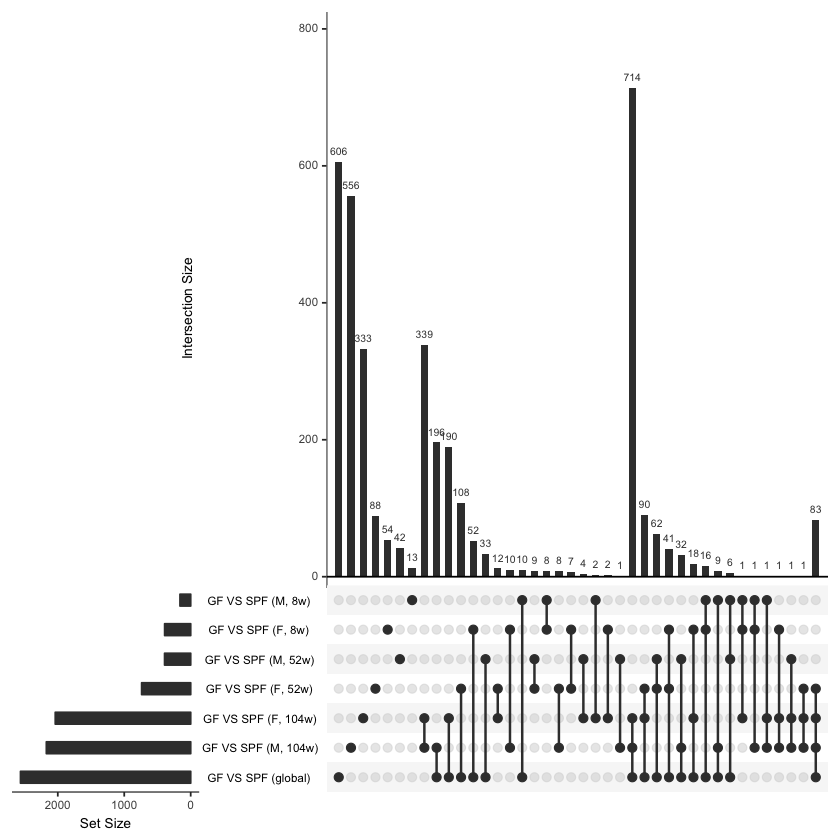

In [462]:
# Differentially expressed genes
upset(as.data.frame(type_gender_age_deg$deg), nsets = 7)

### Checking genes between GF vs SPF at 52w in M, F, Global

In [463]:
type_gender_52w_data = list(GF_SPF_F_52w, GF_SPF_M_52w, GF_SPF_52w)
names(type_gender_52w_data) = c("GF VS SPF (F, 52w)", "GF VS SPF (M, 52)", "GF VS SPF (52w)")
type_gender_52w_deg = extract_diff_expr_genes(type_gender_52w_data, "type_gender_52w")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

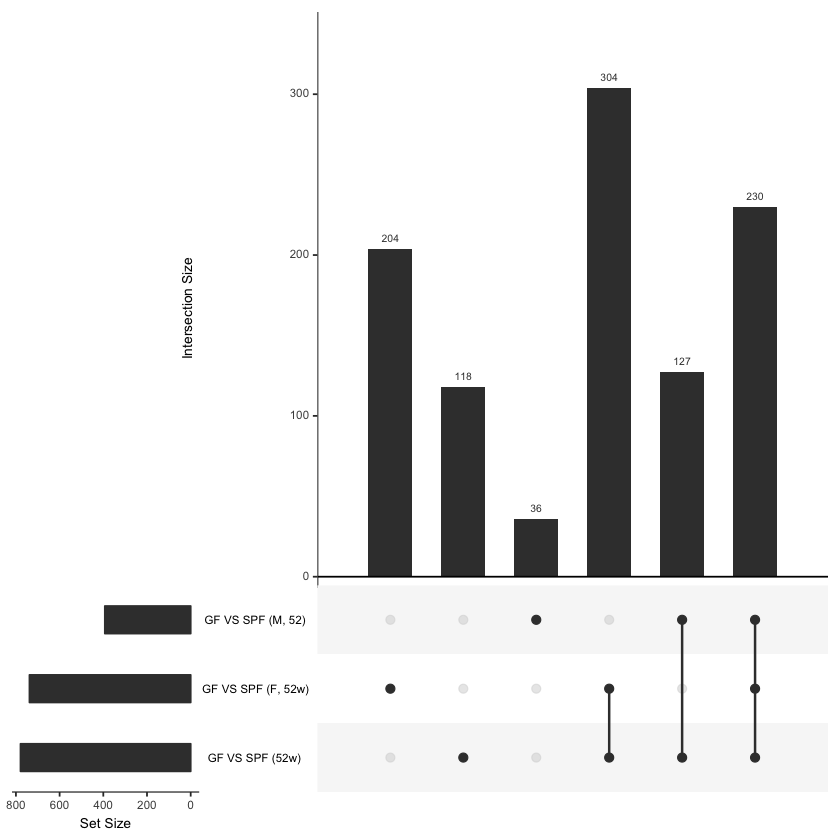

In [464]:
# Differentially expressed genes
upset(as.data.frame(type_gender_52w_deg$deg), nsets = 8)

In [465]:
genes = names(sort(abs(type_gender_52w_deg$fc_deg[!is.na(type_gender_52w_deg$fc_deg[,3]),3]), decreasing = T))[1:100]
type_gender_52w_deg$fc_deg[genes,]

GF VS SPF (F, 52w) GF VS SPF (M, 52) GF VS SPF (52w)
Ltf                  NA          -24.072963        -11.996265     
Ngp                  NA          -21.369654        -10.503089     
Camp                 NA          -14.410735         -7.212610     
Gcm2          -6.446621           -7.327660         -6.887141     
Lcn2                 NA          -13.765493         -6.870701     
Hp                   NA           13.120285          6.513351     
Plet1os        7.244540            4.185800          5.715170     
Chil3                NA            9.450237          5.365312     
Sh3gl2         4.993318            5.719502          5.356410     
Slc10a6        6.667130            3.869105          5.268117     
Zbtb16         5.891986                  NA          4.790594     
Melk                 NA           -6.412633         -4.700968     
Dhcr24        -4.399958           -4.417988         -4.408973     
Dtl                  NA           -5.428460         -4.305085     
Plcd3          3.271529            5.321914          4.296721     
Plet1          5.063192                  NA          3.796220     
Bub1                 NA           -6.736868         -3.709321     
Lrmda         -3.539950           -3.836219         -3.688085     
Ddit4          4.610100            2.533409          3.571754     
Fbxo40               NA           -5.797529         -3.439179     
C030034L19Rik  3.479544            3.261769          3.370657     
Clspn                NA                  NA         -3.369817     
Kif23                NA           -6.011522         -3.357799     
Wdfy1          3.512969            2.654456          3.083713     
Emilin2              NA            4.298367          3.037712     
Gpr137b-ps    -2.979633           -3.010328         -2.994980     
Esco2                NA                  NA         -2.990435     
Zfp507        -3.153656                  NA         -2.949730     
Vegfa         -2.831979           -2.841539         -2.836759     
Wee1                 NA           -3.494241         -2.830145     
⋮             ⋮                  ⋮                 ⋮              
Ston1          2.178082                 NA          1.746180      
Pik3ip1        1.947662           1.540898          1.744280      
Prc1                 NA                 NA         -1.740725      
Gm15850       -1.545530          -1.910497         -1.728014      
Gm3716               NA          -2.431943         -1.714849      
Adora1               NA                 NA          1.704761      
Tnfrsf26             NA           1.952447          1.691928      
Fignl1               NA                 NA         -1.683273      
Hist1h4c      -2.322904                 NA         -1.623216      
Slc2a3         1.937556           1.284185          1.610871      
Tsc22d3        2.168578           1.048732          1.608655      
Macrod2              NA                 NA         -1.581553      
Smco4         -1.896494                 NA         -1.578807      
Cst7          -1.547905          -1.576267         -1.562086      
Tmem150b       1.609675                 NA          1.553218      
Ptchd1        -1.516147          -1.589158         -1.552652      
H2-Q5         -1.641123                 NA         -1.521441      
Gm826                NA          -2.003436         -1.509977      
Dbp           -1.652729          -1.337480         -1.495104      
Cdc42ep1             NA           1.991376          1.490996      
Tspan8               NA           2.187251          1.488670      
Zmynd15       -1.251642          -1.721647         -1.486644      
Ccnb1                NA          -2.158646         -1.484547      
Ccr6          -1.873690                 NA         -1.481700      
Maff                 NA                 NA         -1.439898      
Pnma2                NA          -2.011268         -1.434852      
8030423J24Rik -1.294422          -1.526018         -1.410220      
Sult1a1        1.537097           1.250531          1.393814 

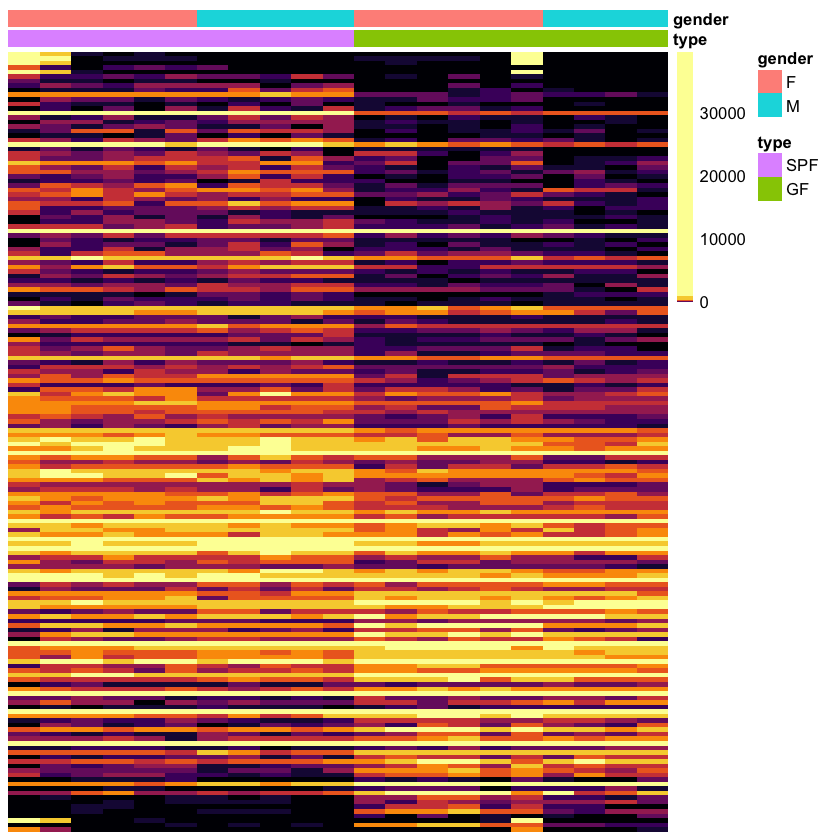

In [466]:
samples = c(
    'SPF_52w_F_1_2','SPF_52w_F_2_2','SPF_52w_F_3_2','SPF_52w_F_4_2','SPF_52w_F_5_2','SPF_52w_F_6_2','SPF_52w_M_1_2','SPF_52w_M_2_2','SPF_52w_M_3_2','SPF_52w_M_4_2','SPF_52w_M_5_2',
    'GF_52w_F_1_2','GF_52w_F_2_2','GF_52w_F_3_2','GF_52w_F_4_2','GF_52w_F_5_2','GF_52w_F_6_2','GF_52w_M_1_2','GF_52w_M_2_2','GF_52w_M_3_2','GF_52w_M_4_2')
annot = as.data.frame(colData(dge)[, c("type", "gender")])
genes = names((sort(type_gender_52w_deg$fc_deg[which(abs(type_gender_52w_deg$fc_deg[,3])>1),3])))
plot_count_heatmap(genes,samples, annot)

### Checking genes between GF vs SPF at 104w in M, F, Global

In [467]:
type_gender_104w_data = list(GF_SPF_F_104w, GF_SPF_M_104w, GF_SPF_104w)
names(type_gender_104w_data) = c("GF VS SPF (F, 104w)", "GF VS SPF (M, 104w)", "GF VS SPF (104w)")
type_gender_104w_deg = extract_diff_expr_genes(type_gender_104w_data, "type_gender_104w")

Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UCSC.mm10.knownGene
Trying to get the gene lengths from it.
Warning message in pcls(G):
“initial point very close to some inequality constraints”Can't find mm10/geneSymbol length data in genLenDataBase...
Warning message in grep(txdbPattern, installedPackages):
“argument 'pattern' has length > 1 and only the first element will be used”Found the annotaion package, TxDb.Mmusculus.UC

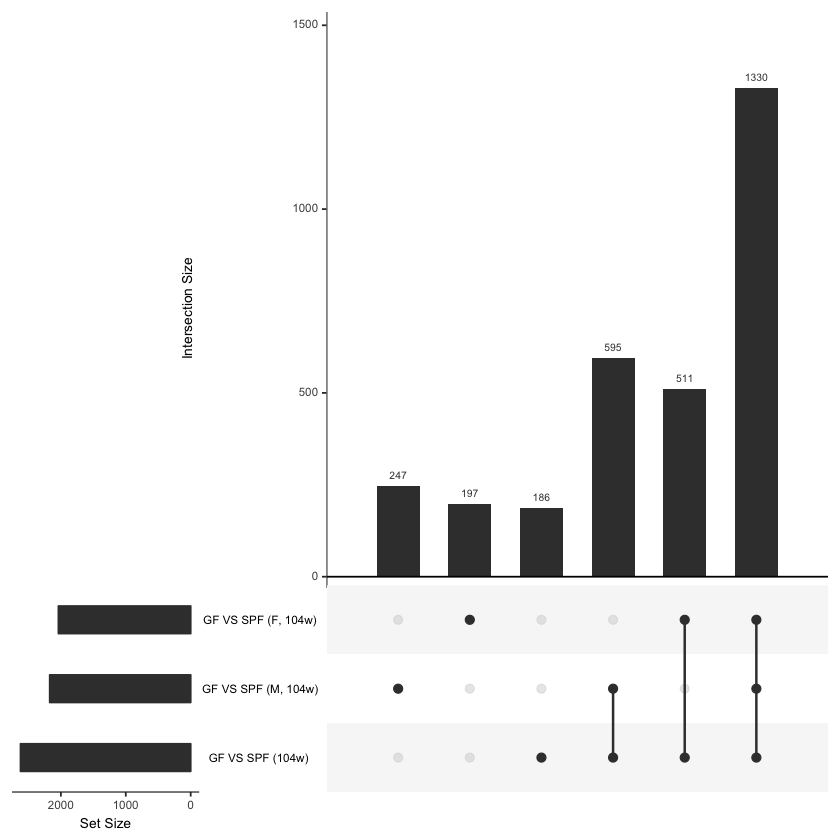

In [468]:
# Differentially expressed genes
upset(as.data.frame(type_gender_104w_deg$deg), nsets = 8)

In [469]:
genes = names(sort(abs(type_gender_104w_deg$fc_deg[!is.na(type_gender_104w_deg$fc_deg[,3]),3]), decreasing = T))[1:100]

In [470]:
type_gender_104w_deg$fc_deg[genes,]

GF VS SPF (F, 104w) GF VS SPF (M, 104w) GF VS SPF (104w)
Ltf           -21.838443          -45.991839          -33.915141      
Mpo           -38.436759          -26.322156          -32.379458      
Ngp           -20.956969          -42.690099          -31.823534      
Cd177         -20.659916          -32.775136          -26.717526      
Chil3         -28.565888          -20.396038          -24.480963      
Hp            -30.913026          -17.699158          -24.306092      
Lcn2          -14.907759          -28.697343          -21.802551      
Gm19434               NA          -18.462053          -19.074210      
Fcnb          -22.518481          -13.124828          -17.821655      
Ptprh                 NA          -15.526779          -15.816590      
Slc7a3                NA                  NA           15.211287      
Cpxm1                 NA                  NA           14.300792      
Camp           -6.157557          -20.553808          -13.355683      
S100a8         -6.077194          -13.045862           -9.561528      
Kcnt1                 NA            8.358107            9.157822      
S100a9                NA           -9.529968           -7.753187      
Pglyrp1        -7.434899           -7.821359           -7.628129      
Cd209a         -7.664560           -7.413592           -7.539076      
Zbtb16          8.568628            6.365843            7.467236      
Wfdc21                NA           -9.632741           -7.387091      
Itgb2l                NA           -7.211720           -6.939230      
Rtkn2          -5.870534           -7.785650           -6.828092      
Trem3          -6.115044           -7.504240           -6.809642      
Apln           -6.907106           -6.695671           -6.801388      
Stil                  NA           -9.133186           -6.721572      
Lrg1                  NA           -7.883067           -6.525613      
Zcchc18        -6.632580           -6.263385           -6.447983      
Serpinb1a             NA           -8.170673           -6.408762      
Hsd11b1        -6.079744           -6.326382           -6.203063      
Hpcal4         -5.905787           -6.467031           -6.186409      
⋮             ⋮                   ⋮                   ⋮               
Tuba8         -5.357926                  NA           -5.128970       
D330050G23Rik        NA           -5.624453           -5.058528       
2210406O10Rik -5.007537           -5.107745           -5.057641       
Dbndd1        -5.654544                  NA           -4.977997       
Grik4                NA                  NA           -4.955695       
Kcnh4         -4.939991           -4.952241           -4.946116       
Chek1                NA           -6.811084           -4.863813       
6430571L13Rik -4.882574           -4.825369           -4.853971       
A430093F15Rik        NA           -5.147126           -4.843411       
3300005D01Rik -5.573297                  NA           -4.790312       
AA413626      -6.624004                  NA           -4.789934       
Bcan                 NA           -5.029899           -4.752711       
Ifi208        -4.392056           -5.081254           -4.736655       
Gm6297        -4.970047           -4.485138           -4.727592       
Grm3          -4.912823           -4.507330           -4.710076       
Mtss1l               NA           -5.490602           -4.694147       
Eldr                 NA           -5.976405           -4.689214       
Plcd3          3.640037            5.690422            4.665229       
Dusp9                NA           -5.555825           -4.635693       
Tmem178              NA           -5.329212           -4.574586       
Plet1          5.810177            3.276234            4.543206       
Spin4          5.249361                  NA            4.504583       
Hist1h2ba            NA            4.865742            4.504350       
Fbxo2                NA           -5.052160           -4.473474       
Proca1        -5.042020               

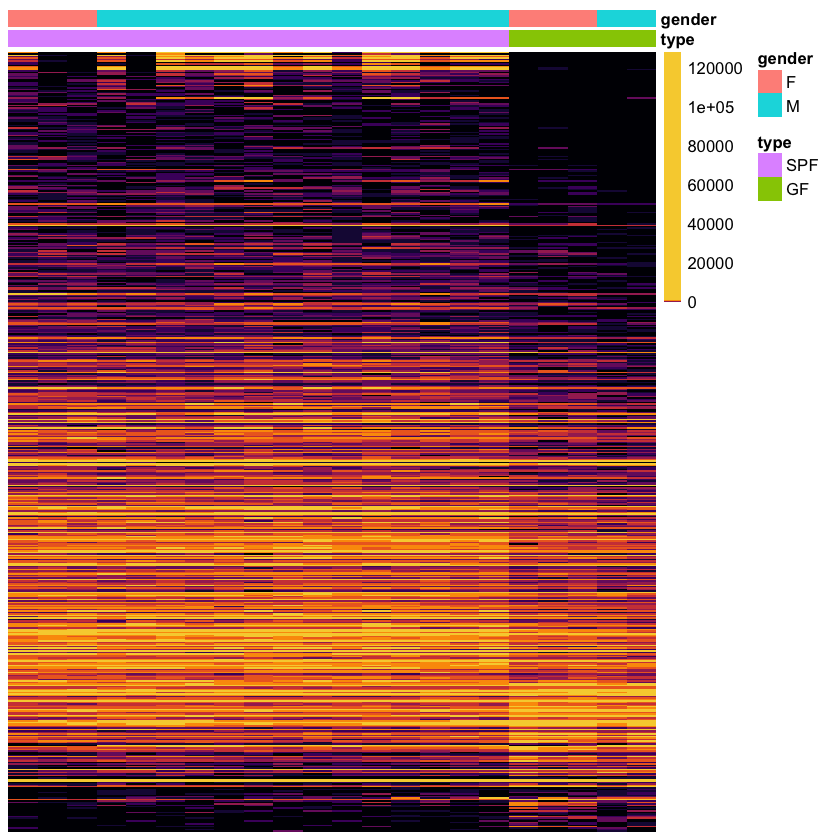

In [471]:
samples = c(
    'SPF_104w_F_1_2','SPF_104w_F_2_2','SPF_104w_F_3_2',
    'SPF_104w_M_1_2','SPF_104w_M_2_2','SPF_104w_M_3_2','SPF_104w_M_4_2','SPF_104w_M_5_2','SPF_104w_M_6_2','SPF_104w_M_7_2','SPF_104w_M_8_2','SPF_104w_M_9_2','SPF_104w_M_10_2','SPF_104w_M_11_2','SPF_104w_M_12_2','SPF_104w_M_13_2','SPF_104w_M_14_2',
    'GF_104w_F_1_2','GF_104w_F_2_2','GF_104w_F_3_2',
    'GF_104w_M_1_2','GF_104w_M_2_2')
annot = as.data.frame(colData(dge)[, c("type", "gender")])
genes = names((sort(type_gender_104w_deg$fc_deg[which(abs(type_gender_104w_deg$fc_deg[,3])>1),3])))
plot_count_heatmap(genes,samples, annot)

## Comparison with Erny results

Protocol: 2 months old female mices (GF vs SPF)

In [472]:
# our data
GF_SPF_F_8w_fc_deg = type_gender_age_deg$fc_deg[,1]
GF_SPF_F_8w_fc_deg = GF_SPF_F_8w_fc_deg[!is.na(GF_SPF_F_8w_fc_deg)]

### Raw comparison of the results

In [473]:
# Erny data: transform the gene symbol and use log2(FC)
erny_results = read.csv("../data/erny_results.csv")
erny_results[,1] = capFirst(as.character(erny_results[,1]))
erny_results[,2] = as.character(erny_results[,2])
erny_results[,3] = log2(erny_results[,3])
erny_results[erny_results[,1] == "1700001c19rik",1] = "1700001C19Rik"
erny_results[erny_results[,1] == "Fam125a",1] = "Mvb12a"
erny_results[erny_results[,1] == "Sepw1",1] = "Selenow"
erny_results[erny_results[,1] == "Ppapdc3",1] = "Plpp7"
erny_results[erny_results[,1] == "Ccdc101",1] = "Sgf29"
erny_results[erny_results[,1] == "Tcfeb",1] = "Tfeb"
erny_results[erny_results[,1] == "2810408m09rik",1] = "Trp53rka"
erny_results[erny_results[,1] == "2300009a05rik",1] = "2300009A05Rik"
erny_results[erny_results[,1] == "2900010m23rik",1] = "Uqcc2"
erny_results[erny_results[,1] == "Ccdc55",1] = "Nsrp1"
erny_results[erny_results[,1] == "Phf15",1] = "Jade2"
erny_results[erny_results[,1] == "Mobkl2a",1] = "Mob3a"
erny_results[erny_results[,1] == "C030046i01rik",1] = "R3hdm4"
erny_results[erny_results[,1] == "H2-dmb1",1] = "H2-DMb1"
erny_results[erny_results[,1] == "D15ertd621e",1] = "Fam91a1"
erny_results[erny_results[,1] == "Bc030336",1] = "BC030336"
erny_results[erny_results[,1] == "C330007p06rik",1] = "C330007P06Rik"
erny_results[erny_results[,1] == "4931406h21rik",1] = "4931406H21Rik"
erny_results[erny_results[,1] == "Gm13253",1] = "Rps15a-ps4"
erny_results[erny_results[,1] == "Hiatl1",1] = "Mfsd14b"
erny_results[erny_results[,1] == "Bc031353",1] = "Fam214a"
erny_results[erny_results[,1] == "Cep110",1] = "Cntrl"
erny_results[erny_results[,1] == "B130006d01rik",1] = "B130006D01Rik"
erny_results[erny_results[,1] == "D6wsu163e",1] = "D6Wsu163e"
erny_results[erny_results[,1] == "Fam82b",1] = "Rmdn1"
erny_results[erny_results[,1] == "6030458c11rik",1] = "6030458C11Rik"
erny_results[erny_results[,1] == "Smek2",1] = "Ppp4r3b"
erny_results[erny_results[,1] == "9330151l19rik",1] = "9330151L19Rik"
erny_results[erny_results[,1] == "2010015l04rik",1] = "Cfap74"
erny_results[erny_results[,1] == "Ccdc46",1] = "Cep112"
erny_results[erny_results[,1] == "4932438a13rik",1] = "4932438A13Rik"
erny_results[erny_results[,1] == "B930003m22rik",1] = "Cahm"
erny_results[erny_results[,1] == "4933406i18rik",1] = "4933406I18Rik"
erny_results[erny_results[,1] == "4933434e20rik",1] = "4933434E20Rik"
erny_results[erny_results[,1] == "Ccdc90a",1] = "Mcur1"
erny_results[erny_results[,1] == "9930021j03rik",1] = "9930021J03Rik"
erny_results[erny_results[,1] == "E030024n20rik",1] = "E030024N20Rik"
erny_results[erny_results[,1] == "C78339",1] = "Fam8a1"
erny_results[erny_results[,1] == "2700049a03rik",1] = "2700049A03Rik"
erny_results[erny_results[,1] == "9530008l14rik",1] = "Adtrp"
erny_results[erny_results[,1] == "4930578n16rik",1] = "Ccdc173"
erny_results[erny_results[,1] == "Tmem22",1] = "Slc35g2"
erny_results[erny_results[,1] == "Fert2",1] = "Fer"
erny_results[erny_results[,1] == "D830031n03rik",1] = "D830031N03Rik"
erny_results[erny_results[,1] == "A730069n07rik",1] = "Dlc1"
erny_results[erny_results[,1] == "1700020d05rik",1] = "1700020D05Rik"
erny_results[erny_results[,1] == "Nlrp1c",1] = "Nlrp1c-ps"
erny_results[erny_results[,1] == "D3ertd751e",1] = "D3Ertd751e"

In [474]:
head(erny_results)
head(GF_SPF_F_8w_fc_deg)

Symbols Genes        fold.d.h GF_1 GF_2 GF_3 GF_4 GF_5 GF_7 GF_8 SPF_1 SPF_2
1 Ddit4   NM_029083    3.488386 232  420  140  116  1027 785  501  40    21   
2 Iqgap1  NM_016721    2.545650  24   44   10   16    20  17   50   4    14   
3 Tsc22d3 NM_001077364 2.416164  47  107   44   53   257 214  132  23    17   
4 Rab3d   NM_031874    2.369234   7   14    5   10     2   7   17   1     1   
5 Gnaz    NM_010311    2.280108   1    1    5    5     9   9    4   1     1   
6 Agpat4  NM_026644    1.984893   5   21   21   10    15  10   13   4     7   
  SPF_3 SPF_4 SPF_6 SPF_7 SPF_8 t.test     
1 22    13    73    70    48    0.007198903
2  2     3     1     6     1    0.003764139
3 23    20    39    16    22    0.009737505
4  1     1     3     1     4    0.004171454
5  1     1     1     1     1    0.009123198
6  1     1     5     5     1    0.001279054

1700037C18Rik         Lrmda          Tcim       Ccdc191 2610524H06Rik 
   -0.7266534    -3.6463853     1.0525227    -1.0732573     1.3251120 
6330407A03Rik 
   -1.9917787

In [475]:
# Comparison btw our and Erny data: matrix with 2 columns (log2FC in our and in Erny data for each genes)
GF_SPF_F_8w_comp = cbind(erny_results[,3], GF_SPF_F_8w_fc_deg[erny_results[,1]])
colnames(GF_SPF_F_8w_comp) = c("erny", "our")
rownames(GF_SPF_F_8w_comp) = erny_results[,1]
'%ni%' = Negate('%in%')
non_genes = names(GF_SPF_F_8w_fc_deg) %ni% erny_results[,1]
GF_SPF_F_8w_comp = rbind(GF_SPF_F_8w_comp, cbind(rep(NA, sum(non_genes)), sort(GF_SPF_F_8w_fc_deg[non_genes], decreasing = T)))
GF_SPF_F_8w_comp[!is.na(GF_SPF_F_8w_comp[,1]) & !is.na(GF_SPF_F_8w_comp[,2]),]

erny       our       
Ddit4       3.4883860  3.6294025
Tsc22d3     2.4161642  1.4193018
Notch4      1.4226911  1.6315226
Sult1a1     1.2561528  1.1617315
Capg        0.9126729  0.5168264
Ucp2        0.9111967  0.5044607
Gpr137b     0.8032544  1.2266600
Pnpla2      0.7100179  0.4259134
Ogfrl1      0.6877922  0.6959325
Arhgef6    -1.0246621  0.4253851
Gpr137b-ps -1.1178365 -3.0251734
Upk1b      -1.1300605 -0.6517569
Cntrl      -1.3303078 -0.9347969
Apobec2    -1.4288433 -0.8472098
Ly86       -1.4389640 -0.9562232
Stard3nl   -1.4780473 -0.4310033
Fkbp7      -1.6261852 -0.3942576
Malat1     -1.7120031 -1.1023659
Mcur1      -1.7424200 -0.8593199
Nos1ap     -1.8022360 -0.8171791
Zfp318     -1.8961642 -0.7895965
Lrba       -2.0198996 -0.6372855
Far1       -2.5766472  0.5588240
Ero1lb     -3.2172307 -1.3952799

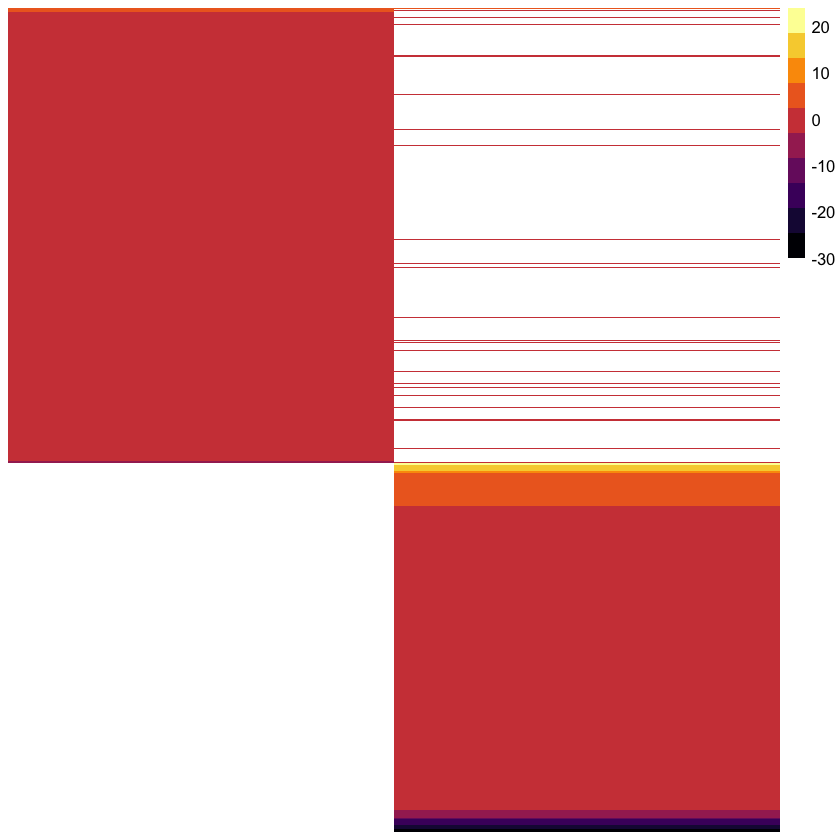

In [476]:
pheatmap(GF_SPF_F_8w_comp, cluster_rows=F, cluster_cols=F, show_rownames=F, show_colnames=F, color=inferno(10))  

### Detailed comparison

- Checking the correlation between the counts of Erny and our counts
- Re-running a DGE analysis on the Erny's raw counts

In [477]:
SPF_F_8w_samples = c('SPF_8w_F_1_2','SPF_8w_F_3_2','SPF_8w_F_4_2','SPF_8w_F_5_2')
GF_F_8w_samples = c('GF_8w_F_1_2','GF_8w_F_2_2','GF_8w_F_3_2','GF_8w_F_4_2','GF_8w_F_5_2')
SPF_8w_counts = counts[,SPF_F_8w_samples]
GF_8w_counts = counts[,GF_F_8w_samples]

In [478]:
# Erny data: counts and try to correlate them with our counts
erny_counts = read.csv("../data/erny_counts.csv")
erny_counts[,1] = capFirst(as.character(erny_counts[,1]))
rownames(erny_counts) = erny_counts[,2]
erny_counts = erny_counts[,c(1,4:17)]
erny_counts[erny_counts[,1] == "1700001c19rik",1] = "1700001C19Rik"
erny_counts[erny_counts[,1] == "Fam125a",1] = "Mvb12a"
erny_counts[erny_counts[,1] == "Sepw1",1] = "Selenow"
erny_counts[erny_counts[,1] == "Ppapdc3",1] = "Plpp7"
erny_counts[erny_counts[,1] == "Ccdc101",1] = "Sgf29"
erny_counts[erny_counts[,1] == "Tcfeb",1] = "Tfeb"
erny_counts[erny_counts[,1] == "2810408m09rik",1] = "Trp53rka"
erny_counts[erny_counts[,1] == "2300009a05rik",1] = "2300009A05Rik"
erny_counts[erny_counts[,1] == "2900010m23rik",1] = "Uqcc2"
erny_counts[erny_counts[,1] == "Ccdc55",1] = "Nsrp1"
erny_counts[erny_counts[,1] == "Phf15",1] = "Jade2"
erny_counts[erny_counts[,1] == "Mobkl2a",1] = "Mob3a"
erny_counts[erny_counts[,1] == "C030046i01rik",1] = "R3hdm4"
erny_counts[erny_counts[,1] == "H2-dmb1",1] = "H2-DMb1"
erny_counts[erny_counts[,1] == "D15ertd621e",1] = "Fam91a1"
erny_counts[erny_counts[,1] == "Bc030336",1] = "BC030336"
erny_counts[erny_counts[,1] == "C330007p06rik",1] = "C330007P06Rik"
erny_counts[erny_counts[,1] == "4931406h21rik",1] = "4931406H21Rik"
erny_counts[erny_counts[,1] == "Gm13253",1] = "Rps15a-ps4"
erny_counts[erny_counts[,1] == "Hiatl1",1] = "Mfsd14b"
erny_counts[erny_counts[,1] == "Bc031353",1] = "Fam214a"
erny_counts[erny_counts[,1] == "Cep110",1] = "Cntrl"
erny_counts[erny_counts[,1] == "B130006d01rik",1] = "B130006D01Rik"
erny_counts[erny_counts[,1] == "D6wsu163e",1] = "D6Wsu163e"
erny_counts[erny_counts[,1] == "Fam82b",1] = "Rmdn1"
erny_counts[erny_counts[,1] == "6030458c11rik",1] = "6030458C11Rik"
erny_counts[erny_counts[,1] == "Smek2",1] = "Ppp4r3b"
erny_counts[erny_counts[,1] == "9330151l19rik",1] = "9330151L19Rik"
erny_counts[erny_counts[,1] == "2010015l04rik",1] = "Cfap74"
erny_counts[erny_counts[,1] == "Ccdc46",1] = "Cep112"
erny_counts[erny_counts[,1] == "4932438a13rik",1] = "4932438A13Rik"
erny_counts[erny_counts[,1] == "B930003m22rik",1] = "Cahm"
erny_counts[erny_counts[,1] == "4933406i18rik",1] = "4933406I18Rik"
erny_counts[erny_counts[,1] == "4933434e20rik",1] = "4933434E20Rik"
erny_counts[erny_counts[,1] == "Ccdc90a",1] = "Mcur1"
erny_counts[erny_counts[,1] == "9930021j03rik",1] = "9930021J03Rik"
erny_counts[erny_counts[,1] == "E030024n20rik",1] = "E030024N20Rik"
erny_counts[erny_counts[,1] == "C78339",1] = "Fam8a1"
erny_counts[erny_counts[,1] == "2700049a03rik",1] = "2700049A03Rik"
erny_counts[erny_counts[,1] == "9530008l14rik",1] = "Adtrp"
erny_counts[erny_counts[,1] == "4930578n16rik",1] = "Ccdc173"
erny_counts[erny_counts[,1] == "Tmem22",1] = "Slc35g2"
erny_counts[erny_counts[,1] == "Fert2",1] = "Fer"
erny_counts[erny_counts[,1] == "D830031n03rik",1] = "D830031N03Rik"
erny_counts[erny_counts[,1] == "A730069n07rik",1] = "Dlc1"
erny_counts[erny_counts[,1] == "1700020d05rik",1] = "1700020D05Rik"
erny_counts[erny_counts[,1] == "Nlrp1c",1] = "Nlrp1c-ps"
erny_counts[erny_counts[,1] == "D3ertd751e",1] = "D3Ertd751e"

In [479]:
# Extract counts comparable with our counts
comparable = which(erny_counts[,1] %in% rownames(GF_8w_counts))
erny_GF_counts = erny_counts[comparable,c("Symbols",paste("GF_", 1:5, sep=""),paste("GF_", 7:8, sep=""))]
erny_SPF_counts = erny_counts[comparable,c("Symbols",paste("SPF_", 1:4, sep=""),paste("SPF_", 6:8, sep=""))]
# Extract counts comparable with Erny's counts
GF_F_8w_counts = GF_8w_counts[erny_GF_counts[,1],]
SPF_F_8w_counts = SPF_8w_counts[erny_SPF_counts[,1],]
# Check again the genes
genes = which(erny_GF_counts[,1] == rownames(GF_F_8w_counts))
erny_GF_counts = erny_GF_counts[genes,]
erny_SPF_counts = erny_SPF_counts[genes,]
GF_F_8w_counts = GF_F_8w_counts[genes,]
SPF_F_8w_counts = SPF_F_8w_counts[genes,]
sum(erny_SPF_counts[,1] != rownames(SPF_F_8w_counts))
sum(erny_SPF_counts[,1] == rownames(SPF_F_8w_counts))
# Compute correlation between the counts of Erny and ours
sapply(1:dim(SPF_F_8w_counts)[2], function(y) return(sapply(2:dim(erny_SPF_counts)[2], function(x) cor.test(SPF_F_8w_counts[,y],erny_SPF_counts[,x])$estimate)))
sapply(1:dim(GF_F_8w_counts)[2], function(y) return(sapply(2:dim(erny_GF_counts)[2], function(x) cor.test(GF_F_8w_counts[,y],erny_GF_counts[,x])$estimate)))
sapply(1:dim(GF_F_8w_counts)[2], function(y) return(sapply(2:dim(erny_SPF_counts)[2], function(x) cor.test(GF_F_8w_counts[,y],erny_SPF_counts[,x])$estimate)))
sapply(2:dim(erny_GF_counts)[2], function(y) return(sapply(2:dim(erny_SPF_counts)[2], function(x) cor.test(erny_GF_counts[,y],erny_SPF_counts[,x])$estimate)))
sapply(1:dim(SPF_F_8w_counts)[2], function(y) return(sapply(2:dim(GF_F_8w_counts)[2], function(x) cor.test(SPF_F_8w_counts[,y],GF_F_8w_counts[,x])$estimate)))

[1] 0

[1] 12286

[,1]      [,2]      [,3]      [,4]     
cor 0.7769398 0.7816535 0.7997585 0.8816721
cor 0.7769940 0.7830311 0.8020818 0.8939542
cor 0.7887277 0.7944526 0.8150479 0.9102571
cor 0.7941965 0.7989847 0.8177015 0.9010538
cor 0.7896045 0.7964918 0.8160823 0.9085424
cor 0.7841238 0.7894215 0.8082085 0.8936985
cor 0.7951989 0.8007848 0.8154777 0.8783128

[,1]      [,2]      [,3]      [,4]      [,5]     
cor 0.7938350 0.7987404 0.8055513 0.8141901 0.8152385
cor 0.7872088 0.7921302 0.7995368 0.8080266 0.8096330
cor 0.7849356 0.7900680 0.7992085 0.8072838 0.8092637
cor 0.7961496 0.8007634 0.8074597 0.8159007 0.8172874
cor 0.7933764 0.7981911 0.8075481 0.8154211 0.8179928
cor 0.7870029 0.7916546 0.7986597 0.8071867 0.8083360
cor 0.7818650 0.7870289 0.7962327 0.8042746 0.8069408

[,1]      [,2]      [,3]      [,4]      [,5]     
cor 0.7947391 0.7998857 0.8041347 0.8126957 0.8134518
cor 0.7958869 0.8010940 0.8081024 0.8158324 0.8174809
cor 0.8093012 0.8140582 0.8220934 0.8295025 0.8316729
cor 0.8130085 0.8174151 0.8235299 0.8312461 0.8327391
cor 0.8085658 0.8137848 0.8219957 0.8287772 0.8314245
cor 0.8027425 0.8077495 0.8135723 0.8212356 0.8227956
cor 0.8084469 0.8137227 0.8164268 0.8240413 0.8255415

[,1]      [,2]      [,3]      [,4]      [,5]      [,6]      [,7]     
cor 0.9925813 0.9899828 0.9864286 0.9918202 0.9833893 0.9899565 0.9855724
cor 0.9906982 0.9911502 0.9921497 0.9904767 0.9847038 0.9908692 0.9895241
cor 0.9937974 0.9925353 0.9935564 0.9922120 0.9928133 0.9900984 0.9947634
cor 0.9922729 0.9906117 0.9884023 0.9923317 0.9872432 0.9888941 0.9886040
cor 0.9893126 0.9900316 0.9927839 0.9881774 0.9881447 0.9888126 0.9922836
cor 0.9921623 0.9924745 0.9912527 0.9918313 0.9849888 0.9925718 0.9888195
cor 0.9789183 0.9791822 0.9751012 0.9810808 0.9677277 0.9809921 0.9716861

[,1]      [,2]      [,3]      [,4]     
cor 0.9961534 0.9963294 0.9974333 0.9248472
cor 0.9939150 0.9936832 0.9961351 0.9339539
cor 0.9937437 0.9936712 0.9963917 0.9359059
cor 0.9930265 0.9936623 0.9966102 0.9370905

In [480]:
# Run a DGE expression on the Erny counts
erny_dge_counts = erny_counts[,c(2:15)]
head(erny_dge_counts)
erny_metadata = matrix(c(rep("GF",7),rep("SPF",7)))
colnames(erny_metadata) = c("type")
# Construct DESeqDataSet
erny_dds = DESeqDataSetFromMatrix(
        countData = erny_dge_counts,
        colData = erny_metadata,
        design = ~ type)
# Organize levels of the factors (8w being the reference)
erny_dds$type = relevel(erny_dds$type, ref="SPF")
# Differential expression analysis
erny_dge = DESeq(erny_dds)

GF_1  GF_2  GF_3  GF_4  GF_5  GF_7  GF_8  SPF_1 SPF_2 SPF_3 SPF_4
NR_030465   255   243   254   224   281   256   288   152   159   159   151
NM_024270    53    59    46    68    55    47    50   146   151   162   119
NM_021878    31    30    29    32    34    24    32    57    67    59    57
NM_007572 15688 17675 17330 16259 18370 17349 17891 12218 10782 13078 12967
NM_009847    18     3    14     5    18    10    11    46    40    37    39
NM_013765   327   290   278   248   322   276   284   208   162   173   183
          SPF_6 SPF_7 SPF_8
NR_030465   133   148  135 
NM_024270   178   130  167 
NM_021878    59    55   73 
NM_007572 11261 12017 9982 
NM_009847    38    32   49 
NM_013765   161   166  186

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 23 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [481]:
# Extraction of DE genes
erny_dge_res = results(erny_dge, alpha=0.05, test="Wald")
erny_sign_deg = erny_dge_res[which(erny_dge_res$padj < 0.05),]

In [482]:
# Run a DGE expression on our counts with only the F 8w samples
SPF_GF_8w_F_counts = cbind(GF_8w_counts, SPF_8w_counts)
SPF_GF_8w_F_metadata = matrix(t(sapply(sapply(colnames(SPF_GF_8w_F_counts), strsplit, split = "_"), unlist))[,1])
colnames(SPF_GF_8w_F_metadata) = c("type")
# Construct DESeqDataSet
SPF_GF_8w_F_dds = DESeqDataSetFromMatrix(
        countData = SPF_GF_8w_F_counts,
        colData = SPF_GF_8w_F_metadata,
        design = ~ type)
# Organize levels of the factors
SPF_GF_8w_F_dds$type = relevel(SPF_GF_8w_F_dds$type, ref="SPF")
# Differential expression analysis
SPF_GF_8w_F_dge = DESeq(SPF_GF_8w_F_dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [483]:
# Extraction of the DE genes
SPF_GF_8w_F_dge_res = results(SPF_GF_8w_F_dge, alpha=0.05, test="Wald")
SPF_GF_8w_F_sign_deg = SPF_GF_8w_F_dge_res[which(SPF_GF_8w_F_dge_res$padj < 0.05),]

In [484]:
SPF_GF_8w_F_comp = matrix("", nrow=4,ncol=4)
rownames(SPF_GF_8w_F_comp) = c("Original Erny results", "DESeq on Erny counts", "DESeq with only the 8w F", "Full DESeq")
colnames(SPF_GF_8w_F_comp) = rownames(SPF_GF_8w_F_comp)
SPF_GF_8w_F_comp[1,1] = dim(erny_results)[1]
SPF_GF_8w_F_comp[2,2] = dim(erny_sign_deg)[1]
SPF_GF_8w_F_comp[3,3] = dim(SPF_GF_8w_F_sign_deg)[1]
SPF_GF_8w_F_comp[4,4] = length(GF_SPF_F_8w_fc_deg)
SPF_GF_8w_F_comp[1,2] = sum(rownames(erny_sign_deg) %in% erny_results[,2])
SPF_GF_8w_F_comp[1,3] = sum(rownames(SPF_GF_8w_F_sign_deg) %in% erny_results[,1])
SPF_GF_8w_F_comp[1,4] = sum(names(GF_SPF_F_8w_fc_deg) %in% erny_results[,1])
erny_sign_deg_symbols = erny_counts[rownames(erny_sign_deg),1]
SPF_GF_8w_F_comp[2,3] = sum(erny_sign_deg_symbols %in% rownames(SPF_GF_8w_F_sign_deg))
SPF_GF_8w_F_comp[2,4] = sum(erny_sign_deg_symbols %in% names(GF_SPF_F_8w_fc_deg))
SPF_GF_8w_F_comp[3,4] = sum(rownames(SPF_GF_8w_F_sign_deg) %in% names(GF_SPF_F_8w_fc_deg))
SPF_GF_8w_F_comp
#
t1 = rownames(SPF_GF_8w_F_sign_deg[rownames(SPF_GF_8w_F_sign_deg) %in% erny_results[,1],])
t2 = names(GF_SPF_F_8w_fc_deg[names(GF_SPF_F_8w_fc_deg) %in% erny_results[,1]])
sum(t1 %in% t2)
# 
t1 = rownames(SPF_GF_8w_F_sign_deg[rownames(SPF_GF_8w_F_sign_deg) %in% erny_sign_deg_symbols,])
t2 = names(GF_SPF_F_8w_fc_deg[names(GF_SPF_F_8w_fc_deg) %in% erny_sign_deg_symbols])
sum(t1 %in% t2)

Original Erny results DESeq on Erny counts
Original Erny results    453                   396                 
DESeq on Erny counts                           973                 
DESeq with only the 8w F                                           
Full DESeq                                                         
                         DESeq with only the 8w F Full DESeq
Original Erny results    27                       24        
DESeq on Erny counts     54                       50        
DESeq with only the 8w F 312                      150       
Full DESeq                                        392

[1] 18

[1] 33

# Saving (for Galaxy)

In [485]:
# Save the notebook into the history
system("put -p dge_analysis.ipynb -t ipynb", intern=T)

ERROR: Error in system("put -p dge_analysis.ipynb -t ipynb", intern = T): error in running command
